In [1]:
import time
import os
import os.path as op

import numpy as np
import pandas as pd
import glob
import pickle

import scipy as sp
from scipy import stats
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt

#from idealObserver2 import io_with_derivations 

"""
Created on: Sept 11, 2023
Latest update: Dec 7, 2023
Author: @zoeheez



Description: 

This script is a draft for testing different processing and analysis pipline for pupil data.

"""

'\nCreated on: Sept 11, 2023\nLatest update: Dec 7, 2023\nAuthor: @zoeheez\n\n\n\nDescription: \n\nThis script is a draft for testing different processing and analysis pipline for pupil data.\n\n'

In [2]:
# import all pkl files 

# get the project directory (cbandit)
proj_dir = os.path.normpath(os.getcwd()) #+ os.sep + os.pardir)
print(f'project directory: {proj_dir}')

f_pupil = open(proj_dir+"/pupil_epochs_all_new2.pkl","rb")
pupil_data_holder = pickle.load(f_pupil)

f_behavioral = open(proj_dir+"/behavioral_data_cleaned.pkl","rb")
behavioral_data_holder = pickle.load(f_behavioral)

f_model = open(proj_dir+"/model_based_variables.pkl","rb")
model_data_holder = pickle.load(f_model)

data_ff = pd.read_pickle('outputs_ff.p')
valid_sub = np.array(data_ff['subnums'])[:-2]
valid_sub = np.delete(valid_sub, np.where(valid_sub == 35)[0][0])

valid_sub_new = np.delete(valid_sub, [17,18]) # delete sub 24, 25
valid_sub_new_new = np.delete(valid_sub_new, 23)
valid_sub_new_new


nsess = 8

print('valid subjects: ', valid_sub_new_new)

print('invalid sessions: subject 24, sess 6; subject 34, sess 8')
        #if sub+1 == 24 and sess+1 == 6:
        #    continue
        #if sub+1 == 34 and sess+1 == 8:
        #    continue

project directory: /Users/zoehe/Documents/GitHub/cbandit_23
valid subjects:  [ 1  2  3  4  6  8 10 11 12 13 14 16 19 20 21 22 23 26 27 28 29 30 31 33
 34 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
invalid sessions: subject 24, sess 6; subject 34, sess 8


In [3]:
print('data_ff (Alex) columns: ', data_ff.keys())
print('vol min: ', data_ff['params_alldata']['vol'].to_numpy().flatten().min())
print('vol max: ', data_ff['params_alldata']['vol'].to_numpy().flatten().max())

data_ff (Alex) columns:  dict_keys(['subnums', 'subids', 'paramnames', 'parampairnames', 'tp_idx', 'params', 'params_raw', 'params_gt10', 'mdl_accuracy', 'params_alldata', 'nobs', 'reg_avg', 'reg_std', 'reg_cor', 'params_avg', 'params_ste', 'mdl_accuracy_avg', 'mdl_accuracy_ste', 'nobs_avg', 'reg_avg_avg', 'reg_std_avg', 'reg_cor_avg', 'reg_avg_ste', 'reg_std_ste', 'reg_cor_ste'])
vol min:  0.006071067149682751
vol max:  0.4554553707245781


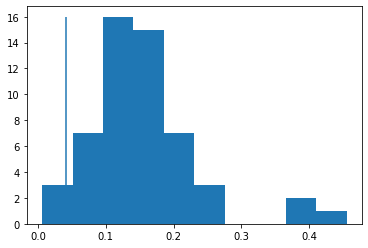

In [4]:
arr = np.sort(data_ff['params_alldata']['vol'].to_numpy().flatten())
plt.hist(arr)
plt.vlines(x=1/24, ymin=0, ymax=16)

In [5]:
import numpy as np
from scipy import stats

stats.ttest_1samp(arr, 1/24)

Ttest_1sampResult(statistic=9.832009601399655, pvalue=1.5163785428351054e-13)

Other things to add after filtering:
1. determine whether each trial is a 'switch' or 'stay' choice
2. determine whether the NEXT trial is a switch or stay choice
3. determine whether the current observation has increased or decreased outcome

1. find the observed changepoint (aka: current trial = stay, changepoint = True)
2. find the high-to-low changepoint (aka: decreased outcome = True, changepoint = True)
3. find the trial_after_forced
4. find the trial_after_cp

In [6]:
def trial_after_forced(forced_arr):
    to_return = np.zeros(len(forced_arr))
    count = 0
    for i in range(len(forced_arr)):
        if forced_arr[i]:
            to_return[i] = 0
            count = 0
        else:
            count += 1
            to_return[i] = count
            
    return to_return.astype(int)


def trial_after_cp(cp_arr):
    to_return = np.zeros(len(cp_arr))
    
    count = 0
    for i in range(len(cp_arr)):
        if cp_arr[i]:
            count = 1
        
        to_return[i] = count
        
        if count >= 1:
            count += 1
            
    return to_return.astype(int)

def outcome_change(outcome_arr):
   
    increase_from_last = np.array([outcome_arr[i] - outcome_arr[i-1] for i in range(1, len(outcome_arr))])
    increase_from_last = np.insert(increase_from_last, 0, outcome_arr[0])
    
    return increase_from_last

In [7]:
# create a binary pickle file 
#f = open("joint_data_all_new2.pkl","wb")

# write the python object (dict) to pickle file
#pickle.dump(joint_data_all,f)

# close file
#f.close()

f_data_all = open(proj_dir+"/joint_data_all_new2.pkl","rb")
joint_data_all = pickle.load(f_data_all)


In [8]:
pupil_data_holder['sub34']['sess3']

trial     rt                               pupil_baseline_start  \
0       0  1.051  [2.933345042382164, 2.968717139462586, 2.98414...   
1       1  0.962  [1.1698774188314287, 1.1599876138128076, 1.153...   
2       2  0.880  [2.078473971158071, 2.060287762926913, 2.03935...   
3       3  0.435  [0.7305780628996759, 0.7350110044097495, 0.733...   
4       4  0.998  [0.39902901096926124, 0.3732459670071015, 0.36...   
..    ...    ...                                                ...   
91     91  4.154  [0.3568045904373347, 0.3556283925328408, 0.360...   
92     92  2.085  [0.3272539041962875, 0.31992114762718976, 0.33...   
93     93  4.394  [0.6270140642683505, 0.6209807919688762, 0.586...   
94     94  0.592  [-0.41361673746079386, -0.3896059558189535, -0...   
95     95  0.437  [0.41796023379002967, 0.39584925702469237, 0.3...   

                               pupil_baseline_outcome  \
0   [2.812066467409069, 2.7616249107792306, 2.7027...   
1   [0.9043595358734244, 0.9381960647907778, 0.981...   
2   [1.1001955802472723, 1.1221437572157094, 1.133...   
3   [1.4414224688383825, 1.4450573943665197, 1.444...   
4   [0.6384492126579742, 0.6306896958435741, 0.619...   
..                                                ...   
91  [0.6975875530183409, 0.7026663608538385, 0.709...   
92  [0.5631786965052097, 0.5755927210505357, 0.576...   
93  [0.18556265260660243, 0.18886375572407946, 0.1...   
94  [1.0087597170058706, 1.0252831949766728, 1.023...   
95  [0.221646163831642, 0.2118204850561917, 0.2093...   

                              pupil_size_pre_response  \
0   [4.364888744470003, 4.387535997416547, 4.40444...   
1   [0.6749122979274357, 0.6695175050782362, 0.657...   
2   [1.5491971859094624, 1.542604004956765, 1.5371...   
3   [0.8482188492038787, 0.8593282671976002, 0.862...   
4   [0.39725970422687545, 0.4146235432034372, 0.42...   
..                                                ...   
91  [-0.028739641277444064, -0.038569253718148976,...   
92  [-0.41385648112868, -0.3985543451571906, -0.36...   
93  [0.3529458321416499, 0.366590895801996, 0.3833...   
94  [-0.042356352681543065, -0.010568089905271002,...   
95  [0.33787414722143555, 0.33674152840162824, 0.3...   

    pupil_size_avg_pre_response  \
0                      4.346174   
1                      0.685805   
2                      1.451777   
3                      0.998842   
4                      0.397034   
..                          ...   
91                    -0.022972   
92                    -0.162170   
93                     0.474248   
94                     0.085395   
95                     0.581389   

                                  pupil_size_response  \
0   [4.162557215653608, 4.14845792350004, 4.138690...   
1   [0.725031016376615, 0.738078599436283, 0.75947...   
2   [1.379432549408381, 1.3891577198844636, 1.4071...   
3   [1.0809951903551394, 1.075069074517905, 1.0923...   
4   [0.37602687755746456, 0.37518360545428414, 0.3...   
..                                                ...   
91  [-0.012159065472592266, 0.015890856492351987, ...   
92  [-0.025472210239515708, -0.0029804924542203124...   
93  [0.5339675480425713, 0.5496444086342464, 0.555...   
94  [0.13298569431853635, 0.12959518647136345, 0.1...   
95  [0.7594217488374722, 0.793430722906146, 0.8127...   

    pupil_size_avg_response  \
0                  3.628383   
1                  0.957477   
2                  0.916894   
3                  1.450539   
4                  0.754914   
..                      ...   
91                 0.663827   
92                 0.606586   
93                 0.498056   
94                 0.291577   
95                 0.808820   

                                   pupil_size_outcome  pupil_size_avg_outcome  \
0   [2.812066467409069, 2.7616249107792306, 2.7027...                1.747353   
1   [0.9043595358734244, 0.9381960647907778, 0.981...                1.607054   
2   [1.1001955802472723, 1.1221437572157094, 1.133...      

In [9]:
test_data = joint_data_all['sub3']['sess7']
test_data['trial_after_forced']

0     0
1     0
2     0
3     0
4     1
     ..
91    4
92    5
93    6
94    7
95    8
Name: trial_after_forced, Length: 96, dtype: int64

In [10]:
test_data.columns

Index(['index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen

In [11]:
test_data.head()

index  trial     rt                               pupil_baseline_start  \
0      0      0  0.615  [3.4943289452924784, 3.6201503559856016, 3.658...   
1      1      1  0.636  [1.8177416161235898, 1.7776879685920277, 1.566...   
2      2      2  0.454  [0.9669905894364189, 0.8438690356157356, 0.990...   
3      3      3  0.577  [1.5876280900245823, 1.6163412603173137, 1.597...   
4      4      4  0.982  [1.2516132300292016, 1.2136400193782357, 1.193...   

                              pupil_baseline_outcome  \
0  [2.6047685529150186, 2.600503519914743, 2.6720...   
1  [1.9212231295924718, 1.8965065125923266, 1.851...   
2  [1.541031168906833, 1.6240573194756656, 1.6910...   
3  [1.3969032157077375, 1.4081162165824346, 1.421...   
4  [0.41902213923709236, 0.4665330593896537, 0.51...   

                             pupil_size_pre_response  \
0  [3.8890624453706484, 3.9150637885583848, 3.918...   
1  [2.034466859233352, 2.0491064265226897, 1.9958...   
2  [1.1373285211494024, 1.232087723277475, 1.2628...   
3  [1.6974839477160701, 1.6094846742274511, 1.596...   
4  [0.5481876823105208, 0.604136001762113, 0.6214...   

   pupil_size_avg_pre_response  \
0                     3.646467   
1                     2.034766   
2                     1.315238   
3                     1.601743   
4                     0.836744   

                                 pupil_size_response  pupil_size_avg_response  \
0  [3.3323658599351598, 3.3778578992816937, 3.367...                 3.133123   
1  [2.040376050998603, 2.0396342176679907, 2.0392...                 1.600773   
2  [1.3305806630054169, 1.6590046688950184, 1.702...                 1.220098   
3  [1.5744877161114594, 1.5816334144541917, 1.579...                 1.186829   
4  [1.0811051556281805, 1.0832660528791125, 0.961...                 0.743950   

                                  pupil_size_outcome  ...  ER_diff_after  \
0  [2.6047685529150186, 2.600503519914743, 2.6720...  ...      -6.515526   
1  [1.9212231295924718, 1.8965065125923266, 1.851...  ...      19.685362   
2  [1.541031168906833, 1.6240573194756656, 1.6910...  ...     -15.103694   
3  [1.3969032157077375, 1.4081162165824346, 1.421...  ...      19.138361   
4  [0.41902213923709236, 0.4665330593896537, 0.51...  ...      20.856915   

   EU_diff_before  EU_diff_after UU_diff_before  UU_diff_after switch  \
0        0.000000      -0.298704       0.000000       0.000000  False   
1        0.298704      -0.161364       0.000000       0.000000   True   
2        0.161364      -0.150929       0.000000      -0.124075   True   
3        0.150929      -0.116529       0.124075      -0.089672   True   
4       -0.116529      -0.310110      -0.089672      -0.179312  False   

   switch_next outcome_change  trial_after_forced  trial_after_cp  
0         True           43.0                   0               0  
1         True           22.0                   0               0  
2         True          -20.0                   0               0  
3        False           19.0                   0               0  
4        False            3.0                   1               0  

[5 rows x 64 columns]

In [12]:
test_data[['forced', 'trial_after_forced']]

forced  trial_after_forced
0     True                   0
1     True                   0
2     True                   0
3     True                   0
4    False                   1
..     ...                 ...
91   False                   4
92   False                   5
93   False                   6
94   False                   7
95   False                   8

[96 rows x 2 columns]

In [13]:
# rank the forced trials:

for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        sample_data = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']
        test_forced = sample_data['forced']
        
        forced_num = np.zeros(len(test_forced))

        count = 0
        for i in range(len(test_forced)):
            if test_forced[i]:
                count += 1
            else:
                count = 0

            forced_num[i] = count
        
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_forced'] = forced_num.astype(int)
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_num'] = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['index']

In [14]:
test_data = joint_data_all['sub3']['sess7']
test_data.head()

index  trial     rt                               pupil_baseline_start  \
0      0      0  0.615  [3.4943289452924784, 3.6201503559856016, 3.658...   
1      1      1  0.636  [1.8177416161235898, 1.7776879685920277, 1.566...   
2      2      2  0.454  [0.9669905894364189, 0.8438690356157356, 0.990...   
3      3      3  0.577  [1.5876280900245823, 1.6163412603173137, 1.597...   
4      4      4  0.982  [1.2516132300292016, 1.2136400193782357, 1.193...   

                              pupil_baseline_outcome  \
0  [2.6047685529150186, 2.600503519914743, 2.6720...   
1  [1.9212231295924718, 1.8965065125923266, 1.851...   
2  [1.541031168906833, 1.6240573194756656, 1.6910...   
3  [1.3969032157077375, 1.4081162165824346, 1.421...   
4  [0.41902213923709236, 0.4665330593896537, 0.51...   

                             pupil_size_pre_response  \
0  [3.8890624453706484, 3.9150637885583848, 3.918...   
1  [2.034466859233352, 2.0491064265226897, 1.9958...   
2  [1.1373285211494024, 1.232087723277475, 1.2628...   
3  [1.6974839477160701, 1.6094846742274511, 1.596...   
4  [0.5481876823105208, 0.604136001762113, 0.6214...   

   pupil_size_avg_pre_response  \
0                     3.646467   
1                     2.034766   
2                     1.315238   
3                     1.601743   
4                     0.836744   

                                 pupil_size_response  pupil_size_avg_response  \
0  [3.3323658599351598, 3.3778578992816937, 3.367...                 3.133123   
1  [2.040376050998603, 2.0396342176679907, 2.0392...                 1.600773   
2  [1.3305806630054169, 1.6590046688950184, 1.702...                 1.220098   
3  [1.5744877161114594, 1.5816334144541917, 1.579...                 1.186829   
4  [1.0811051556281805, 1.0832660528791125, 0.961...                 0.743950   

                                  pupil_size_outcome  ...  EU_diff_after  \
0  [2.6047685529150186, 2.600503519914743, 2.6720...  ...      -0.298704   
1  [1.9212231295924718, 1.8965065125923266, 1.851...  ...      -0.161364   
2  [1.541031168906833, 1.6240573194756656, 1.6910...  ...      -0.150929   
3  [1.3969032157077375, 1.4081162165824346, 1.421...  ...      -0.116529   
4  [0.41902213923709236, 0.4665330593896537, 0.51...  ...      -0.310110   

   UU_diff_before  UU_diff_after switch  switch_next outcome_change  \
0        0.000000       0.000000  False         True           43.0   
1        0.000000       0.000000   True         True           22.0   
2        0.000000      -0.124075   True         True          -20.0   
3        0.124075      -0.089672   True        False           19.0   
4       -0.089672      -0.179312  False        False            3.0   

   trial_after_forced trial_after_cp  trial_forced  trial_num  
0                   0              0             1          0  
1                   0              0             2          1  
2                   0              0             3          2  
3                   0              0             4          3  
4                   1              0             0          4  

[5 rows x 66 columns]

In [15]:
# 1. combine across sessions for each subject
joint_data_by_sub = {}
for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        sample_data = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']
        sample_data['RPE_before'] = np.insert(sample_data['RPE'].to_numpy(), 0, 0)[:-1]
        sample_data['sess'] = (np.ones(len(sample_data)) * (sess+1)).astype(int)

        joint_data_each_sub = pd.concat([joint_data_each_sub, sample_data], axis=0)
    
    joint_data_each_sub = joint_data_each_sub.reset_index()
    joint_data_by_sub[f'sub{sub+1}'] = joint_data_each_sub

In [16]:
joint_data_each_sub

level_0  index  trial      rt  \
0          0      0      0  14.307   
1          1      1      1   1.950   
2          2      2      2   1.203   
3          3      3      3   0.836   
4          4      4      4   0.886   
..       ...    ...    ...     ...   
763       91     91     91   1.142   
764       92     92     92   0.316   
765       93     93     93   0.412   
766       94     94     94   0.319   
767       95     95     95   0.325   

                                  pupil_baseline_start  \
0    [0.4512524809076589, 0.47358640073485514, 0.47...   
1    [0.3728106435716297, 0.30595267957474026, 0.26...   
2    [0.4531594955862836, 0.4505523408239858, 0.446...   
3    [0.2493712974503475, 0.1797073611349643, 0.160...   
4    [0.2329468694457934, 0.2195645528616627, 0.246...   
..                                                 ...   
763  [0.67943674845904, 0.7272363341078137, 0.73705...   
764  [-0.17780774209706132, -0.13794868236501812, -...   
765  [-1.203478368664157, -1.1643138433366318, -1.1...   
766  [-1.6546526797253853, -1.6049083492062692, -1....   
767  [0.5476487169455556, 0.40803424555855716, 0.35...   

                                pupil_baseline_outcome  \
0    [1.3595958934327117, 1.375846837164174, 1.3522...   
1    [0.16848354928987766, 0.17813835699020253, 0.1...   
2    [-0.9279685749872779, -0.9453852131180074, -0....   
3    [-0.6720455772971883, -0.7191280822572133, -0....   
4    [1.7544874871463856, 1.7720780239957616, 1.805...   
..                                                 ...   
763  [0.5511960490811909, 0.5499120983188762, 0.581...   
764  [-0.8800874249291134, -0.863458312754363, -0.8...   
765  [-3.327919441521653, -3.3458417071503943, -3.3...   
766  [-0.23448572896024178, -0.11422985799373579, -...   
767  [-0.6308113880375159, -0.6443178855941037, -0....   

                               pupil_size_pre_response  \
0    [0.9012625772442107, 0.923419756338039, 0.9813...   
1    [0.13093264392753065, 0.14002343053940322, 0.1...   
2    [0.8564177916882505, 0.874603580597752, 0.9877...   
3    [1.0092325215058655, 1.0060257517126063, 1.014...   
4    [0.8322483658106244, 0.8368113607088992, 0.775...   
..                                                 ...   
763  [1.0707077050777225, 1.0654853260524422, 1.070...   
764  [-0.14873885096615147, -0.11531997069426185, -...   
765  [-1.1940200358695918, -1.1961699578124045, -1....   
766  [-1.558495613955596, -1.5328490750914376, -1.4...   
767  [0.41406870553831127, 0.3766595113669954, 0.35...   

     pupil_size_avg_pre_response  \
0                       1.090340   
1                       0.347182   
2                       0.664230   
3                       1.172001   
4                       0.847741   
..                           ...   
763                     1.213163   
764                     0.221271   
765                    -1.551658   
766                    -1.222526   
767                     0.228686   

                                   pupil_size_response  \
0    [1.1884758345129462, 1.1722194968436488, 1.195...   
1    [0.49289570133733357, 0.5141890876747841, 0.56...   
2    [0.4956462720515597, 0.4535649306316723, 0.427...   
3    [1.3851556862149352, 1.388967864655642, 1.3178...   
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
..                                                 ...   
763  [1.3801842435307121, 1.323949527624748, 1.1854...   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   
765  [-1.7172245184480575, -1.7368905531884036, -1....   
766  [-1.106845834894351, -1.1308387794174326, -1.1...   
767  [0.11716046275001123, 0.10990970946557645, 0.1...   

     pupil_size_avg_response  ... UU_diff_after  switch  switch_next  \
0                   1.232890  ...      0.000000   False         True   
1                   0.340092  ...      0.000000    True         True   
2                  -0.219130  ...      0.121558    True        False   
3                   0.612900  ...     -

In [17]:
joint_data_by_sub['sub1'].keys()

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [18]:
joint_data_by_sub.keys()

dict_keys(['sub1', 'sub2', 'sub3', 'sub4', 'sub6', 'sub8', 'sub10', 'sub11', 'sub12', 'sub13', 'sub14', 'sub16', 'sub19', 'sub20', 'sub21', 'sub22', 'sub23', 'sub24', 'sub25', 'sub26', 'sub27', 'sub28', 'sub29', 'sub30', 'sub31', 'sub32', 'sub33', 'sub34', 'sub36', 'sub37', 'sub38', 'sub39', 'sub40', 'sub41', 'sub43', 'sub44', 'sub45', 'sub47', 'sub48', 'sub49', 'sub50', 'sub51', 'sub52', 'sub53', 'sub54', 'sub55', 'sub56', 'sub57', 'sub58', 'sub59', 'sub60'])

In [19]:
# 2. plot the average pupil trace for individual subjects
annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':12}}
sns.set_theme(style="whitegrid")

def plot_pupil_responses(epoch_time, Y, labels, where):
    gridsize = (1,1)
    fig = plt.figure(figsize=(6, 4))
    ax4 = plt.subplot2grid(gridsize, (0, 0))

    x = epoch_time
    num_lines = len(Y)
    y1_all = []
    for i in range(num_lines):
        y1_or = Y[i]
        
        y1 = np.mean(y1_or,axis=0)
        y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        ax4.plot(x, y1, label=labels[i])
        ax4.axvline(x=0,color=".2", linestyle="--")

        ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        y1_all.append(y1)

    ax4.set_title(f'Pupil change on around {where}',fontsize=18) #Pupil change to different change points 
    ax4.set_ylabel('average pupil change',fontsize=18)
    ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
    #ax4.set_ylim([-0.08, 0.08])
    ax4.legend(prop={"size":16})
    plt.legend()
    
    return y1_all
        

In [20]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

dict_keys(['t_pre_response', 't_response', 't_outcome'])

In [21]:
joint_data=joint_data_by_sub['sub1']

In [22]:
joint_data

level_0  index  trial     rt  \
0          0      0      0  0.873   
1          1      1      1  0.503   
2          2      2      2  0.948   
3          3      3      3  0.633   
4          4      4      4  1.754   
..       ...    ...    ...    ...   
763       91     91     91  1.292   
764       92     92     92  0.373   
765       93     93     93  0.350   
766       94     94     94  0.354   
767       95     95     95  0.869   

                                  pupil_baseline_start  \
0    [-0.13285487334831725, -0.15435727323074105, -...   
1    [0.14530678606560862, 0.1443430154502174, 0.24...   
2    [0.22792893919942742, 0.15482785060969537, 0.1...   
3    [-0.04115643605480424, -0.011971396588699315, ...   
4    [0.7752312920948785, 0.8033788108457145, 0.831...   
..                                                 ...   
763  [0.9440574455329321, 0.9797740013763789, 1.000...   
764  [1.168299084483247, 1.1670923863513962, 1.1944...   
765  [0.5128540402488411, 0.5474079431799694, 0.595...   
766  [0.06467445175805148, 0.06351523679661694, 0.0...   
767  [0.21963240403148176, 0.254590242586763, 0.227...   

                                pupil_baseline_outcome  \
0    [0.07491006887873684, 0.13786000971694218, 0.1...   
1    [0.23190501894722576, 0.17961922205809192, 0.1...   
2    [0.1730485920638111, 0.15684330963330576, 0.18...   
3    [-0.02837186777614119, 0.004751287527410095, 0...   
4    [0.467254551806917, 0.46196730826422516, 0.473...   
..                                                 ...   
763  [-0.2881632675597719, -0.2400962148296614, -0....   
764  [0.9511351459807956, 0.9523740032809924, 0.954...   
765  [1.0246539725728203, 1.0375120549738277, 1.049...   
766  [-0.6962144444896675, -0.6686769003726343, -0....   
767  [-0.015925371036347818, 0.01822542730157159, 0...   

                               pupil_size_pre_response  \
0    [0.11437311041501608, 0.10994014858446984, 0.1...   
1    [0.34474857188501473, 0.35575292963603705, 0.3...   
2    [-0.5578585701312097, -0.5368051541620953, -0....   
3    [0.9398780279838435, 0.9354819044102489, 0.927...   
4    [0.13627293908167493, 0.0938579818830942, 0.08...   
..                                                 ...   
763  [1.0870597990222244, 1.0612094153744953, 1.048...   
764  [1.4614223571061273, 1.5293144197778896, 1.550...   
765  [0.6125205116700386, 0.6285798356603844, 0.644...   
766  [-0.1359992371571531, -0.16171914755336544, -0...   
767  [0.805226660525375, 0.8060359610356735, 0.8060...   

     pupil_size_avg_pre_response  \
0                       0.279017   
1                       0.299246   
2                      -0.249000   
3                       0.780104   
4                      -0.051292   
..                           ...   
763                     1.108661   
764                     2.093780   
765                     0.731417   
766                    -0.317786   
767                     0.810774   

                                   pupil_size_response  \
0    [0.353667051165722, 0.39952404529320773, 0.433...   
1    [0.3427030080472347, 0.3527936049405821, 0.374...   
2    [-0.043562563000114525, -0.010950897831385292,...   
3    [0.6531173173194468, 0.6612715975477902, 0.646...   
4    [-0.1988164400882881, -0.1855046140065632, -0....   
..                                                 ...   
763  [1.1411791340983253, 1.0926622014125866, 1.073...   
764  [2.4096743256709146, 2.495328107614667, 2.5140...   
765  [0.7648195837852088, 0.7834854352008632, 0.793...   
766  [-0.3805532585940814, -0.42342857433207653, -0...   
767  [0.8137656023951827, 0.8130993982162574, 0.814...   

     pupil_size_avg_response  ... UU_diff_after  switch  switch_next  \
0                   0.475576  ...      0.000000   False        False   
1                   1.147825  ...      0.000000   False         True   
2                  -0.182329  ...     -0.006041    True        False   
3                   0.399992  ...      0.022409   F

In [23]:
joint_data['pupil_change_response']

0      [0.47757688997441433, 0.5234338841019001, 0.55...
1      [0.11745386582914089, 0.1275444627224883, 0.14...
2      [-0.23222515232129334, -0.1996134871525641, -0...
3      [0.604369662327627, 0.6125239425559704, 0.5980...
4      [-1.0554489619775056, -1.0421371358957807, -0....
                             ...                        
763    [0.13242391863585357, 0.08390698595011492, 0.0...
764    [1.1617997870953838, 1.2474535690391364, 1.266...
765    [0.18465528931901398, 0.20332114073466845, 0.2...
766    [-0.3474537690349683, -0.3903290847729634, -0....
767    [0.5810645010935362, 0.580398296914611, 0.5818...
Name: pupil_change_response, Length: 768, dtype: object

In [24]:
def make_numpy(lst):
    return np.array([np.array(lst[i]) for i in range(len(lst))])
    
    
    

In [25]:
make_numpy(joint_data['pupil_change_response']).shape

(768, 127)

In [26]:
#[len(joint_data['pupil_change_response'][i]) for i in range(len(joint_data['pupil_change_response']))]

In [27]:
# get the average for each subject

for sub in valid_sub-1:
    joint_data_by_sub[f'sub{sub+1}']

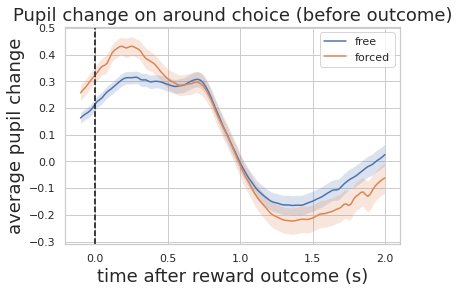

In [28]:
# plot the pupil trace based on trial types
types = ['free', 'forced']
event = 'response'

to_plot1 = joint_data[joint_data[types[0]] == True]
to_plot2 = joint_data[joint_data[types[1]] == True]

to_plot1_trace = np.array(to_plot1[f'pupil_change_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_change_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_response'], [to_plot1_trace, to_plot2_trace], types, 'choice (before outcome)')

In [29]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

(51, 2, 25)


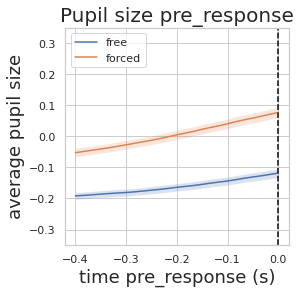

In [30]:
gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 4, 25)


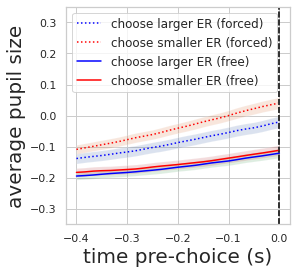

In [31]:
# plot the average for all subjects

types = ['choose larger ER (forced)', 'choose smaller ER (forced)','choose larger ER (free)', 'choose smaller ER (free)']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

#ax4.set_title(f'Pupil {metric} pre-choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time pre-choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend()
        

p=1.6340031683421095e-10


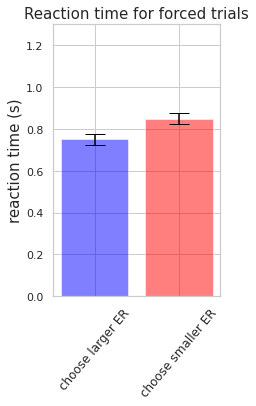

In [32]:
# find the reaction time for each group
from scipy import stats

types = ['choose larger ER', 'choose smaller ER' ]#,'larger ER (free)', 'smaller ER (free)']
metric = 'size'
event = 'pre_response'
label = 'rt'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]
    
    to_plot7 = joint_data[joint_data['trial_forced'] > 1]
    
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    
    Y = [to_plot1, to_plot2] #, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    y1_list = []
    y1_se_list = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1_list.append(np.mean(y1_or,axis=0))
        #y1_se_list.append(np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))

    Y_to_plot.append(y1_list)
    
    
Y_to_plot = np.array(Y_to_plot)
Y_to_plot.shape

y1_mean = np.mean(Y_to_plot, axis=0)

#y1_se_list = np.nanstd(y1_mean,axis=0) / np.sqrt(np.size(y1_mean, axis=0))
#y1_se_list = np.nanstd(Y_to_plot, axis=0) 
#y1_see_list = np.sqrt(np.size(y1_mean, axis=0))
y1_se_list = stats.sem(Y_to_plot,axis=0)

from scipy import stats
y11 = Y_to_plot[:,0]
y12 = Y_to_plot[:,1]

kk, pp = stats.ttest_rel(y11, y12)

gridsize = (1,1)
fig = plt.figure(figsize=(3, 5))
ax = plt.subplot2grid(gridsize, (0, 0))


x_pos = np.arange(len(types))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, color = ['blue', 'red'])
ax.set_ylabel('reaction time (s)', fontsize=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(types, fontsize=12)
ax.set_title(f'Reaction time for forced trials', fontsize=15)
ax.set_ylim([0, 1.3])
plt.xticks(rotation=50)
print(f'p={pp}')
ax.yaxis.grid(True)

In [33]:
len(y13)

NameError: name 'y13' is not defined

(51, 4, 25)


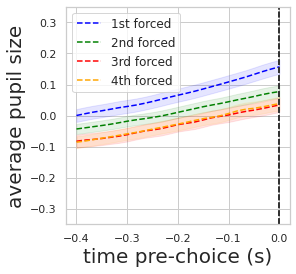

In [34]:
# pupil size for 1st to 4th forced trials

# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

#linetype = ['dotted', 'dotted', 'dotted', 'dotted']
linecolor = ['blue', 'green', 'red', 'orange']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle='dashed', color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} pre-choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time pre-choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend()
        
    

(51, 6, 25)


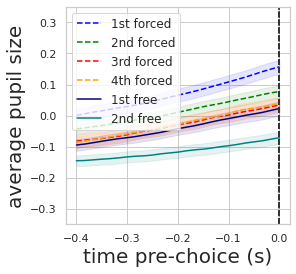

In [35]:
# pupil size for 1st to 4th forced trials

# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced', '1st free', '2nd free']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4, to_plot5, to_plot6]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid']
linecolor = ['blue', 'green', 'red', 'orange', 'navy', 'teal']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} pre-choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time pre-choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend()
        
    

(51, 5, 25)


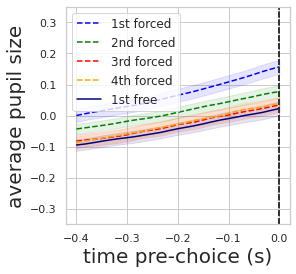

In [36]:
# pupil size for 1st to 4th forced trials

# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced', '1st free']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4, to_plot5]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['dashed', 'dashed', 'dashed', 'dashed', 'solid']
linecolor = ['blue', 'green', 'red', 'orange', 'navy']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} pre-choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time pre-choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend()
        
    

In [37]:
len(y1_or)

51

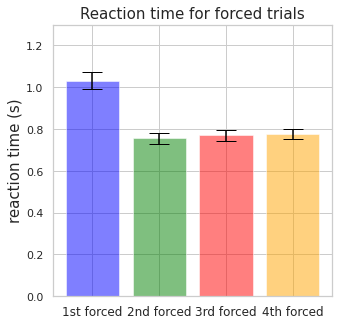

In [38]:
# find the reaction time for each group


types = ['1st forced', '2nd forced', '3rd forced', '4th forced']
metric = 'size'
event = 'pre_response'
label = 'rt'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]
    
    to_plot7 = joint_data[joint_data['trial_forced'] > 1]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    y1_list = []
    y1_se_list = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1_list.append(np.mean(y1_or,axis=0))
        #y1_se_list.append(np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))

    Y_to_plot.append(y1_list)
    
Y_to_plot = np.array(Y_to_plot)
Y_to_plot.shape  

    
y1_mean = np.mean(Y_to_plot, axis=0)

#y1_se_list = np.nanstd(y1_mean,axis=0) / np.sqrt(np.size(y1_mean, axis=0))
#y1_se_list = np.nanstd(Y_to_plot, axis=0) 
#y1_see_list = np.sqrt(np.size(y1_mean, axis=0))
y1_se_list = stats.sem(Y_to_plot,axis=0)


gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

linecolor = ['blue', 'green', 'red', 'orange']

x_pos = np.arange(len(types))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, color = linecolor)
ax.set_ylabel('reaction time (s)', fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(types, fontsize=12)
ax.set_title('Reaction time for forced trials', fontsize=15)
ax.set_ylim([0, 1.3])
ax.yaxis.grid(True)

In [39]:
Y_to_plot = np.array(Y_to_plot)
Y_to_plot.shape

(51, 4)

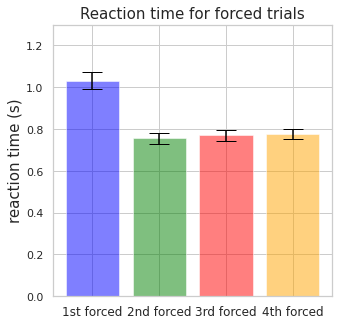

In [40]:
y1_mean = np.mean(Y_to_plot, axis=0)

#y1_se_list = np.nanstd(y1_mean,axis=0) / np.sqrt(np.size(y1_mean, axis=0))
#y1_se_list = np.nanstd(Y_to_plot, axis=0) 
#y1_see_list = np.sqrt(np.size(y1_mean, axis=0))
y1_se_list = stats.sem(Y_to_plot,axis=0)


gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

linecolor = ['blue', 'green', 'red', 'orange']

x_pos = np.arange(len(types))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, color = linecolor)
ax.set_ylabel('reaction time (s)', fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(types, fontsize=12)
ax.set_title('Reaction time for forced trials', fontsize=15)
ax.set_ylim([0, 1.3])
ax.yaxis.grid(True)

In [41]:
Y_to_plot[:,0]

array([0.71595312, 0.71378125, 0.707625  , 0.89092187, 0.79317188,
       0.7795625 , 0.83110937, 0.94421875, 1.02617188, 0.90665625,
       1.20792188, 1.05417187, 0.77332813, 1.32709375, 0.97710938,
       1.39729687, 1.11179688, 1.693125  , 0.981375  , 1.22440625,
       1.07904687, 1.55323438, 1.01335937, 1.30810937, 1.26892187,
       1.06254687, 0.89434375, 1.21042857, 0.90470312, 1.0179375 ,
       0.97023437, 0.9234375 , 1.00398437, 1.083125  , 0.76965625,
       0.93032812, 1.14115625, 0.78332813, 1.30771875, 1.20857812,
       0.83678125, 0.92701563, 0.75109375, 0.74759375, 1.13901563,
       2.26575   , 1.12154687, 0.79153125, 0.70917188, 0.87353125,
       0.92115625])

In [42]:
# paired-ttest
from scipy import stats

y11 = Y_to_plot[:,0]
y12 = Y_to_plot[:,2]

stats.ttest_rel(y11, y12)

Ttest_relResult(statistic=9.092951554935427, pvalue=3.5648081455753808e-12)

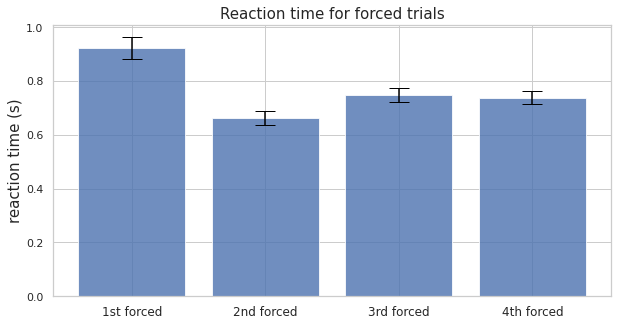

In [43]:

gridsize = (1,1)
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot2grid(gridsize, (0, 0))


x_pos = np.arange(len(types))
ax.bar(x_pos, y1_list, yerr=y1_se_list, align='center', alpha=0.8, ecolor='black', capsize=10)
ax.set_ylabel('reaction time (s)', fontsize=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(types, fontsize=12)
ax.set_title('Reaction time for forced trials', fontsize=15)
ax.yaxis.grid(True)

In [44]:
len(valid_sub)

51

In [45]:
# paired-ttest
from scipy import stats

y11 = np.array(Y[0][label].to_list())
y12 = np.array(Y[6][label].to_list())
stats.ttest_rel(y11, y12)

IndexError: list index out of range

In [46]:
y11 = np.array(Y[0][label].to_list())
y12 = np.array(Y[1][label].to_list())
y13 = np.array(Y[2][label].to_list())
y14 = np.array(Y[3][label].to_list())
y15 = np.array(Y[4][label].to_list())
y16 = np.array(Y[5][label].to_list())
y17 = np.array(Y[6][label].to_list())


print(stats.f_oneway(y11, y12, y13, y14))
print(stats.f_oneway(y15, y16))
print(stats.f_oneway(y11, y12, y13, y14, y15, y16))

IndexError: list index out of range

(51, 4, 127)


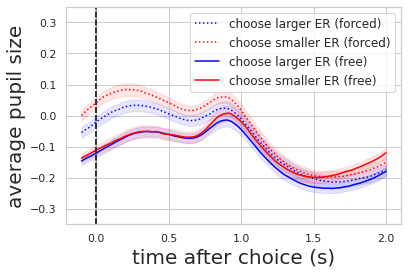

In [47]:
# plot the average for all subjects

types = ['choose larger ER (forced)', 'choose smaller ER (forced)','choose larger ER (free)', 'choose smaller ER (free)']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
#ax4.set_title(f'Pupil {metric} after choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
#ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
ax4.set_xlabel(f'time after choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend(fontsize=12)
        

(51, 4, 127)


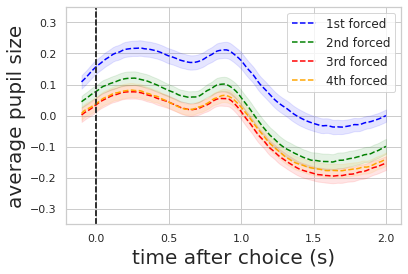

In [48]:
# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    

    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dashed', 'dashed', 'dashed', 'dashed']
linecolor = ['blue', 'green', 'red', 'orange']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
#ax4.set_title(f'Pupil {metric} after choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
#ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
ax4.set_xlabel(f'time after choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend(fontsize=12)
        

(51, 6, 127)


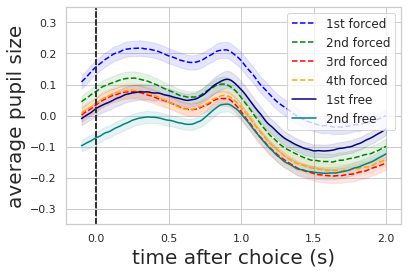

In [49]:
# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced', '1st free', '2nd free']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]


    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4, to_plot5, to_plot6]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid']
linecolor = ['blue', 'green', 'red', 'orange', 'navy', 'teal']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
#ax4.set_title(f'Pupil {metric} after choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
#ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
ax4.set_xlabel(f'time after choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend(fontsize=12)
        

(51, 5, 127)


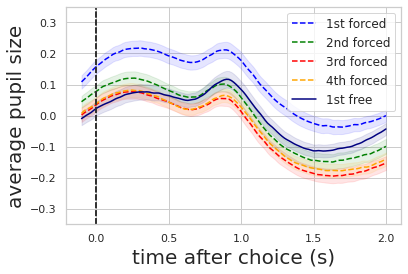

In [50]:
# plot the average for all subjects

types = ['1st forced', '2nd forced', '3rd forced', '4th forced', '1st free']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['trial_forced'] == 1]
    to_plot2 = joint_data[joint_data['trial_forced'] == 2]
    
    to_plot3 = joint_data[joint_data['trial_forced'] == 3]
    to_plot4 = joint_data[joint_data['trial_forced'] == 4]
    
    to_plot5 = joint_data_free[joint_data_free['trial_after_forced'] == 1]
    to_plot6 = joint_data_free[joint_data_free['trial_after_forced'] == 2]


    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4, to_plot5]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dashed', 'dashed', 'dashed', 'dashed', 'solid']
linecolor = ['blue', 'green', 'red', 'orange', 'navy']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.1, color=linecolor[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
#ax4.set_title(f'Pupil {metric} after choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
#ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
ax4.set_xlabel(f'time after choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend(fontsize=12)
        

(51, 2, 187)


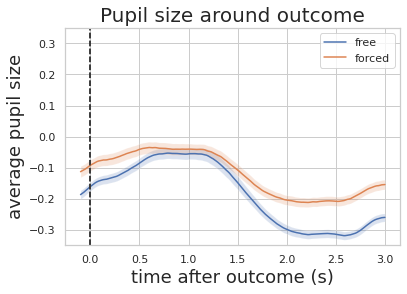

In [51]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

In [52]:
joint_data.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [53]:
joint_data[['mean_chosen' ,'ER_chosen_before', 'outcomes', 'ER_chosen_after', 'SD']]

mean_chosen  ER_chosen_before  outcomes  ER_chosen_after  SD
0             30         50.000000      58.0        54.311380  20
1             70         50.000000      79.0        63.108617  20
2             30         53.202294      10.0        35.885477  20
3             30         35.885477      12.0        32.082256  20
4             70         57.231803      83.0        66.150573  20
..           ...               ...       ...              ...  ..
763           30         30.062463      25.0        30.105769  10
764           30         39.296607      42.0        37.171941  10
765           30         37.171941      24.0        30.474735  10
766           30         39.024688      18.0        30.080527  10
767           30         35.497536       1.0        30.001936  10

[768 rows x 5 columns]

(51, 2, 187)


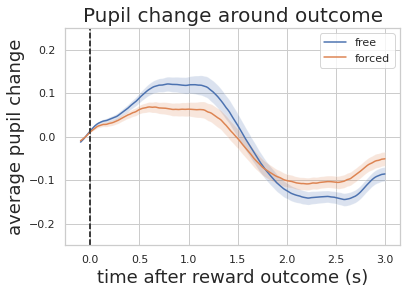

In [54]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
ax4.set_ylim([-0.25, 0.25])
ax4.legend(prop={"size":16})
plt.legend()
        

In [55]:
joint_data.keys()

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [56]:
#joint_data['outcome_change']
valid_sub_new_new = np.delete(valid_sub_new, 23)
valid_sub_new_new

array([ 1,  2,  3,  4,  6,  8, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23,
       26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

(48, 2, 187)


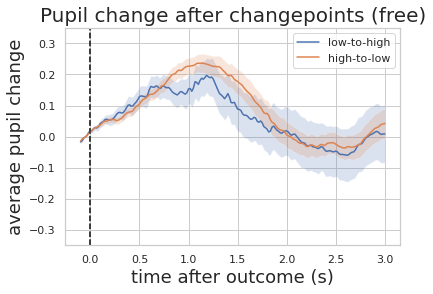

In [57]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (free)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(48, 2, 187)


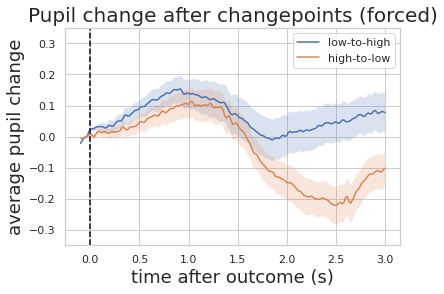

In [58]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == False]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 2, 187)


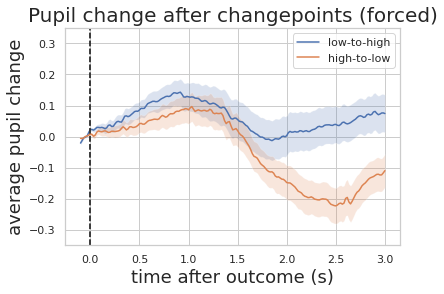

In [59]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == False]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

In [60]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

### correlating switch behavior with choice, RPE, and uncertainty

(51, 4, 187)


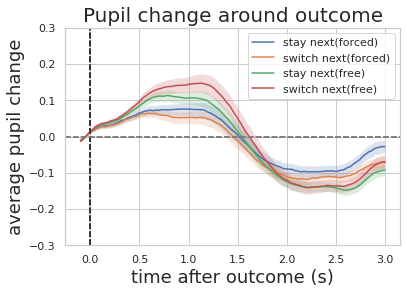

In [61]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['stay next(forced)', 'switch next(forced)','stay next(free)', 'switch next(free)']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp#[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_temp['forced'] == True)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_temp['forced'] == True)]

    to_plot2 = joint_data_new[(joint_data_new[types] == False) & (joint_data_temp['free'] == True)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_temp['free'] == True)]


    
    Y = [to_plot1, to_plot11, to_plot2, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.3, 0.3])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 4, 187)


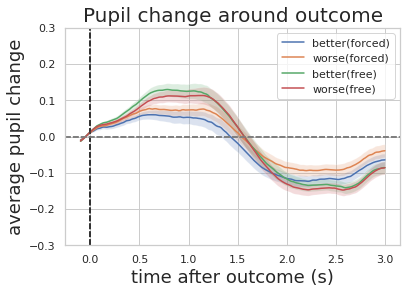

In [62]:
# plot the average for all subjects

types = 'outcome_change'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['stay next(forced)', 'switch next(forced)','stay next(free)', 'switch next(free)']
labels = ['better(forced)', 'worse(forced)','better(free)', 'worse(free)']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp#[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new[types] > 0) & (joint_data_temp['forced'] == True)]
    to_plot11 = joint_data_new[(joint_data_new[types] < 0) & (joint_data_temp['forced'] == True)]

    to_plot2 = joint_data_new[(joint_data_new[types] > 0) & (joint_data_temp['free'] == True)]
    to_plot22 = joint_data_new[(joint_data_new[types] < 0) & (joint_data_temp['free'] == True)]


    
    Y = [to_plot1, to_plot11, to_plot2, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.3, 0.3])
ax4.legend(prop={"size":16})
plt.legend()
        

In [63]:
valid_sub

array([ 1,  2,  3,  4,  6,  8, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41,
       43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [64]:
valid_sub_new = np.delete(valid_sub, [17,18]) # delete sub 24, 25
valid_sub_new

array([ 1,  2,  3,  4,  6,  8, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44,
       45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [65]:
joint_data.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [66]:
joint_data[['mean_chosen' ,'ER_chosen_before', 'outcomes', 'ER_chosen_after', 'SD', 'changepoints']]

mean_chosen  ER_chosen_before  outcomes  ER_chosen_after  SD  \
0             30         50.000000      58.0        54.311380  20   
1             70         50.000000      79.0        63.108617  20   
2             30         53.202294      10.0        35.885477  20   
3             30         35.885477      12.0        32.082256  20   
12            70         49.348712     100.0        67.293094  20   
..           ...               ...       ...              ...  ..   
747           30         33.726793      31.0        31.019908  10   
756           30         31.238508      29.0        30.366946  10   
757           30         47.991392      35.0        34.817104  10   
758           30         35.417475      33.0        31.086172  10   
759           30         31.086172      28.0        30.285926  10   

     changepoints  
0           False  
1           False  
2           False  
3           False  
12          False  
..            ...  
747         False  
756         False  
757         False  
758         False  
759         False  

[256 rows x 6 columns]

(48, 3, 187)


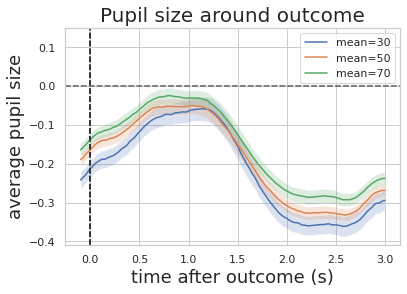

In [67]:
# plot the average for all subjects

types = 'mean_chosen'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['mean=30', 'mean=50', 'mean=70']
#labels = ['better(forced)', 'worse(forced)','better(free)', 'worse(free)']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new[types] == 30) & (joint_data_new['changepoints'] == False)]
    to_plot11 = joint_data_new[(joint_data_new[types] == 50) & (joint_data_new['changepoints'] == False)]

    to_plot2 = joint_data_new[(joint_data_new[types] == 70) & (joint_data_new['changepoints'] == False)]
    #to_plot22 = joint_data_new[(joint_data_new[types] < 0) & (joint_data_temp['free'] == True)]


    
    Y = [to_plot1, to_plot11, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.41, 0.15])
ax4.legend(prop={"size":16})
plt.legend()
        

(48, 3, 187)


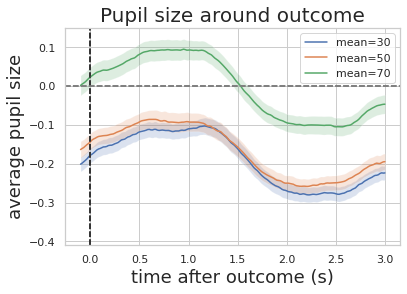

In [68]:
# plot the average for all subjects

types = 'mean_chosen'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['mean=30', 'mean=50', 'mean=70']
#labels = ['better(forced)', 'worse(forced)','better(free)', 'worse(free)']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['forced'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new[types] == 30) & (joint_data_new['changepoints'] == False)]
    to_plot11 = joint_data_new[(joint_data_new[types] == 50) & (joint_data_new['changepoints'] == False)]

    to_plot2 = joint_data_new[(joint_data_new[types] == 70) & (joint_data_new['changepoints'] == False)]
    #to_plot22 = joint_data_new[(joint_data_new[types] < 0) & (joint_data_temp['free'] == True)]


    
    Y = [to_plot1, to_plot11, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.41, 0.15])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 4, 187)
[-1.35834119e-02 -9.66855680e-03 -5.40464711e-03 -8.50605678e-04
  4.34696824e-03  1.01987729e-02  1.49614803e-02  1.88774234e-02
  2.35748021e-02  2.77770672e-02  3.02244832e-02  3.25407673e-02
  3.52566104e-02  3.65966744e-02  3.64998255e-02  3.69981106e-02
  3.88971759e-02  4.11926870e-02  4.28851519e-02  4.42168083e-02
  4.57282790e-02  4.69902710e-02  4.85642270e-02  5.16558164e-02
  5.48557917e-02  5.71162286e-02  5.97743697e-02  6.25073730e-02
  6.51041901e-02  6.93401166e-02  7.39538660e-02  7.66493130e-02
  7.92357156e-02  8.33392767e-02  8.76999039e-02  9.16291152e-02
  9.56797475e-02  1.00402852e-01  1.05292149e-01  1.09157606e-01
  1.12463231e-01  1.16024623e-01  1.19331392e-01  1.22512926e-01
  1.25723181e-01  1.28296579e-01  1.30552429e-01  1.33043799e-01
  1.35417449e-01  1.37275510e-01  1.38720448e-01  1.40458863e-01
  1.42669287e-01  1.44478144e-01  1.45600386e-01  1.46533166e-01
  1.47644530e-01  1.49121022e-01  1.50682988e-01  1.51826732e-01
  1.52449827

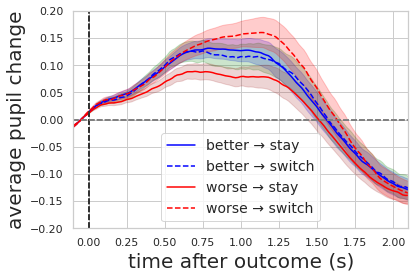

In [69]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
print(y1)

(49, 4, 187)
[-0.01406013 -0.00981895 -0.00539116 -0.00089804  0.00433161  0.01042479
  0.01541188  0.01945831  0.02434126  0.02876673  0.03137472  0.03388939
  0.03684692  0.0382821   0.03816662  0.03865346  0.04058111  0.04311228
  0.04513441  0.0465503   0.04812448  0.0495621   0.05106607  0.05415947
  0.05783476  0.06041032  0.06301159  0.06594341  0.06886794  0.07315877
  0.07789258  0.08088967  0.08366415  0.08794727  0.09261258  0.09679521
  0.10098479  0.10584454  0.11105689  0.11537304  0.11878756  0.12222744
  0.12579762  0.12926547  0.13226867  0.13473906  0.13725536  0.13990168
  0.14241023  0.144501    0.1460103   0.14777218  0.15015837  0.15217464
  0.15343884  0.15435513  0.15529766  0.15663239  0.15824138  0.15965679
  0.16050817  0.16080973  0.16114473  0.16172223  0.16245316  0.16371503
  0.16526348  0.16630086  0.16682512  0.16719165  0.16762932  0.1682848
  0.16891551  0.16934744  0.16962791  0.16930392  0.16806117  0.16660736
  0.16543338  0.16386546  0.16107932  0

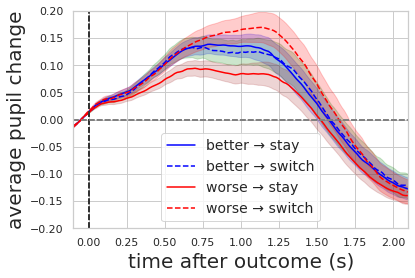

In [70]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
print(y1)

(51, 4, 187)


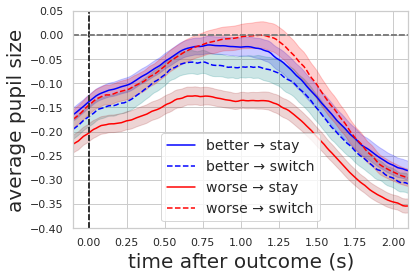

In [71]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'teal', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.4, 0.05])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(49, 4, 187)


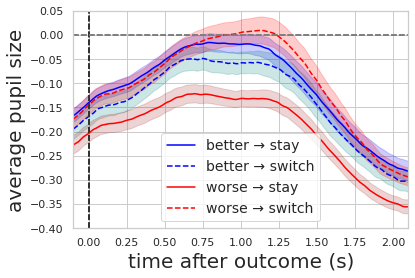

In [72]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'teal', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.4, 0.05])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

In [73]:
num_lines

4

In [74]:
joint_data_new.columns 
# relevant column names: 
# pupil (current trial): 
#- 'pupil_size_pre_response', 'pupil_size_avg_pre_response'
#- 'pupil_size_response','pupil_size_avg_response'

# pupil (prev trial):
#- all things related to outcome
# behavioral: choices_new (0 or 1), mean_chosen, mean_unchosen,  ER_diff_before (>0), EU_diff_before, UU_diff_before
# ***better check how diff_before was calculated

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [75]:
# test
test_arr = np.array([1,2,3])
test_arr = np.insert(test_arr, -1, 10)
[test_arr[i+1] for i in range(len(test_arr)-1)]

[2, 10, 3]

In [76]:
holder_arr = joint_data_new['pupil_size_avg_outcome'].to_numpy()
holder_arr = np.insert(holder_arr, 0, 0)[:-1]
print(len(joint_data_new['pupil_size_avg_outcome'].to_numpy()))
print(len(holder_arr))
print(holder_arr)

512
512
[ 0.00000000e+00  1.43798055e+00  3.00452432e-01  6.43145113e-01
  5.51386874e-01  2.08526596e-01  5.66116912e-01  4.41847508e-01
  1.25237678e+00  1.31529560e+00  1.14355537e+00  1.62274218e+00
  8.25195243e-01  1.39315035e+00  9.22304020e-01  1.75331920e+00
  1.46001383e+00  5.48133949e-01  2.41618129e-01  6.37112508e-01
  4.00426879e-01 -5.90732835e-01  3.12202108e-02  2.45067993e-01
 -4.89423800e-02 -5.48333836e-01 -7.10585354e-01 -6.93783264e-01
 -6.68289121e-01 -9.16399976e-01 -8.39465550e-01 -1.14403707e+00
 -1.03118529e+00 -9.65546125e-01 -6.52010513e-01 -1.08653355e+00
 -7.73808966e-01 -5.55559991e-01 -2.19644259e-01 -9.09351591e-01
 -1.16790148e+00 -1.61720623e+00 -1.39608809e+00 -1.26679740e+00
 -1.22978973e+00 -4.64153965e-01 -1.28575195e+00 -9.58436655e-01
 -5.23721523e-01 -2.35874799e-01 -8.05975232e-01 -1.83110343e-01
 -2.33880299e-01  7.85575643e-02 -7.34710348e-01 -7.40989709e-01
 -4.16570074e-01  1.24903068e+00  7.30104395e-01  1.71776943e-01
  3.63017494e-01 

In [77]:
joint_data_new

level_0  index  trial     rt  \
4          4      4      4  0.886   
5          5      5      5  0.524   
6          6      6      6  0.534   
7          7      7      7  0.781   
8          8      8      8  1.291   
..       ...    ...    ...    ...   
763       91     91     91  1.142   
764       92     92     92  0.316   
765       93     93     93  0.412   
766       94     94     94  0.319   
767       95     95     95  0.325   

                                  pupil_baseline_start  \
4    [0.2329468694457934, 0.2195645528616627, 0.246...   
5    [1.604212964386441, 1.6285303725867817, 1.6628...   
6    [-0.6259594067889568, -0.580431477955717, -0.5...   
7    [0.9413728981995821, 0.8963505792510152, 0.860...   
8    [0.5843384851342176, 0.5273335215865524, 0.478...   
..                                                 ...   
763  [0.67943674845904, 0.7272363341078137, 0.73705...   
764  [-0.17780774209706132, -0.13794868236501812, -...   
765  [-1.203478368664157, -1.1643138433366318, -1.1...   
766  [-1.6546526797253853, -1.6049083492062692, -1....   
767  [0.5476487169455556, 0.40803424555855716, 0.35...   

                                pupil_baseline_outcome  \
4    [1.7544874871463856, 1.7720780239957616, 1.805...   
5    [0.7685031736132147, 0.8136426641189665, 0.859...   
6    [0.2999592623031137, 0.26569563391781836, 0.30...   
7    [-0.398104164104001, -0.37839306728714694, -0....   
8    [-0.205693408226777, -0.2218313300040943, -0.2...   
..                                                 ...   
763  [0.5511960490811909, 0.5499120983188762, 0.581...   
764  [-0.8800874249291134, -0.863458312754363, -0.8...   
765  [-3.327919441521653, -3.3458417071503943, -3.3...   
766  [-0.23448572896024178, -0.11422985799373579, -...   
767  [-0.6308113880375159, -0.6443178855941037, -0....   

                               pupil_size_pre_response  \
4    [0.8322483658106244, 0.8368113607088992, 0.775...   
5    [1.6519808448121482, 1.6435078302662, 1.651376...   
6    [-0.02224315815839232, -0.04403337339354349, -...   
7    [0.4901778384479871, 0.5030240859159255, 0.560...   
8    [0.5114205969271836, 0.5018882640692223, 0.536...   
..                                                 ...   
763  [1.0707077050777225, 1.0654853260524422, 1.070...   
764  [-0.14873885096615147, -0.11531997069426185, -...   
765  [-1.1940200358695918, -1.1961699578124045, -1....   
766  [-1.558495613955596, -1.5328490750914376, -1.4...   
767  [0.41406870553831127, 0.3766595113669954, 0.35...   

     pupil_size_avg_pre_response  \
4                       0.847741   
5                       1.751446   
6                       0.359808   
7                       0.872949   
8                       0.247190   
..                           ...   
763                     1.213163   
764                     0.221271   
765                    -1.551658   
766                    -1.222526   
767                     0.228686   

                                   pupil_size_response  \
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
5    [1.7937574818611532, 1.7857466174736965, 1.757...   
6    [0.581052140277717, 0.6451061668589583, 0.6861...   
7    [1.0477415953915061, 1.065030901711759, 1.0884...   
8    [0.05178672665339497, 0.03727946032023733, -0....   
..                                                 ...   
763  [1.3801842435307121, 1.323949527624748, 1.1854...   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   
765  [-1.7172245184480575, -1.7368905531884036, -1....   
766  [-1.106845834894351, -1.1308387794174326, -1.1...   
767  [0.11716046275001123, 0.10990970946557645, 0.1...   

     pupil_size_avg_response  ... UU_diff_after  switch  switch_next  \
4                   1.237052  ...     -0.035290    True        False   
5                   1.382578  ...     -0.153870   False        False   
6                   0.913374  ...     -0.246080   False        False   
7                   0.338019  ...     -0.245045   F

In [78]:
joint_data_new['trial'].to_numpy()

array([[ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       ...,
       [93, 93, 93],
       [94, 94, 94],
       [95, 95, 95]])

In [79]:
joint_data_new = joint_data_by_sub[f'sub1']

joint_data_new['prev_pupil_size_avg_outcome'] = np.insert(joint_data_new['pupil_size_avg_outcome'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome'] = np.insert(joint_data_new['pupil_change_avg_outcome'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome1'] = np.insert(joint_data_new['pupil_change_avg_outcome1'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome2'] = np.insert(joint_data_new['pupil_change_avg_outcome2'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome3'] = np.insert(joint_data_new['pupil_change_avg_outcome3'].to_numpy(), 0, 0)[:-1]

joint_data_new['mean_diff'] = joint_data_new['mean_chosen'].to_numpy() - joint_data_new['mean_unchosen'].to_numpy()
#joint_data_new['trial_int'] = joint_data_new['trial'].to_numpy().astype(int)
# next step: find the FREE, TRIAL > 0, (also exclude the first free?)
joint_data_use = joint_data_new[(joint_data_new['free'] == True) & (joint_data_new['index'] > 0)]



In [80]:
keys_to_include_ind = [#'rt', 
       'pupil_size_avg_pre_response', 
       'pupil_size_avg_response',
       'prev_pupil_size_avg_outcome', 
                       
       'pupil_change_avg_pre_response', 
       'pupil_change_avg_response', 
                       
       'prev_pupil_change_avg_outcome', 
        'prev_pupil_change_avg_outcome1',
       'prev_pupil_change_avg_outcome2', 
       'prev_pupil_change_avg_outcome3', 
                       
       'choices_new','mean_chosen', 'mean_unchosen', 'mean_diff','SD', 
         'ER_chosen_before', 
       'EU_chosen_before', 'UU_chosen_before',
       
                       'ER_sum_before', 'EU_sum_before', 'UU_sum_before', 
                       'ER_diff_before', 'EU_diff_before', 'UU_diff_before',
       'switch', 
       'trial_after_forced', 'trial_after_cp']
df = joint_data_new[keys_to_include_ind]

from scipy.stats import pearsonr

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p



pupil_size_avg_pre_response  \
pupil_size_avg_pre_response                         1.0***   
pupil_size_avg_response                            0.78***   
prev_pupil_size_avg_outcome                        0.65***   
pupil_change_avg_pre_response                      0.29***   
pupil_change_avg_response                         -0.28***   
prev_pupil_change_avg_outcome                      0.28***   
prev_pupil_change_avg_outcome1                    -0.29***   
prev_pupil_change_avg_outcome2                    -0.16***   
prev_pupil_change_avg_outcome3                     0.18***   
choices_new                                          -0.05   
mean_chosen                                           0.03   
mean_unchosen                                         0.02   
mean_diff                                             0.01   
SD                                                 0.15***   
ER_chosen_before                                     -0.03   
EU_chosen_before                                    0.11**   
UU_chosen_before                                      0.01   
ER_sum_before                                        -0.03   
EU_sum_before                                        0.09*   
UU_sum_before                                         0.02   
ER_diff_before                                       -0.01   
EU_diff_before                                        0.07   
UU_diff_before                                        -0.0   
switch                                                0.03   
trial_after_forced                                 -0.09**   
trial_after_cp                                    -0.21***   

                               pupil_size_avg_response  \
pupil_size_avg_pre_response                    0.78***   
pupil_size_avg_response                         1.0***   
prev_pupil_size_avg_outcome                    0.55***   
pupil_change_avg_pre_response                  0.19***   
pupil_change_avg_response                      0.24***   
prev_pupil_change_avg_outcome                   0.2***   
prev_pupil_change_avg_outcome1                -0.27***   
prev_pupil_change_avg_outcome2                -0.16***   
prev_pupil_change_avg_outcome3                 0.14***   
choices_new                                      -0.02   
mean_chosen                                       0.03   
mean_unchosen                                     0.02   
mean_diff                                         0.01   
SD                                             0.17***   
ER_chosen_before                                  -0.0   
EU_chosen_before                               0.13***   
UU_chosen_before                                  -0.0   
ER_sum_before                                     -0.0   
EU_sum_before                                  0.16***   
UU_sum_before                                     0.02   
ER_diff_before                                    -0.0   
EU_diff_before                                    0.03   
UU_diff_before                                   -0.02   
switch                                             0.0   
trial_after_forced                               -0.05   
trial_after_cp                                -0.25***   

                               prev_pupil_size_avg_outcome  \
pupil_size_avg_pre_response                        0.65***   
pupil_size_avg_response                            0.55***   
prev_pupil_size_avg_outcome                         1.0***   
pupil_change_avg_pre_response                      -0.11**   
pupil_change_avg_response                         -0.32***   
prev_pupil_change_avg_outcome                      0.14***   
prev_pupil_change_avg_outcome1                    -0.61***   
prev_pupil_change_avg_outcome2                    -0.42***   
prev_pupil_change_avg_outcome3                     0.16***   
choices_new                                          -0.03   
mean_chosen                                           0.03   
mean_unchosen                                

In [81]:
corr_coef_list = pd.DataFrame()
p_val_list = pd.DataFrame()

c = 0
for sub in valid_sub-1:
    
    joint_data_new = joint_data_by_sub[f'sub{sub+1}']

    joint_data_new['prev_pupil_size_avg_outcome'] = np.insert(joint_data_new['pupil_size_avg_outcome'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome'] = np.insert(joint_data_new['pupil_change_avg_outcome'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome1'] = np.insert(joint_data_new['pupil_change_avg_outcome1'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome2'] = np.insert(joint_data_new['pupil_change_avg_outcome2'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome3'] = np.insert(joint_data_new['pupil_change_avg_outcome3'].to_numpy(), 0, 0)[:-1]

    joint_data_new['mean_diff'] = joint_data_new['mean_chosen'].to_numpy() - joint_data_new['mean_unchosen'].to_numpy()
    #joint_data_new['trial_int'] = joint_data_new['trial'].to_numpy().astype(int)
    # next step: find the FREE, TRIAL > 0, (also exclude the first free?)
    joint_data_use = joint_data_new[(joint_data_new['free'] == True) & (joint_data_new['index'] > 0)]


    df = joint_data_new[keys_to_include_ind]


    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    rho_p = rho.round(2).astype(str) + p
    
    
    corr_coef_list = pd.concat([corr_coef_list, rho], axis=1)
    p_val_list = pd.concat([p_val_list, pval], axis=1)


    
    #rt_list[f'sub{sub+1}'] = rho[key_to_plot]
    #pval_list[f'sub{sub+1}'] = pval[key_to_plot]

In [82]:
corr_coef_comb = corr_coef_list.groupby(level=0).mean()
corr_coef_comb

pupil_size_avg_pre_response  \
ER_chosen_before                                  -0.027230   
ER_diff_before                                    -0.008682   
ER_sum_before                                     -0.029357   
EU_chosen_before                                   0.106894   
EU_diff_before                                     0.066604   
EU_sum_before                                      0.087117   
SD                                                 0.149413   
UU_chosen_before                                   0.011025   
UU_diff_before                                    -0.003195   
UU_sum_before                                      0.019022   
choices_new                                       -0.053577   
mean_chosen                                        0.032368   
mean_diff                                          0.013005   
mean_unchosen                                      0.016245   
prev_pupil_change_avg_outcome                      0.275144   
prev_pupil_change_avg_outcome1                    -0.286125   
prev_pupil_change_avg_outcome2                    -0.156440   
prev_pupil_change_avg_outcome3                     0.184995   
prev_pupil_size_avg_outcome                        0.647330   
pupil_change_avg_pre_response                      0.291846   
pupil_change_avg_response                         -0.277863   
pupil_size_avg_pre_response                        1.000000   
pupil_size_avg_response                            0.778675   
switch                                             0.027521   
trial_after_cp                                    -0.205269   
trial_after_forced                                -0.093683   

                                pupil_size_avg_response  \
ER_chosen_before                              -0.003575   
ER_diff_before                                -0.000224   
ER_sum_before                                 -0.004620   
EU_chosen_before                               0.130252   
EU_diff_before                                 0.031053   
EU_sum_before                                  0.161205   
SD                                             0.166419   
UU_chosen_before                              -0.001095   
UU_diff_before                                -0.024840   
UU_sum_before                                  0.024556   
choices_new                                   -0.016182   
mean_chosen                                    0.030494   
mean_diff                                      0.010536   
mean_unchosen                                  0.017583   
prev_pupil_change_avg_outcome                  0.203425   
prev_pupil_change_avg_outcome1                -0.266688   
prev_pupil_change_avg_outcome2                -0.155883   
prev_pupil_change_avg_outcome3                 0.144319   
prev_pupil_size_avg_outcome                    0.550554   
pupil_change_avg_pre_response                  0.189711   
pupil_change_avg_response                      0.238312   
pupil_size_avg_pre_response                    0.778675   
pupil_size_avg_response                        1.000000   
switch                                         0.002688   
trial_after_cp                                -0.253628   
trial_after_forced                            -0.046851   

                                prev_pupil_size_avg_outcome  \
ER_chosen_before                                   0.007366   
ER_diff_before                                     0.048525   
ER_sum_before                                     -0.030647   
EU_chosen_before                                   0.100094   
EU_diff_before                                     0.039690   
EU_sum_before                                      0.106491   
SD                                                 0.165154   
UU_chosen_before                                   0.017841   
UU_diff_before                                    -0.025301   
UU_sum_before                                      0.051945   
choices_new                                

In [83]:
p_val_comb = p_val_list.groupby(level=0).mean()
p_val_comb

pupil_size_avg_pre_response  \
ER_chosen_before                               4.511363e-01   
ER_diff_before                                 8.101639e-01   
ER_sum_before                                  4.165484e-01   
EU_chosen_before                               3.016978e-03   
EU_diff_before                                 6.506103e-02   
EU_sum_before                                  1.573842e-02   
SD                                             3.220631e-05   
UU_chosen_before                               7.603232e-01   
UU_diff_before                                 9.295614e-01   
UU_sum_before                                  5.986413e-01   
choices_new                                    1.379604e-01   
mean_chosen                                    3.703754e-01   
mean_diff                                      7.189668e-01   
mean_unchosen                                  6.530736e-01   
prev_pupil_change_avg_outcome                  8.300903e-15   
prev_pupil_change_avg_outcome1                 6.162550e-16   
prev_pupil_change_avg_outcome2                 1.329570e-05   
prev_pupil_change_avg_outcome3                 2.430050e-07   
prev_pupil_size_avg_outcome                    2.074328e-92   
pupil_change_avg_pre_response                  1.518015e-16   
pupil_change_avg_response                      4.406657e-15   
pupil_size_avg_pre_response                    0.000000e+00   
pupil_size_avg_response                       3.173146e-157   
switch                                         4.463057e-01   
trial_after_cp                                 9.436471e-09   
trial_after_forced                             9.385194e-03   

                                pupil_size_avg_response  \
ER_chosen_before                           9.212054e-01   
ER_diff_before                             9.950539e-01   
ER_sum_before                              8.982914e-01   
EU_chosen_before                           2.955207e-04   
EU_diff_before                             3.901428e-01   
EU_sum_before                              7.136991e-06   
SD                                         3.538711e-06   
UU_chosen_before                           9.758228e-01   
UU_diff_before                             4.918521e-01   
UU_sum_before                              4.968123e-01   
choices_new                                6.543292e-01   
mean_chosen                                3.987342e-01   
mean_diff                                  7.706589e-01   
mean_unchosen                              6.265930e-01   
prev_pupil_change_avg_outcome              1.286352e-08   
prev_pupil_change_avg_outcome1             5.684489e-14   
prev_pupil_change_avg_outcome2             1.428262e-05   
prev_pupil_change_avg_outcome3             5.969590e-05   
prev_pupil_size_avg_outcome                4.462475e-62   
pupil_change_avg_pre_response              1.176963e-07   
pupil_change_avg_response                  2.229392e-11   
pupil_size_avg_pre_response               3.173146e-157   
pupil_size_avg_response                    0.000000e+00   
switch                                     9.407073e-01   
trial_after_cp                             9.729697e-13   
trial_after_forced                         1.946425e-01   

                                prev_pupil_size_avg_outcome  \
ER_chosen_before                               8.385167e-01   
ER_diff_before                                 1.791560e-01   
ER_sum_before                                  3.963649e-01   
EU_chosen_before                               5.497502e-03   
EU_diff_before                                 2.719597e-01   
EU_sum_before                                  3.129086e-03   
SD                                             4.203303e-06   
UU_chosen_before                               6.215427e-01   
UU_diff_before                                 4.838368e-01   
UU_sum_before                                  1.503875e-01   
choices_new                                

In [84]:
p_val_comb_temp = p_val_comb.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
corr_coef_comb.round(2).astype(str) + p_val_comb_temp

pupil_size_avg_pre_response  \
ER_chosen_before                                     -0.03   
ER_diff_before                                       -0.01   
ER_sum_before                                        -0.03   
EU_chosen_before                                    0.11**   
EU_diff_before                                        0.07   
EU_sum_before                                        0.09*   
SD                                                 0.15***   
UU_chosen_before                                      0.01   
UU_diff_before                                        -0.0   
UU_sum_before                                         0.02   
choices_new                                          -0.05   
mean_chosen                                           0.03   
mean_diff                                             0.01   
mean_unchosen                                         0.02   
prev_pupil_change_avg_outcome                      0.28***   
prev_pupil_change_avg_outcome1                    -0.29***   
prev_pupil_change_avg_outcome2                    -0.16***   
prev_pupil_change_avg_outcome3                     0.18***   
prev_pupil_size_avg_outcome                        0.65***   
pupil_change_avg_pre_response                      0.29***   
pupil_change_avg_response                         -0.28***   
pupil_size_avg_pre_response                         1.0***   
pupil_size_avg_response                            0.78***   
switch                                                0.03   
trial_after_cp                                    -0.21***   
trial_after_forced                                 -0.09**   

                               pupil_size_avg_response  \
ER_chosen_before                                  -0.0   
ER_diff_before                                    -0.0   
ER_sum_before                                     -0.0   
EU_chosen_before                               0.13***   
EU_diff_before                                    0.03   
EU_sum_before                                  0.16***   
SD                                             0.17***   
UU_chosen_before                                  -0.0   
UU_diff_before                                   -0.02   
UU_sum_before                                     0.02   
choices_new                                      -0.02   
mean_chosen                                       0.03   
mean_diff                                         0.01   
mean_unchosen                                     0.02   
prev_pupil_change_avg_outcome                   0.2***   
prev_pupil_change_avg_outcome1                -0.27***   
prev_pupil_change_avg_outcome2                -0.16***   
prev_pupil_change_avg_outcome3                 0.14***   
prev_pupil_size_avg_outcome                    0.55***   
pupil_change_avg_pre_response                  0.19***   
pupil_change_avg_response                      0.24***   
pupil_size_avg_pre_response                    0.78***   
pupil_size_avg_response                         1.0***   
switch                                             0.0   
trial_after_cp                                -0.25***   
trial_after_forced                               -0.05   

                               prev_pupil_size_avg_outcome  \
ER_chosen_before                                      0.01   
ER_diff_before                                        0.05   
ER_sum_before                                        -0.03   
EU_chosen_before                                     0.1**   
EU_diff_before                                        0.04   
EU_sum_before                                       0.11**   
SD                                                 0.17***   
UU_chosen_before                                      0.02   
UU_diff_before                                       -0.03   
UU_sum_before                                         0.05   
choices_new                                          -0.03   
mean_chosen                                  

In [85]:
Y_to_plot.shape # num_sub, num_lines, num_timepoints
# step one: for each group (of 4), and each sub, find the average according to the required timepoints

(49, 4, 187)

In [86]:
t_needed = (x >= 0.5) & (x <= 1.5)
t_needed

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [87]:
yyy_1 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_2 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_3 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_4 = np.mean(Y_to_plot[:,0,t_needed],axis=1)

In [88]:
Y_to_plot[28,0,t_needed]

array([ 0.00754291,  0.01354732,  0.02000858,  0.02533609,  0.02845888,
        0.03596208,  0.04540061,  0.05241161,  0.05653627,  0.05640731,
        0.05771695,  0.06278944,  0.06317024,  0.06112429,  0.06409158,
        0.0666588 ,  0.06595908,  0.06793344,  0.07217959,  0.07222163,
        0.06828385,  0.06862118,  0.07355084,  0.07292096,  0.06645854,
        0.06423946,  0.06785716,  0.06901852,  0.06301668,  0.05552838,
        0.05379698,  0.05570654,  0.05396408,  0.04750488,  0.04252425,
        0.04299961,  0.0450006 ,  0.04150766,  0.03515917,  0.03774725,
        0.04382625,  0.03530861,  0.02242088,  0.02494352,  0.02948199,
        0.02148114,  0.01277013,  0.00879001,  0.00046475, -0.01265163,
       -0.02273961, -0.02624861, -0.02651223, -0.02885199, -0.03423632,
       -0.03966837, -0.04339429, -0.04664566, -0.05159438, -0.05706788])

In [89]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [90]:
joint_data_temp[['pupil_size_response', 'pupil_size_avg_response']]

pupil_size_response  \
0    [1.1884758345129462, 1.1722194968436488, 1.195...   
1    [0.49289570133733357, 0.5141890876747841, 0.56...   
2    [0.4956462720515597, 0.4535649306316723, 0.427...   
3    [1.3851556862149352, 1.388967864655642, 1.3178...   
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
..                                                 ...   
763  [1.3801842435307121, 1.323949527624748, 1.1854...   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   
765  [-1.7172245184480575, -1.7368905531884036, -1....   
766  [-1.106845834894351, -1.1308387794174326, -1.1...   
767  [0.11716046275001123, 0.10990970946557645, 0.1...   

     pupil_size_avg_response  
0                   1.232890  
1                   0.340092  
2                  -0.219130  
3                   0.612900  
4                   1.237052  
..                       ...  
763                 0.497171  
764                 0.406316  
765                -2.623501  
766                -0.842620  
767                 0.439222  

[768 rows x 2 columns]

In [91]:
np.mean(np.array(joint_data_temp['pupil_size_response'][0]))

1.2328904319142908

(51, 4, 187)


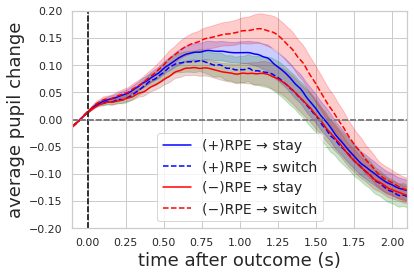

In [92]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

In [93]:
valid_sub_new_new = np.delete(valid_sub_new, 23)
valid_sub_new_new

array([ 1,  2,  3,  4,  6,  8, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23,
       26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

(49, 4, 187)


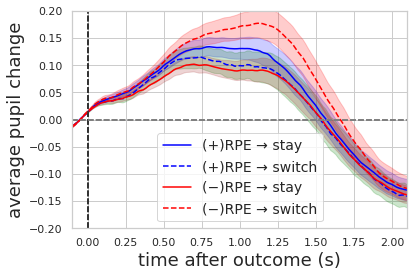

In [94]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(48, 4, 187)


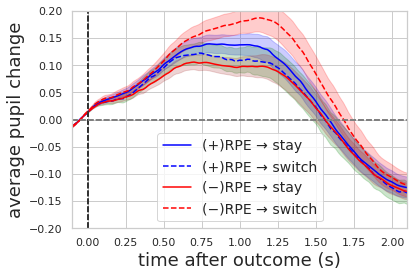

In [95]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

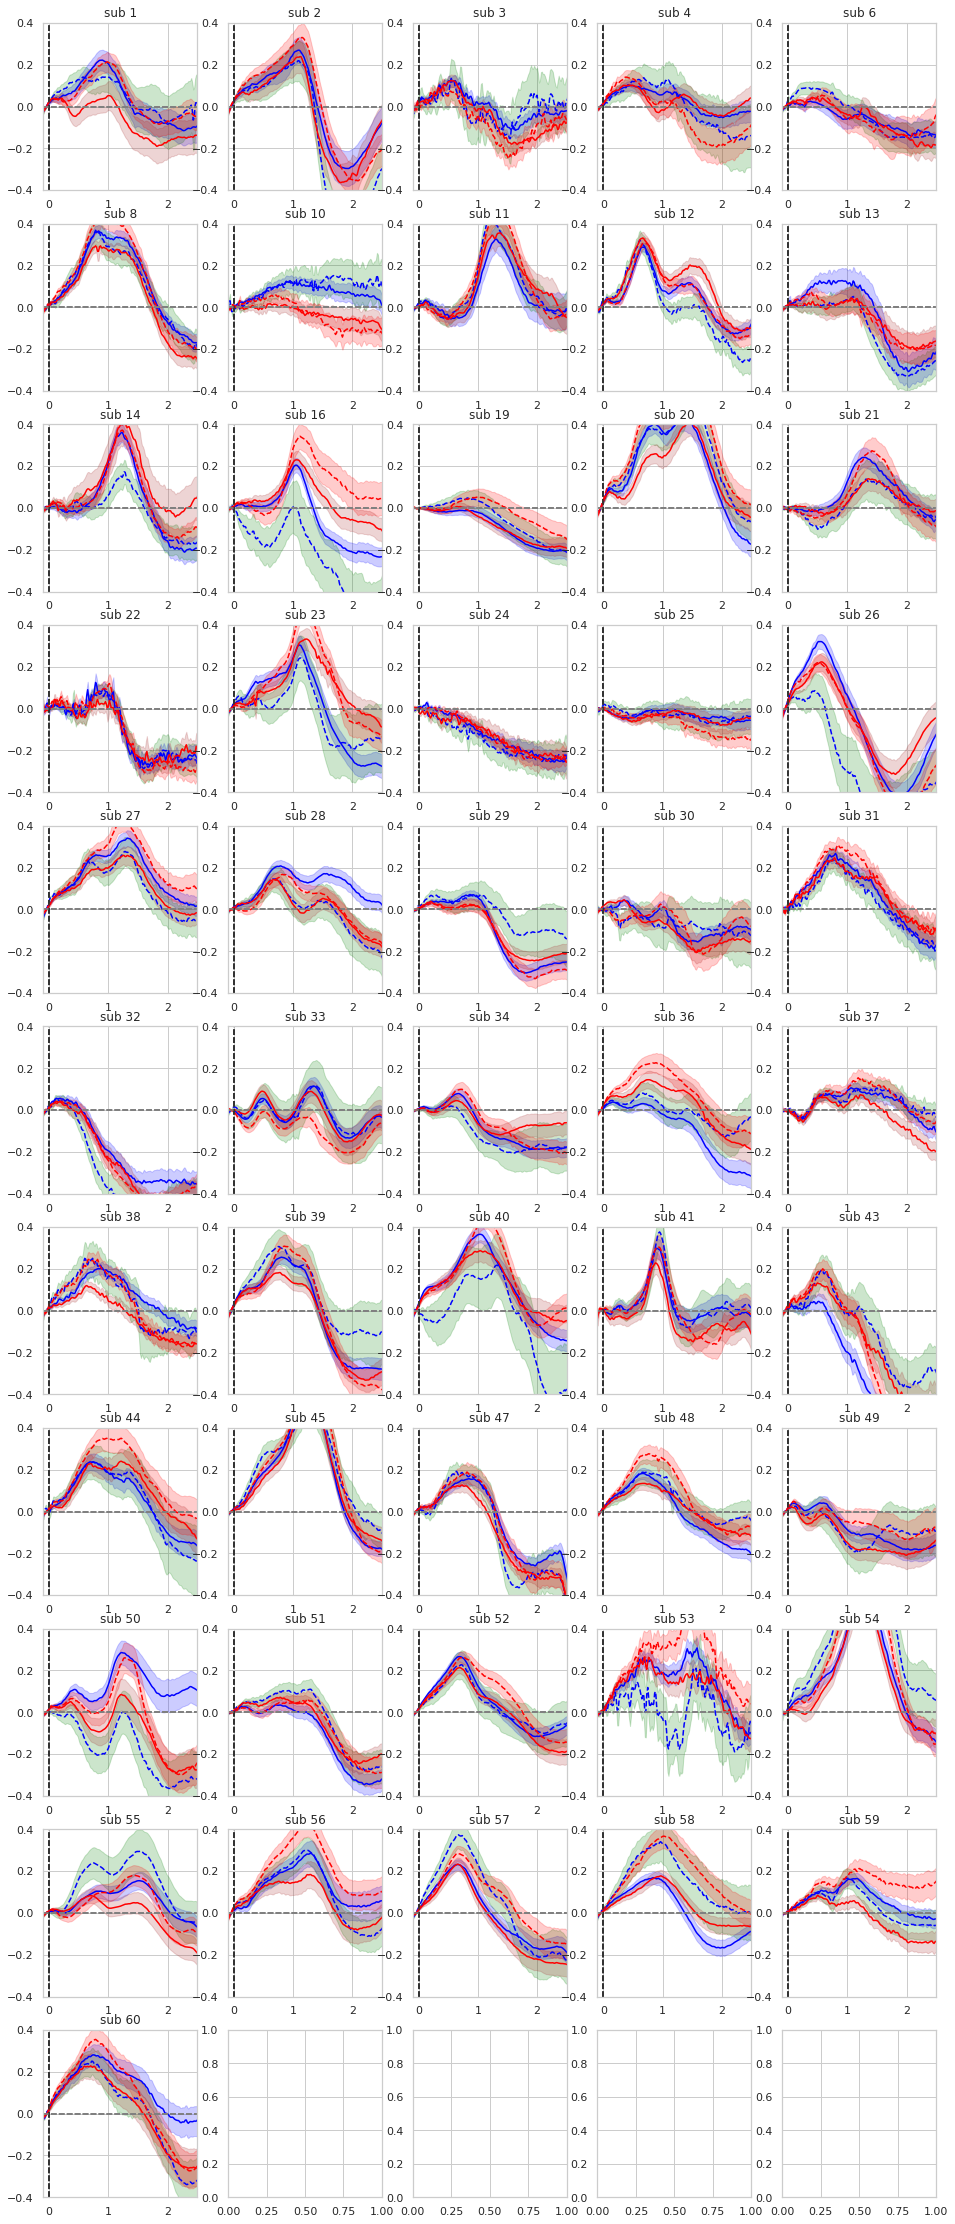

In [96]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
iii = 1

nrows=11
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 40))

#num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


count = 0
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    

    
    
    
    
    # for each subject, plot a separate average pupil response figure
    

        #y1_or = Y_to_plot[:,i,:]

        y1 = np.nanmean(y1_or,axis=0)
        y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        axs[count//ncols, count%ncols].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
        axs[count//ncols, count%ncols].axvline(x=0,color=".2", linestyle="--")
        axs[count//ncols, count%ncols].axhline(y=0,color="grey", linestyle="--")

        axs[count//ncols, count%ncols].fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])
        axs[count//ncols, count%ncols].set_xlim([-0.1, 2.5])
        axs[count//ncols, count%ncols].set_ylim([-0.4, 0.4])
        axs[count//ncols, count%ncols].set_title(f'sub {sub+1}')



    #axs[count].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    count = count+1
    
    Y_to_plot.append(Y_all)

 

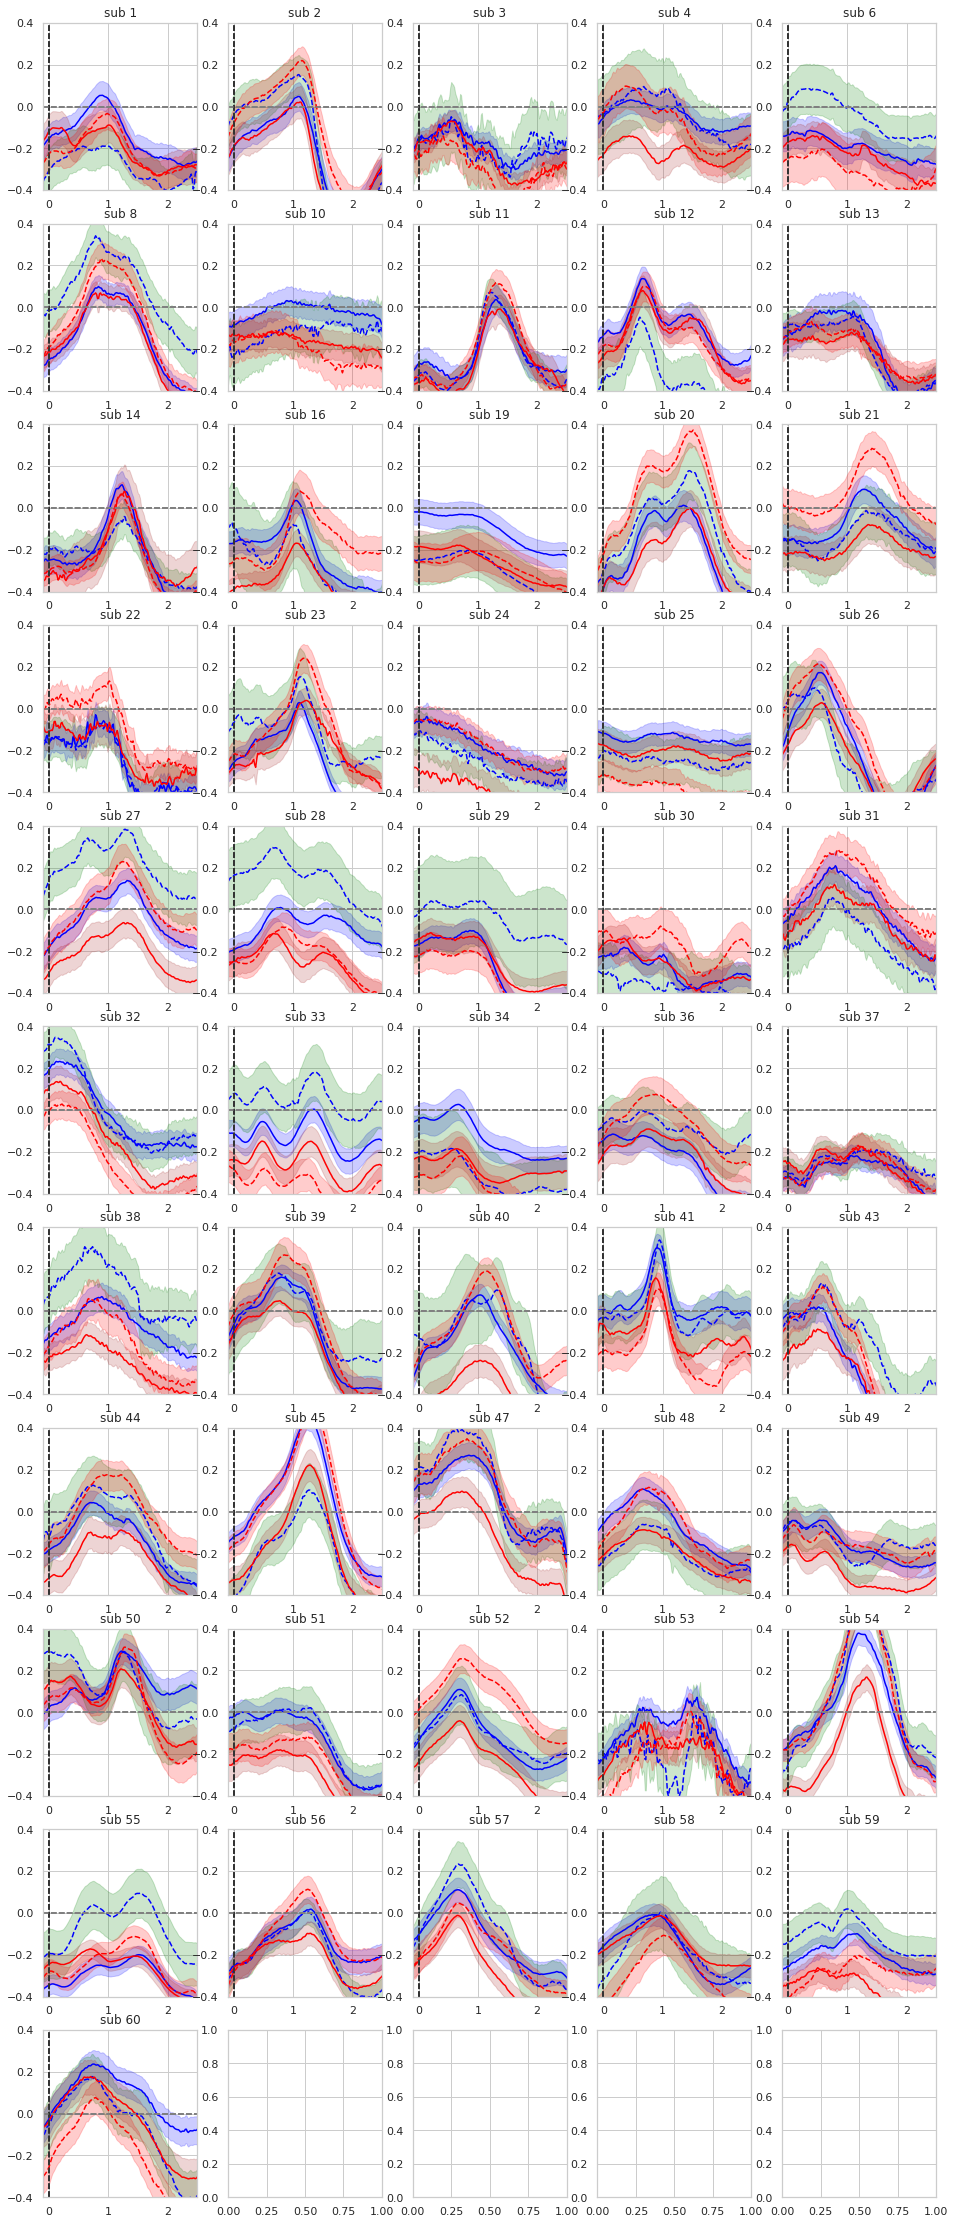

In [97]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
iii = 1

nrows=11
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 40))

#num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


count = 0
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    

    
    
    
    
    # for each subject, plot a separate average pupil response figure
    

        #y1_or = Y_to_plot[:,i,:]

        y1 = np.nanmean(y1_or,axis=0)
        y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        axs[count//ncols, count%ncols].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
        axs[count//ncols, count%ncols].axvline(x=0,color=".2", linestyle="--")
        axs[count//ncols, count%ncols].axhline(y=0,color="grey", linestyle="--")

        axs[count//ncols, count%ncols].fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])
        axs[count//ncols, count%ncols].set_xlim([-0.1, 2.5])
        axs[count//ncols, count%ncols].set_ylim([-0.4, 0.4])
        axs[count//ncols, count%ncols].set_title(f'sub {sub+1}')



    #axs[count].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    count = count+1
    
    Y_to_plot.append(Y_all)

 

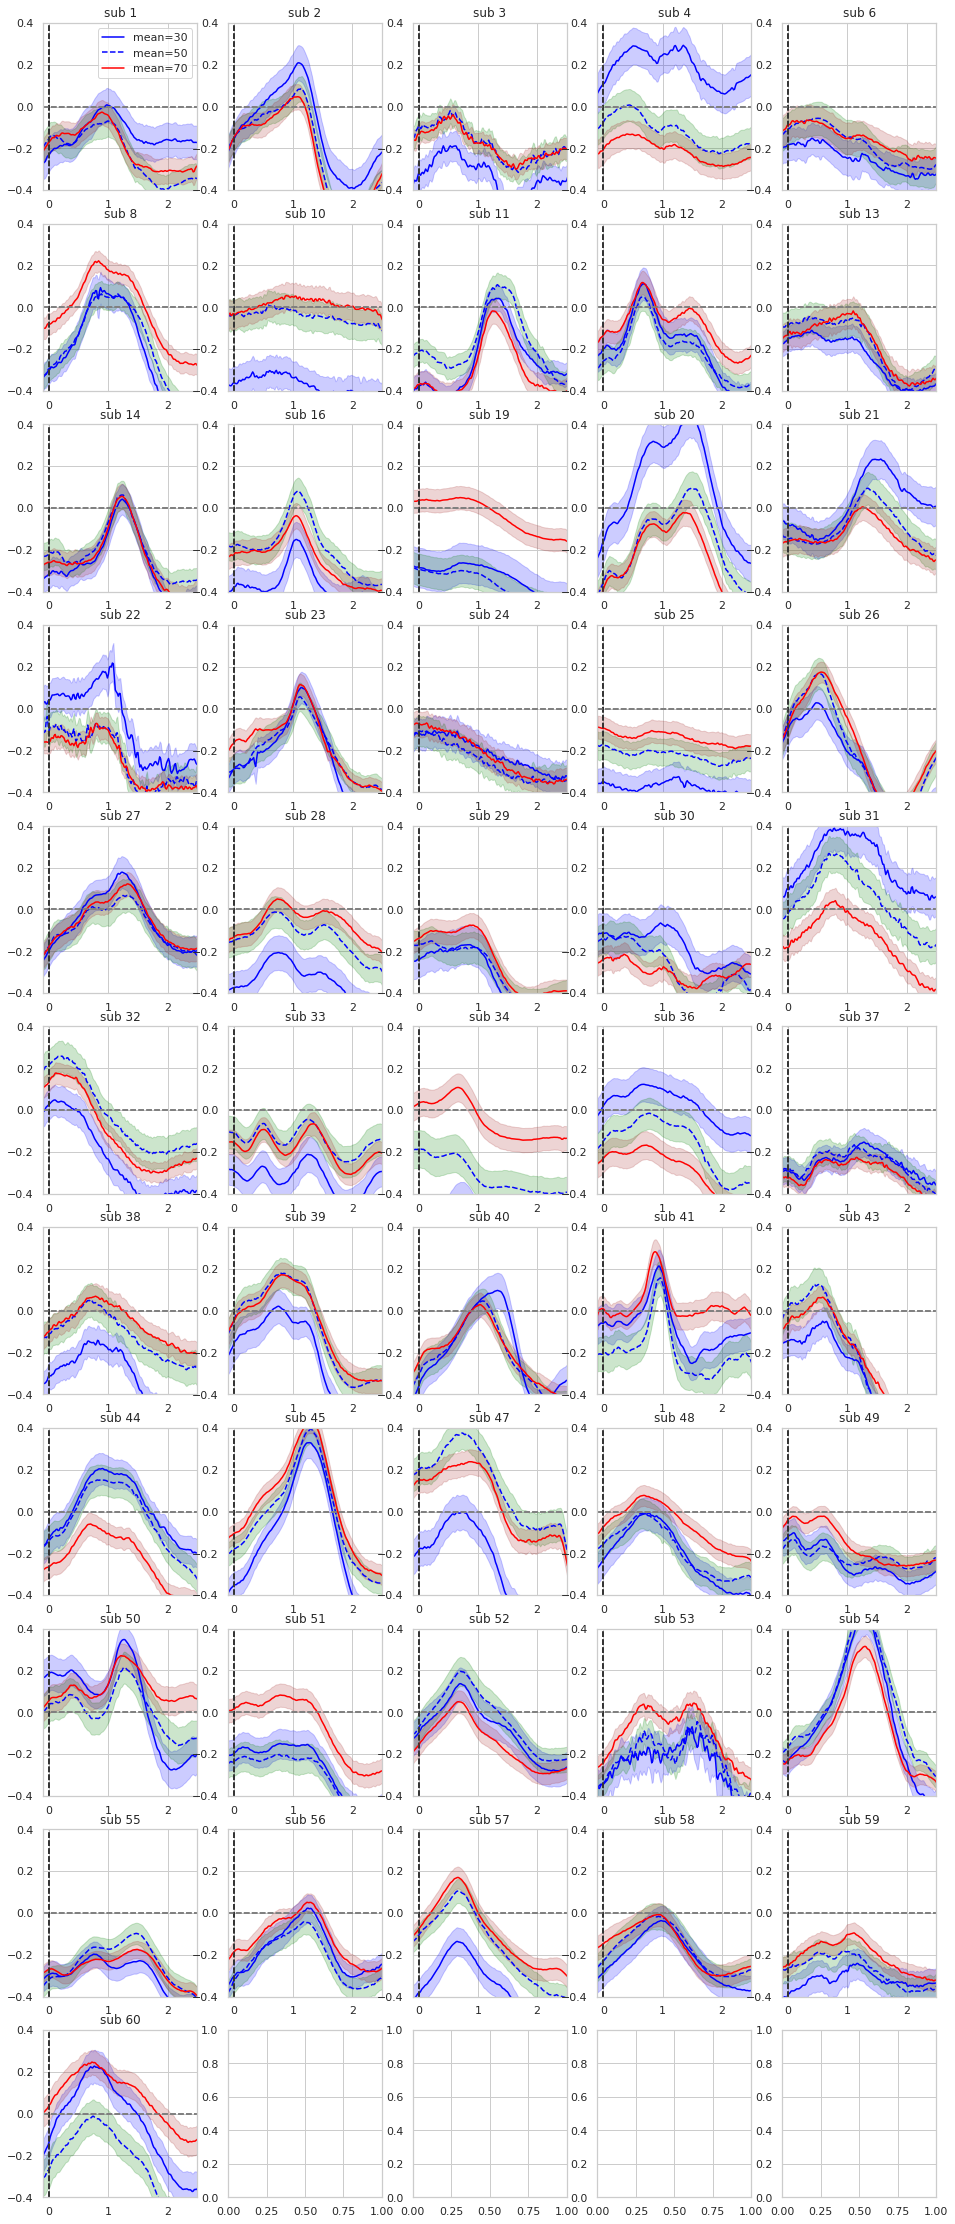

In [160]:
# plot the average for all subjects

types = 'mean_chosen'
types2 = 'changepoints'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['mean=30', 'mean=50', 'mean=70']

Y_to_plot = []
iii = 1

nrows=11
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 40))


#num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


count = 0
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new[types] == 30) & (joint_data_new[types2] == False)]
    to_plot2 = joint_data_new[(joint_data_new[types] == 50) & (joint_data_new[types2] == False)]

    to_plot3 = joint_data_new[(joint_data_new[types] == 70) & (joint_data_new[types2] == False)]
    #to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot3]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    

    
    
    
    
    # for each subject, plot a separate average pupil response figure
    

        #y1_or = Y_to_plot[:,i,:]

        y1 = np.nanmean(y1_or,axis=0)
        y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        axs[count//ncols, count%ncols].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
        if count == 0:
            axs[count//ncols, count%ncols].legend()
        axs[count//ncols, count%ncols].axvline(x=0,color=".2", linestyle="--")
        axs[count//ncols, count%ncols].axhline(y=0,color="grey", linestyle="--")

        axs[count//ncols, count%ncols].fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])
        axs[count//ncols, count%ncols].set_xlim([-0.1, 2.5])
        axs[count//ncols, count%ncols].set_ylim([-0.4, 0.4])
        axs[count//ncols, count%ncols].set_title(f'sub {sub+1}')



    #axs[count].plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    count = count+1
    
    Y_to_plot.append(Y_all)

    #plt.legend()
 

In [ ]:
# for each subject, median split for pupil size (change)?


In [98]:
   
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.6, 0.6])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(51, 4, 187)


shape to plot:  (51, 4)
group  1
with group 2: p=0.16214193886338454
with group 3: p=0.019922765854485564
with group 4: p=0.0002497794636476246
group  2
with group 3: p=0.8489455701450455
with group 4: p=2.0413619737134436e-05
group  3
with group 4: p=1.4015993485934608e-08
group  4


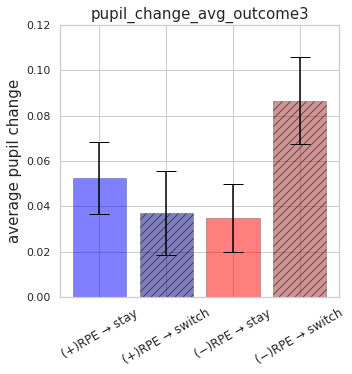

In [99]:
# find the reaction time for each group




types = 'switch_next'
metric = 'change'
event = 'outcome3'
label = f'pupil_{metric}_avg_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot3 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot4 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]

    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    y1_list = []
    y1_se_list = []
    
    # for each subject in each category (in 'labels'), find the average number
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1_list.append(np.mean(y1_or,axis=0))
        #y1_se_list.append(np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))

    Y_to_plot.append(y1_list)
    
Y_to_plot = np.array(Y_to_plot)
print('shape to plot: ', Y_to_plot.shape) 

    
y1_mean = np.mean(Y_to_plot, axis=0)

#y1_se_list = np.nanstd(y1_mean,axis=0) / np.sqrt(np.size(y1_mean, axis=0))
#y1_se_list = np.nanstd(Y_to_plot, axis=0) 
#y1_see_list = np.sqrt(np.size(y1_mean, axis=0))
y1_se_list = stats.sem(Y_to_plot,axis=0)


gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

#linecolor = ['blue', 'green', 'red', 'orange']
linecolor = ['blue', 'navy', 'red', 'brown']
patterns = ['', '///','','///']

x_pos = np.arange(len(labels))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black', hatch=patterns, linewidth=0.5)
ax.set_ylabel(f'average pupil {metric}',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.set_title(f'{label}', fontsize=15)
ax.set_ylim([0, 0.12])
ax.yaxis.grid(True)

# compute the paired t-test values:
for i in range(num_lines):
    y11 = Y_to_plot[:,i]
    print('group ', i+1)
    for j in range(i+1, num_lines):
        if j < num_lines:
            y22 = Y_to_plot[:,j]
            kk, pp = stats.ttest_rel(y11, y22)
            print(f'with group {j+1}: p={pp}')

shape to plot:  (48, 4)
group  1
with group 2: p=0.2565095291651006
with group 3: p=0.014286764349860936
with group 4: p=0.00012273210245044222
group  2
with group 3: p=0.5586537082883114
with group 4: p=3.70552666587468e-05
group  3
with group 4: p=1.0565366432983602e-09
group  4


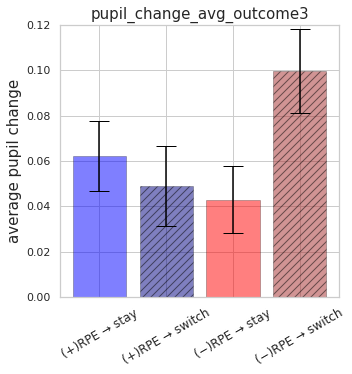

In [100]:
# find the reaction time for each group




types = 'switch_next'
metric = 'change'
event = 'outcome3'
label = f'pupil_{metric}_avg_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot3 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot4 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]

    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    y1_list = []
    y1_se_list = []
    
    # for each subject in each category (in 'labels'), find the average number
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1_list.append(np.mean(y1_or,axis=0))
        #y1_se_list.append(np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))

    Y_to_plot.append(y1_list)
    
Y_to_plot = np.array(Y_to_plot)
print('shape to plot: ', Y_to_plot.shape) 

    
y1_mean = np.mean(Y_to_plot, axis=0)

#y1_se_list = np.nanstd(y1_mean,axis=0) / np.sqrt(np.size(y1_mean, axis=0))
#y1_se_list = np.nanstd(Y_to_plot, axis=0) 
#y1_see_list = np.sqrt(np.size(y1_mean, axis=0))
y1_se_list = stats.sem(Y_to_plot,axis=0)


gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

#linecolor = ['blue', 'green', 'red', 'orange']
linecolor = ['blue', 'navy', 'red', 'brown']
patterns = ['', '///','','///']

x_pos = np.arange(len(labels))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black', hatch=patterns, linewidth=0.5)
ax.set_ylabel(f'average pupil {metric}',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.set_title(f'{label}', fontsize=15)
ax.set_ylim([0, 0.12])
ax.yaxis.grid(True)

# compute the paired t-test values:
for i in range(num_lines):
    y11 = Y_to_plot[:,i]
    print('group ', i+1)
    for j in range(i+1, num_lines):
        if j < num_lines:
            y22 = Y_to_plot[:,j]
            kk, pp = stats.ttest_rel(y11, y22)
            print(f'with group {j+1}: p={pp}')

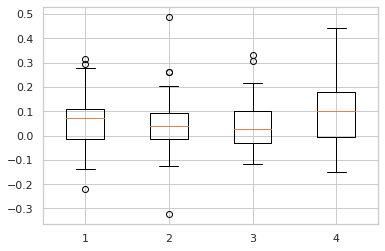

In [101]:
#all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]
plt.boxplot(Y_to_plot)
plt.show()

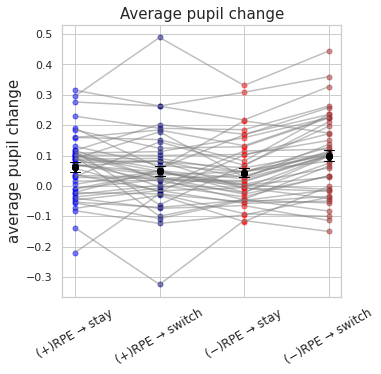

In [102]:
#data = np.random.rayleigh(scale=1, size=(30,4))
#labels = list("ABCD")
colors = ["crimson", "purple", "limegreen", "gold"]
colors = ['blue', 'navy', 'red', 'brown']

data = Y_to_plot

width=0.0

gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

for i in range(data.shape[0]):
    ax.plot(np.arange(4), data[i,:], color='grey', alpha=0.5)

for i, l in enumerate(labels):
    x = np.ones(data.shape[0])*i + (np.random.rand(data.shape[0])*width-width/2.)
    ax.scatter(x, data[:,i], color=colors[i], s=25, alpha=0.5)
    ax.errorbar(range(len(y1_mean)), y1_mean, yerr=y1_se_list, capsize=5, color='black', alpha=1,
             linewidth=3, linestyle='', marker='o')
    mean = data[:,i].mean()
    ax.plot([i-width/2., i+width/2.],[mean,mean], color="k")

    
    
    
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)


ax.set_ylabel(f'average pupil {metric}',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.set_title(f'Average pupil {metric}', fontsize=15)
#ax.set_ylim([0, 1.3])
ax.yaxis.grid(True)

plt.show()

In [103]:
# for each subject:
# (1) for all free trials, median-split for pupil size, and plot p(switch) or p(stay) for each group
# (2) do something about RPE

In [104]:
joint_data_temp = joint_data_by_sub['sub1']
joint_data = joint_data_temp[joint_data_temp['free']==True]

joint_data_sorted = joint_data.sort_values('pupil_change_avg_outcome3', ascending=True)
mid = len(joint_data_sorted)//2
num_switch_g1 = np.count_nonzero(joint_data_sorted[:mid]['switch_next'].to_numpy())
num_switch_g2 = np.count_nonzero(joint_data_sorted[mid:]['switch_next'].to_numpy())
print(num_switch_g1, num_switch_g2)
print(num_switch_g1/mid, num_switch_g2/mid)

102 110
0.3984375 0.4296875


In [105]:
g1, g2 = [], []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free']==True]

    joint_data_sorted = joint_data.sort_values('pupil_change_avg_outcome3', ascending=True)
    mid = len(joint_data_sorted)//2
    num_switch_g1 = np.count_nonzero(joint_data_sorted[:mid]['switch_next'].to_numpy())
    num_switch_g2 = np.count_nonzero(joint_data_sorted[mid:]['switch_next'].to_numpy())
    #print(num_switch_g1, num_switch_g2)
    g1.append(num_switch_g1/mid),
    g2.append(num_switch_g2/mid)
    print(num_switch_g1/mid, num_switch_g2/mid)

0.3984375 0.4296875
0.37109375 0.4375
0.203125 0.15625
0.26171875 0.1953125
0.3046875 0.328125
0.26171875 0.296875
0.31640625 0.25390625
0.4296875 0.5390625
0.32421875 0.328125
0.578125 0.5078125
0.63671875 0.58203125
0.16015625 0.2265625
0.2734375 0.3515625
0.34765625 0.38671875
0.3671875 0.36328125
0.4296875 0.4140625
0.3125 0.34765625
0.32421875 0.28125
0.2421875 0.30078125
0.375 0.390625
0.23529411764705882 0.24705882352941178
0.203125 0.23828125
0.3515625 0.39453125
0.328125 0.30078125
0.29017857142857145 0.30357142857142855
0.33984375 0.40625
0.41796875 0.453125
0.26953125 0.24609375
0.20703125 0.30078125
0.29296875 0.33203125
0.39453125 0.44140625
0.40625 0.46875
0.3125 0.3359375
0.31640625 0.39453125
0.21484375 0.26171875
0.2421875 0.328125
0.30078125 0.29296875
0.37890625 0.3203125
0.33984375 0.4296875
0.296875 0.3671875
0.27734375 0.328125
0.27734375 0.375
0.265625 0.36328125
0.4765625 0.5703125
0.2734375 0.37109375
0.1015625 0.2109375
0.26953125 0.34375
0.421875 0.3515625


group  1
with group 2: p=0.00022531834559150584
group  2


Text(0.5, 1.0, 'Frequency of stay (median-split by pupil) \n(paired t-test p=0.0002)')

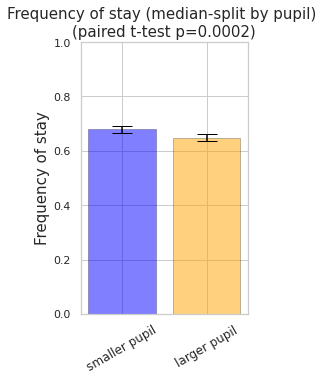

In [106]:
g1, g2 = [], []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free']==True]

    joint_data_sorted = joint_data.sort_values('pupil_change_avg_outcome3', ascending=True)
    mid = len(joint_data_sorted)//2
    num_switch_g1 = np.count_nonzero(joint_data_sorted[:mid]['switch_next'].to_numpy())
    num_switch_g2 = np.count_nonzero(joint_data_sorted[mid:]['switch_next'].to_numpy())
    #print(num_switch_g1, num_switch_g2)
    g1.append(1-num_switch_g1/mid),
    g2.append(1-num_switch_g2/mid)
    #print(num_switch_g1/mid, num_switch_g2/mid)
    

gridsize = (1,1)
fig = plt.figure(figsize=(3, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

#linecolor = ['blue', 'green', 'red', 'orange']
linecolor = ['blue', 'orange', 'red', 'brown']
patterns = ['', '']

labels = ['smaller pupil', 'larger pupil']
G = np.array([g1, g2])

x_pos = np.arange(len(labels))
y1_mean = np.mean(G,axis=1)
y1_se_list = stats.sem(G, axis=1)
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black', hatch=patterns, linewidth=0.5)
ax.set_ylabel(f'Frequency of stay',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.set_ylim([0, 1])
ax.yaxis.grid(True)

G = [g1, g2]
num_lines = len(labels)
# compute the paired t-test values:
for i in range(len(labels)):
    y11 = G[i]
    print('group ', i+1)
    for j in range(i+1, num_lines):
        if j < num_lines:
            y22 = G[j]
            kk, pp = stats.ttest_rel(y11, y22)
            print(f'with group {j+1}: p={pp}')
            
            
ax.set_title(f'Frequency of stay (median-split by pupil) \n(paired t-test p={np.round(pp,4)})', fontsize=15)

In [107]:
import matplotlib.patches as mpatches


group  1
with group 2: p=8.386135024136636e-18
with group 3: p=0.21070295926845767
with group 4: p=6.5307841120787874e-21
group  2
with group 3: p=1.6819515040461346e-15
with group 4: p=3.4651107705701563e-07
group  3
with group 4: p=2.0674042659202634e-19
group  4


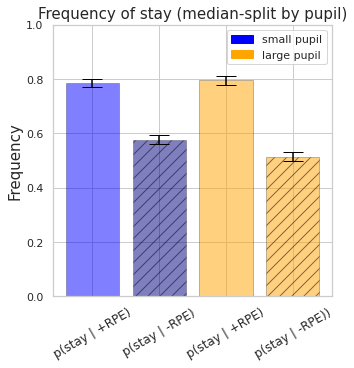

In [108]:
g11, g22, g33, g44 = [], [], [], []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free']==True]

    joint_data_sorted = joint_data.sort_values('pupil_change_avg_outcome3', ascending=True)
    mid = len(joint_data_sorted)//2
    g1 = np.count_nonzero((joint_data_sorted[:mid]['switch_next']==False) & (joint_data_sorted[:mid]['RPE']>0))
    
    g2 = np.count_nonzero((joint_data_sorted[mid:]['switch_next']==False) & (joint_data_sorted[mid:]['RPE']>0))
    
    g3 = np.count_nonzero((joint_data_sorted[:mid]['switch_next']==False) & (joint_data_sorted[:mid]['RPE']<0))
    g4 = np.count_nonzero((joint_data_sorted[mid:]['switch_next']==False) & (joint_data_sorted[mid:]['RPE']<0))
    
    
    better1 = np.count_nonzero((joint_data_sorted[:mid]['RPE']>0))
    worse1 = np.count_nonzero((joint_data_sorted[:mid]['RPE']<0))
                           
    
    better2 = np.count_nonzero((joint_data_sorted[mid:]['RPE']>0))
    worse2 = np.count_nonzero((joint_data_sorted[mid:]['RPE']<0))
                          
                           
    
    
    #print(num_switch_g1, num_switch_g2)
    g11.append(g1/better1)
    g22.append(g2/better2)
    g33.append(g3/worse1)
    g44.append(g4/worse2)
    #print(num_switch_g1/mid, num_switch_g2/mid)
    

gridsize = (1,1)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

#linecolor = ['blue', 'green', 'red', 'orange']
linecolor = ['blue', 'navy', 'orange', 'orange']
patterns = ['', '//','','//']

labels = ['p(stay | +RPE)', 'p(stay | -RPE)','p(stay | +RPE)', 'p(stay | -RPE))']
G = [g11, g33, g22, g44]

x_pos = np.arange(len(labels))
y1_mean = np.mean(G,axis=1)
y1_se_list = stats.sem(G, axis=1)
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black', hatch=patterns, linewidth=0.5)
ax.set_ylabel(f'Frequency',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.set_ylim([0, 1])
ax.yaxis.grid(True)


red_patch = mpatches.Patch(label='small pupil')
red_patch.set_color('blue')

green_patch = mpatches.Patch(label='large pupil')
green_patch.set_color('orange')
plt.legend(handles=[red_patch, green_patch])


num_lines = len(labels)
# compute the paired t-test values:
for i in range(len(labels)):
    y11 = G[i]
    print('group ', i+1)
    for j in range(i+1, num_lines):
        if j < num_lines:
            y22 = G[j]
            kk, pp = stats.ttest_rel(y11, y22)
            print(f'with group {j+1}: p={pp}')
            
            
ax.set_title(f'Frequency of stay (median-split by pupil)', fontsize=15)


plt.show()

In [109]:
y1_mean

array([0.78465539, 0.57610631, 0.79573198, 0.51407626])

group  1
with group 2: p=6.699854386004477e-14
group  2


Text(0.5, 1.0, 'Mean magnitude of RPE (median-split by pupil) \n(paired t-test p=0.0)')

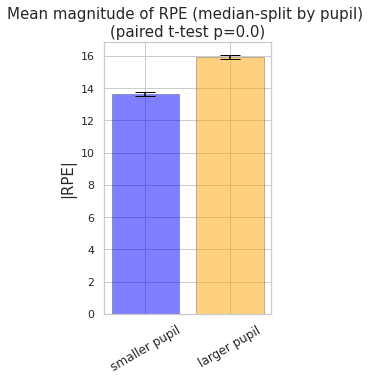

In [110]:
# plot for the RPE instead of p(Stay)


g1, g2 = [], []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free']==True]

    joint_data_sorted = joint_data.sort_values('pupil_change_avg_outcome3', ascending=True)
    mid = len(joint_data_sorted)//2
    num_switch_g1 = np.abs(joint_data_sorted[:mid]['RPE'].to_numpy())
    num_switch_g2 = np.abs(joint_data_sorted[mid:]['RPE'].to_numpy())
    #print(num_switch_g1, num_switch_g2)
    g1.append(np.mean(num_switch_g1)),
    g2.append(np.mean(num_switch_g2))
    #print(np.mean(num_switch_g1), np.mean(num_switch_g2))
    
    
    
    
gridsize = (1,1)
fig = plt.figure(figsize=(3, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

#linecolor = ['blue', 'green', 'red', 'orange']
linecolor = ['blue', 'orange', 'red', 'brown']
patterns = ['', '']

labels = ['smaller pupil', 'larger pupil']
G = np.array([g1, g2])

x_pos = np.arange(len(labels))
y1_mean = np.mean(G,axis=1)
y1_se_list = stats.sem(G, axis=1)
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black', hatch=patterns, linewidth=0.5)
ax.set_ylabel(f'|RPE|',fontsize=15)
ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=30)
#ax.set_ylim([0, 0.5])
ax.yaxis.grid(True)

G = [g1, g2]
num_lines = len(labels)
# compute the paired t-test values:
for i in range(len(labels)):
    y11 = G[i]
    print('group ', i+1)
    for j in range(i+1, num_lines):
        if j < num_lines:
            y22 = G[j]
            kk, pp = stats.ttest_rel(y11, y22)
            print(f'with group {j+1}: p={pp}')
            
            
ax.set_title(f'Mean magnitude of RPE (median-split by pupil) \n(paired t-test p={np.round(pp,4)})', fontsize=15)

In [111]:
np.where(Y_to_plot[:,3]==Y_to_plot[:,3].min())
valid_sub_new[23]

32

In [112]:
np.where(Y_to_plot[:,3]==Y_to_plot[:,3].min())

(array([17]),)

In [113]:
np.argmin(Y_to_plot[:,0])

31

In [114]:
pupil_data_holder['sub']

KeyError: 'sub'

In [115]:
# get the segment of pupil response
TIME_START = 0.5
TIME_END = 1.5

x = t_epochs[f't_outcome']
epoch_use = (x >= TIME_START) & (x<= TIME_END)
print(y1_or.shape)
print(y1_or[:, epoch_use].shape)
np.mean(y1_or[:, epoch_use],axis=1).shape



(132,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [116]:
def get_epochs_mean(y, event='outcome', TIME_START=0.5, TIME_END=1.5):
    x = t_epochs[f't_{event}']
    epoch_use = (x >= TIME_START) & (x<= TIME_END)
    epoch_mean = np.mean(y[:, epoch_use], axis=1)

In [117]:
np.array(Y[i][label].to_list()).shape

(66,)

(51, 4, 187)


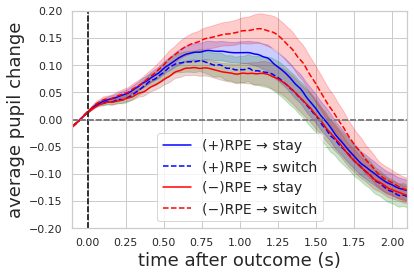

In [118]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(51, 4, 187)


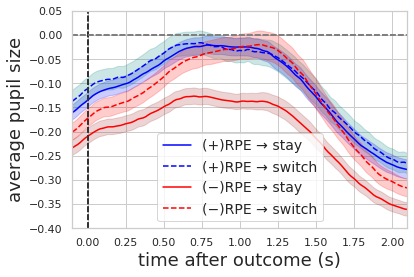

In [119]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'teal', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.4, 0.05])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(48, 4, 187)


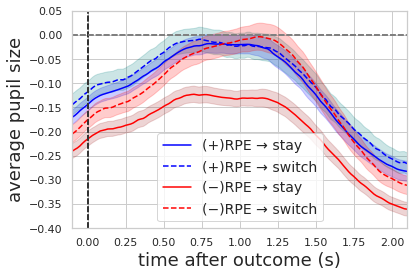

In [120]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'teal', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.4, 0.05])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

In [121]:
t_epochs['t_outcome'][(t_epochs['t_outcome'] >= 0.5) & (t_epochs['t_outcome'] <= 1.5)]

array([0.516295, 0.53295 , 0.549605, 0.566259, 0.582914, 0.599569,
       0.616223, 0.632878, 0.649533, 0.666187, 0.682842, 0.699497,
       0.716151, 0.732806, 0.749461, 0.766116, 0.78277 , 0.799425,
       0.81608 , 0.832734, 0.849389, 0.866044, 0.882698, 0.899353,
       0.916008, 0.932662, 0.949317, 0.965972, 0.982626, 0.999281,
       1.015936, 1.032591, 1.049245, 1.0659  , 1.082555, 1.099209,
       1.115864, 1.132519, 1.149173, 1.165828, 1.182483, 1.199137,
       1.215792, 1.232447, 1.249101, 1.265756, 1.282411, 1.299066,
       1.31572 , 1.332375, 1.34903 , 1.365684, 1.382339, 1.398994,
       1.415648, 1.432303, 1.448958, 1.465612, 1.482267, 1.498922])

(48, 4, 187)


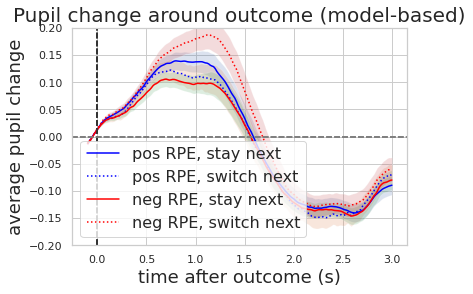

In [122]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['pos RPE, stay next', 
                      'pos RPE, switch next',
                      'neg RPE, stay next',
                      'neg RPE, switch next']

Y_to_plot = []
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dotted', 'solid', 'dotted']
for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.legend(prop={"size":16})
#plt.legend()
        

(51, 4, 187)


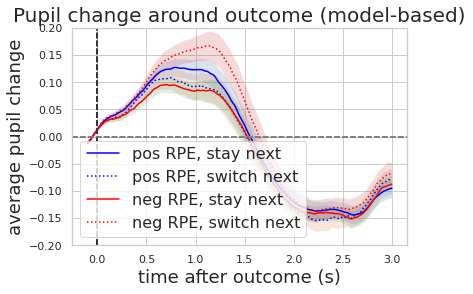

In [123]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['pos RPE, stay next', 
                      'pos RPE, switch next',
                      'neg RPE, stay next',
                      'neg RPE, switch next']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dotted', 'solid', 'dotted']
for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.legend(prop={"size":16})
#plt.legend()
        

In [124]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

(51, 4, 187)


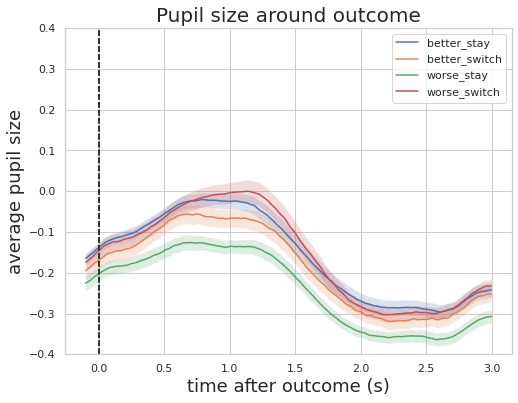

In [125]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better_stay', 
                      'better_switch',
                      'worse_stay',
                      'worse_switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(8, 6))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.4, 0.4])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 2, 187)


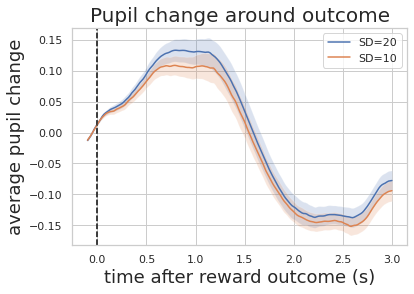

In [126]:
# plot the average for all subjects

types = ['SD=20', 'SD=10']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data['SD'] == 20]
    to_plot2 = joint_data[joint_data['SD'] == 10]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
#ax4.set_ylim([-0.08, 0.08])
ax4.legend(prop={"size":16})
plt.legend()
        

(51, 2, 187)


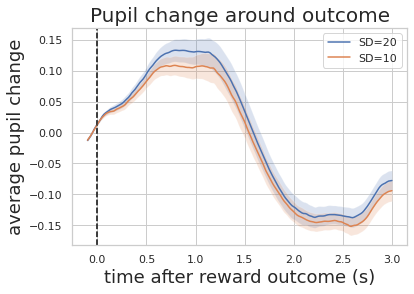

In [127]:
# plot the average for all subjects

types = ['SD=20', 'SD=10']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data['SD'] == 20]
    to_plot2 = joint_data[joint_data['SD'] == 10]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
#ax4.set_ylim([-0.08, 0.08])
ax4.legend(prop={"size":16})
plt.legend()
        

In [128]:
joint_data.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [129]:
test_data = joint_data_by_sub[f'sub{sub+1}']

test_data['RPE_before'] = np.insert(test_data['RPE'].to_numpy(), 0, 0)[:-1]
test_data[['RPE', 'RPE_before']]

RPE  RPE_before
0     8.000000    0.000000
1    29.000000    8.000000
2   -43.202294   29.000000
3   -23.885477  -43.202294
4    25.768197  -23.885477
..         ...         ...
763  -5.062463  -32.019844
764   2.703393   -5.062463
765 -13.171941    2.703393
766 -21.024688  -13.171941
767 -34.497536  -21.024688

[768 rows x 2 columns]

### Logistic models

In [131]:
import statsmodels.discrete.discrete_model as smd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [132]:
# get the correlation

test_data = joint_data_by_sub['sub1']
test_data['switch_int'] = test_data['switch_next'].to_numpy()*1
#y_logit = test_data[']
X_logit = test_data[['switch_int', 'RPE', 'pupil_change_avg_outcome']]



In [133]:
sd_model = smf.logit(formula='switch_int ~ RPE + pupil_change_avg_outcome + RPE:pupil_change_avg_outcome',
                    data=X_logit).fit()
sd_model.summary()
#sd_model = sd.Logit(y, sm.add_constant(X)).fit(disp=0)
#print(sd_model.pvalues)
#sd_model.summary()

Optimization terminated successfully.
         Current function value: 0.664896
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             switch_int   No. Observations:                  768
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.03805
Time:                        09:34:23   Log-Likelihood:                -510.64
converged:                       True   LL-Null:                       -530.84
Covariance Type:            nonrobust   LLR p-value:                 8.797e-09
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.1479      0.075     -1.985      0.047      -0.294      -0.002
RPE                             -0.0251      0.004     -6.032      0.000      -0.033      -0.017
pupil_change_avg_outcome         0.1394      0.124      1.121      0.262      -0.104       0.383
RPE:pupil_change_avg_outcome    -0.0027      0.007     -0.377      0.706      -0.017       0.011
================================================================================================
"""

In [134]:

test_data = joint_data_by_sub['sub10']
test_data['switch_int'] = test_data['switch_next'].to_numpy()*1

test_data_free = test_data[test_data['free'] == True]
X_logit = test_data_free[['switch_int', 'RPE', 'pupil_change_avg_outcome']]

sd_model = smf.logit(formula='switch_int ~ RPE + pupil_change_avg_outcome + RPE:pupil_change_avg_outcome',
                    data=X_logit).fit()
sd_model.summary()

Optimization terminated successfully.
         Current function value: 0.573996
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             switch_int   No. Observations:                  512
Model:                          Logit   Df Residuals:                      508
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.03975
Time:                        09:34:39   Log-Likelihood:                -293.89
converged:                       True   LL-Null:                       -306.05
Covariance Type:            nonrobust   LLR p-value:                 2.130e-05
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.0200      0.106     -9.591      0.000      -1.228      -0.812
RPE                             -0.0267      0.006     -4.517      0.000      -0.038      -0.015
pupil_change_avg_outcome         0.2622      0.235      1.118      0.264      -0.198       0.722
RPE:pupil_change_avg_outcome     0.0171      0.011      1.494      0.135      -0.005       0.040
================================================================================================
"""

In [135]:

test_data = joint_data_by_sub['sub3']
test_data['switch_int'] = test_data['switch'].to_numpy()*1

test_data_free = test_data[test_data['free'] == True]
X_logit = test_data_free[['switch_int', 'RPE_before', 'pupil_size_avg_pre_response']]

sd_model = smf.logit(formula='switch_int ~ RPE_before + pupil_size_avg_pre_response + RPE_before:pupil_size_avg_pre_response',
                    data=X_logit).fit()
sd_model.summary()

Optimization terminated successfully.
         Current function value: 0.411219
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             switch_int   No. Observations:                  512
Model:                          Logit   Df Residuals:                      508
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.07206
Time:                        09:34:40   Log-Likelihood:                -210.54
converged:                       True   LL-Null:                       -226.89
Covariance Type:            nonrobust   LLR p-value:                 3.729e-07
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.8146      0.137    -13.198      0.000      -2.084      -1.545
RPE_before                                -0.0376      0.007     -5.388      0.000      -0.051      -0.024
pupil_size_avg_pre_response                0.1322      0.179      0.740      0.459      -0.218       0.482
RPE_before:pupil_size_avg_pre_response    -0.0046      0.010     -0.463      0.643      -0.024       0.015
==========================================================================================================
"""

In [144]:
y = 'switch_choice'
x1 = 'RPE_before'
x2 = 'pupil_size_avg_pre_response'

coefs = pd.DataFrame()
for sub in valid_sub_new_new-1:
    
    test_data = joint_data_by_sub[f'sub{sub+1}']
    test_data['switch_choice'] = test_data['switch'].to_numpy()*1

    test_data_free = test_data[test_data['free'] == True]
    X_logit = test_data_free[[y, x1, x2]]

    sd_model = smf.logit(formula= f'{y} ~ {x1} + {x2} + {x1}:{x2}',
                        data=X_logit).fit()
    #sd_model.summary()
    coefs = pd.concat([coefs, sd_model.params], axis=1)



Optimization terminated successfully.
         Current function value: 0.621680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.437927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681826
  

In [145]:
coefs_new = coefs.T
coefs_new.reset_index(inplace=True)
coefs_new['sub'] = valid_sub_new_new
coefs_new_plot = coefs_new.drop(columns=['index','sub'])
coefs_new_plot.rename(columns={'RPE:pupil_change_avg_outcome3': 'interaction'}, inplace=True)
coefs_new_plot.head()

Intercept  RPE_before  pupil_size_avg_pre_response  \
0  -0.410040   -0.040420                     0.005019   
1  -0.380392   -0.045871                    -0.032581   
2  -1.814625   -0.037608                     0.132242   
3  -1.341297   -0.033740                     0.063944   
4  -0.800482    0.005756                     0.239505   

   RPE_before:pupil_size_avg_pre_response  
0                               -0.007311  
1                               -0.009587  
2                               -0.004581  
3                               -0.002062  
4                                0.007816

In [179]:
np.round(coefs_new_plot.mean().to_numpy(),3)

array([-0.85 , -0.049,  0.129, -0.001])

p= [0.00000000e+00 0.00000000e+00 1.61654600e-04 6.97756636e-01]


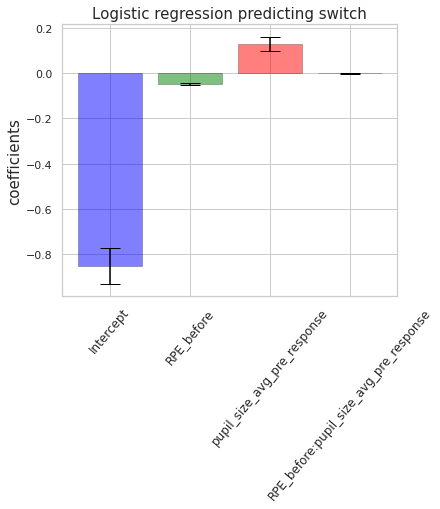

In [148]:

gridsize = (1,1)
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot2grid(gridsize, (0, 0))

linecolor = ['blue', 'green', 'red', 'orange']
#linecolor = ['blue', 'navy', 'red', 'brown']
patterns = ['', '///','','///']

labels = coefs_new_plot.columns

y1_mean = coefs_new_plot.mean().to_numpy()
y1_se_list = coefs_new_plot.sem().to_numpy()

x_pos = np.arange(len(labels))
ax.bar(x_pos, y1_mean, yerr=y1_se_list, align='center', alpha=0.5, ecolor='black', capsize=10, 
       color = linecolor, edgecolor='black',  linewidth=0.5)
ax.set_ylabel('coefficients',fontsize=15)

ax.set_xticks(x_pos)
#plt.xticks(weight='bold')
ax.set_xticklabels(labels, fontsize=12, rotation=50)
ax.set_title('Logistic regression predicting switch', fontsize=15)
#ax.set_ylim([-1, 0.3])
ax.yaxis.grid(True)

# compute the paired t-test values:
#for i in range(num_lines):
    #y11 = Y_to_plot[:,i]
    #print('group ', i+1)
#    for j in range(i+1, num_lines):
#        if j < num_lines:
            #y22 = Y_to_plot[:,j]
            #kk, pp = stats.ttest_rel(y11, y22)
            #print(f'with group {j+1}: p={pp}')
            
kk, pp = stats.ttest_1samp(coefs_new_plot, popmean=0, axis=0)
       
print('p=',np.round(pp,10))

In [360]:
y1_mean

array([-0.86739601, -0.03969384,  0.16382272, -0.00704289])

In [350]:

test_data = joint_data_by_sub['sub3']
test_data['switch_int'] = test_data['switch'].to_numpy()*1

test_data_free = test_data[test_data['free'] == True]
X_logit = test_data_free[['switch_int', 'RPE_before', 'pupil_size_avg_pre_response']]

sd_model = smf.logit(formula='switch_int ~ RPE_before + pupil_size_avg_pre_response + RPE_before:pupil_size_avg_pre_response',
                    data=X_logit).fit()
sd_model.summary()

Optimization terminated successfully.
         Current function value: 0.411219
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             switch_int   No. Observations:                  512
Model:                          Logit   Df Residuals:                      508
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Sep 2023   Pseudo R-squ.:                 0.07206
Time:                        15:01:15   Log-Likelihood:                -210.54
converged:                       True   LL-Null:                       -226.89
Covariance Type:            nonrobust   LLR p-value:                 3.729e-07
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.8146      0.137    -13.198      0.000      -2.084      -1.545
RPE_before                                -0.0376      0.007     -5.388      0.000      -0.051      -0.024
pupil_size_avg_pre_response                0.1322      0.179      0.740      0.459      -0.218       0.482
RPE_before:pupil_size_avg_pre_response    -0.0046      0.010     -0.463      0.643      -0.024       0.015
==========================================================================================================
"""

In [255]:
aa = sd_model.params
bb = sd_model.params

In [263]:
pd.concat([coefs, aa, bb], axis=1)

0         1
Intercept                              -0.410040 -0.410040
RPE_before                             -0.040420 -0.040420
pupil_size_avg_pre_response             0.005019  0.005019
RPE_before:pupil_size_avg_pre_response -0.007311 -0.007311

In [241]:
sd_model.params['pupil_change_avg_outcome']

0.2622497656359969

In [230]:
yhat = sd_model.predict(test_data_free[['RPE', 'pupil_change_avg_outcome']])
prediction = list(map(round, yhat))


from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)

ytest = test_data_free['switch_int']
# confusion matrix
cm = confusion_matrix(ytest, prediction) 
print ("Confusion Matrix : \n", cm) 
print('accuracy = ', accuracy_score(ytest, prediction))


Confusion Matrix : 
 [[362   4]
 [133  13]]
accuracy =  0.732421875


In [62]:
# joint all subjects together
joint_all_sub_data = pd.DataFrame()
for sub in valid_sub_new_new-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    
    joint_all_sub_data = pd.concat([joint_all_sub_data, joint_data_temp], axis=0)
    
joint_all_sub_data.reset_index(drop=True, inplace=True)


NameError: name 'valid_sub_new_new' is not defined

In [165]:
joint_all_sub_data

level_0  index  trial     rt  \
0            0      0      0  0.873   
1            1      1      1  0.503   
2            2      2      2  0.948   
3            3      3      3  0.633   
4            4      4      4  1.754   
...        ...    ...    ...    ...   
36762       91     91     91  1.142   
36763       92     92     92  0.316   
36764       93     93     93  0.412   
36765       94     94     94  0.319   
36766       95     95     95  0.325   

                                    pupil_baseline_start  \
0      [-0.13285487334831725, -0.15435727323074105, -...   
1      [0.14530678606560862, 0.1443430154502174, 0.24...   
2      [0.22792893919942742, 0.15482785060969537, 0.1...   
3      [-0.04115643605480424, -0.011971396588699315, ...   
4      [0.7752312920948785, 0.8033788108457145, 0.831...   
...                                                  ...   
36762  [0.67943674845904, 0.7272363341078137, 0.73705...   
36763  [-0.17780774209706132, -0.13794868236501812, -...   
36764  [-1.203478368664157, -1.1643138433366318, -1.1...   
36765  [-1.6546526797253853, -1.6049083492062692, -1....   
36766  [0.5476487169455556, 0.40803424555855716, 0.35...   

                                  pupil_baseline_outcome  \
0      [0.07491006887873684, 0.13786000971694218, 0.1...   
1      [0.23190501894722576, 0.17961922205809192, 0.1...   
2      [0.1730485920638111, 0.15684330963330576, 0.18...   
3      [-0.02837186777614119, 0.004751287527410095, 0...   
4      [0.467254551806917, 0.46196730826422516, 0.473...   
...                                                  ...   
36762  [0.5511960490811909, 0.5499120983188762, 0.581...   
36763  [-0.8800874249291134, -0.863458312754363, -0.8...   
36764  [-3.327919441521653, -3.3458417071503943, -3.3...   
36765  [-0.23448572896024178, -0.11422985799373579, -...   
36766  [-0.6308113880375159, -0.6443178855941037, -0....   

                                 pupil_size_pre_response  \
0      [0.11437311041501608, 0.10994014858446984, 0.1...   
1      [0.34474857188501473, 0.35575292963603705, 0.3...   
2      [-0.5578585701312097, -0.5368051541620953, -0....   
3      [0.9398780279838435, 0.9354819044102489, 0.927...   
4      [0.13627293908167493, 0.0938579818830942, 0.08...   
...                                                  ...   
36762  [1.0707077050777225, 1.0654853260524422, 1.070...   
36763  [-0.14873885096615147, -0.11531997069426185, -...   
36764  [-1.1940200358695918, -1.1961699578124045, -1....   
36765  [-1.558495613955596, -1.5328490750914376, -1.4...   
36766  [0.41406870553831127, 0.3766595113669954, 0.35...   

       pupil_size_avg_pre_response  \
0                         0.279017   
1                         0.299246   
2                        -0.249000   
3                         0.780104   
4                        -0.051292   
...                            ...   
36762                     1.213163   
36763                     0.221271   
36764                    -1.551658   
36765                    -1.222526   
36766                     0.228686   

                                     pupil_size_response  \
0      [0.353667051165722, 0.39952404529320773, 0.433...   
1      [0.3427030080472347, 0.3527936049405821, 0.374...   
2      [-0.043562563000114525, -0.010950897831385292,...   
3      [0.6531173173194468, 0.6612715975477902, 0.646...   
4      [-0.1988164400882881, -0.1855046140065632, -0....   
...                                                  ...   
36762  [1.3801842435307121, 1.323949527624748, 1.1854...   
36763  [0.32346568708713375, 0.35393766046567277, 0.4...   
36764  [-1.7172245184480575, -1.7368905531884036, -1....   
36765  [-1.106845834894351, -1.1308387794174326, -1.1...   
36766  [0.11716046275001123, 0.10990970946557645, 0.1...   

       pupil_size_avg_response  ... trial_after_cp  trial_forced  trial_num  \
0                     0.475576  ...              0             1          0   
1                     1.147825  ...    

In [166]:
joint_all_sub_data.keys()
joint_data_new = joint_all_sub_data[(joint_all_sub_data['free']==True)  &  (joint_all_sub_data['trial_after_cp']<=5) & (joint_all_sub_data['trial_after_cp']>0)] # free trials only


In [167]:
df = joint_data_new[keys_to_include_psy]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

#pvall = joint_selected.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
#pvall


NameError: name 'keys_to_include_psy' is not defined

In [168]:
keys_to_include_psy = [#'mean_score_free', 'p_stay', 'p_better_stay', 'p_worse_stay', \
                    #'l-to-h-minus-h-to-l_free', 'l-to-h-minus-h-to-l_forced', 'l-to-h-minus-h-to-l_all', \
                         'rt',
    'pupil_change_avg_pre_response',
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       #'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2','pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
    'pupil_change_avg_outcome','pupil_change_avg_outcome1', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
        'pupil_size_avg_response', 
       'pupil_size_avg_outcome', 'RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after',
       
       
        'switch', 'switch_next',
           'outcomes','outcome_change', 
       #'forced', 'free',
       'SD', 'changepoints', 'trial_after_forced', 'trial_after_cp',# 'sess','trial',
'mean_A', 'mean_B', 'mean_chosen', 'mean_unchosen', ]

key_to_plot = 'pupil_change_avg_outcome1'

from scipy.stats import pearsonr

rt_list = pd.DataFrame()
pval_list = pd.DataFrame()

for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[(joint_data_temp['free']==True)  & (joint_data_temp['changepoints']==True)] # free trials only
    #oint_data = joint_data_temp
    df = joint_data[keys_to_include_psy]

    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    rt_list[f'sub{sub+1}'] = rho[key_to_plot]
    pval_list[f'sub{sub+1}'] = pval[key_to_plot]
    #p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    #rho.round(2).astype(str) + p

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlat

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlat

In [169]:

tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)


AttributeError: 'DataFrame' object has no attribute 'iteritems'

<Figure size 720x576 with 0 Axes>

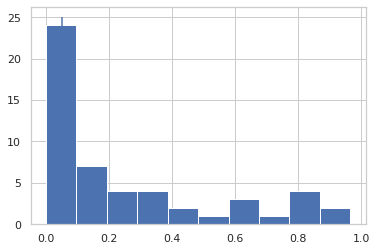

In [224]:
plt.hist(pval_list.T['UU_sum_after'])
plt.vlines(0.05, ymin=0, ymax=25)

In [225]:
stats.ttest_1samp(pval_list.T['UU_sum_after'], 0.05)

Ttest_1sampResult(statistic=4.738913805558138, pvalue=1.7600079671744863e-05)

In [247]:
rt_list.mean(axis=1)


rt                              -0.130170
pupil_change_avg_pre_response   -0.149316
pupil_change_avg_response       -0.324729
pupil_change_avg_outcome         0.594033
pupil_change_avg_outcome1        1.000000
pupil_change_avg_outcome3        0.458591
pupil_size_avg_pre_response     -0.599537
pupil_size_avg_response         -0.847390
pupil_size_avg_outcome          -0.718171
RPE                             -0.034336
ER_chosen_before                 0.038657
ER_chosen_after                 -0.011850
ER_sum_before                    0.025696
ER_sum_after                    -0.021586
ER_diff_before                   0.094575
ER_diff_after                   -0.004742
EU_chosen_before                 0.050099
EU_chosen_after                 -0.005195
EU_sum_before                    0.037120
EU_sum_after                     0.004156
EU_diff_before                   0.036634
EU_diff_after                   -0.012057
UU_chosen_before                 0.024874
UU_chosen_after                  0

In [249]:
pval_list.T.mean()

rt                               0.423723
pupil_change_avg_pre_response    0.427594
pupil_change_avg_response        0.263900
pupil_change_avg_outcome         0.113491
pupil_change_avg_outcome1        0.000000
pupil_change_avg_outcome3        0.185850
pupil_size_avg_pre_response      0.125395
pupil_size_avg_response          0.008633
pupil_size_avg_outcome           0.064612
RPE                              0.528408
ER_chosen_before                 0.514846
ER_chosen_after                  0.457679
ER_sum_before                    0.557192
ER_sum_after                     0.540404
ER_diff_before                   0.421303
ER_diff_after                    0.474953
EU_chosen_before                 0.504534
EU_chosen_after                  0.573646
EU_sum_before                    0.551412
EU_sum_after                     0.584928
EU_diff_before                   0.479003
EU_diff_after                    0.471405
UU_chosen_before                 0.479091
UU_chosen_after                  0

In [212]:
rt_list.T

rt  pupil_change_avg_pre_response  pupil_change_avg_response  \
sub1   0.009924                      -0.117116                  -0.328765   
sub2  -0.040197                      -0.183304                  -0.457408   
sub3  -0.287494                       0.071346                  -0.141477   
sub4  -0.271485                      -0.224238                  -0.358966   
sub6  -0.152692                      -0.075281                  -0.243390   
sub8  -0.110299                      -0.213749                  -0.372709   
sub10 -0.113391                      -0.153139                  -0.328617   
sub11 -0.112685                      -0.147572                  -0.288333   
sub12 -0.289102                      -0.077256                  -0.339932   
sub13 -0.047531                      -0.036584                  -0.405393   
sub14 -0.093424                      -0.002739                  -0.252812   
sub16 -0.317653                      -0.255268                  -0.248050   
sub19 -0.308343                      -0.183355                  -0.331858   
sub20 -0.268406                      -0.079564                  -0.319438   
sub21 -0.168810                      -0.193814                  -0.345169   
sub22 -0.198691                      -0.079751                  -0.273445   
sub23 -0.185857                      -0.190825                  -0.493742   
sub24 -0.013663                      -0.173213                  -0.275978   
sub25 -0.086679                       0.054415                  -0.168286   
sub26 -0.125343                      -0.022049                  -0.306433   
sub27 -0.252389                      -0.062095                  -0.332054   
sub28 -0.165393                      -0.194864                  -0.353071   
sub29 -0.218751                      -0.322128                  -0.359438   
sub30 -0.240103                      -0.171732                  -0.371145   
sub31 -0.167870                      -0.183857                  -0.350487   
sub32 -0.099999                      -0.202329                  -0.356841   
sub33 -0.047828                      -0.169413                  -0.424127   
sub34 -0.209033                      -0.183610                  -0.507234   
sub35 -0.146654                      -0.142553                  -0.478953   
sub36 -0.327198                      -0.268127                  -0.425005   
sub37 -0.141390                      -0.295159                  -0.369228   
sub38 -0.099085                      -0.092162                  -0.194867   
sub39 -0.204514                      -0.190569                  -0.317818   
sub40 -0.378523                      -0.119155                  -0.255404   
sub41  0.086664                      -0.007384                  -0.251066   
sub43 -0.062871                       0.019632                  -0.375350   
sub44 -0.190541                      -0.228491                  -0.466605   
sub45 -0.202186                      -0.123388                  -0.352991   
sub47 -0.116002                      -0.228879                  -0.306052   
sub48 -0.065429                      -0.190805                  -0.358418   
sub49 -0.079012                      -0.026057                  -0.377551   
sub50  0.064482                      -0.060992                  -0.276093   
sub51 -0.038358                      -0.166052                  -0.290323   
sub52 -0.074334                      -0.195124                  -0.394252   
sub53 -0.070357                      -0.007161                  -0.193960   
sub54 -0.179512                      -0.166878                  -0.314738   
sub55 -0.058481                      -0.099790                  -0.542323   
sub56 -0.022328                       0.045893                  -0.351060   
sub57 -0.145791                      -0.142292                  -0.279058   
sub58 -0.065293                      -0.192813                  -0.342585   
sub59 -0.114040                       0.042878                  -0.213771   
sub60 -0.

In [220]:
stats.ttest_1samp(rt_list.T['UU_sum_after'], 0)

Ttest_1sampResult(statistic=7.697923731486692, pvalue=4.3215498690358943e-10)

In [200]:
to_plot_tr.mean()

RPE                -0.062450
ER_chosen_before   -0.052975
ER_chosen_after    -0.084261
ER_sum_before      -0.073810
ER_sum_after       -0.096261
ER_diff_before      0.005121
ER_diff_after      -0.045540
EU_chosen_before    0.042658
EU_chosen_after     0.083736
EU_sum_before       0.068337
EU_sum_after        0.089031
EU_diff_before      0.002541
EU_diff_after       0.047487
UU_chosen_before    0.042789
UU_chosen_after     0.100757
UU_sum_before       0.066704
UU_sum_after        0.108920
UU_diff_before     -0.004232
UU_diff_after       0.076674
dtype: float64

In [163]:
print(key_to_plot)
pval_list.T[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

pupil_change_avg_outcome


RPE  ER_chosen_before  ER_chosen_after  ER_sum_before  \
sub1   0.330064          0.047366         0.237727       0.145978   
sub2   0.674423          0.920456         0.629398       0.297401   
sub3   0.397318          0.408837         0.865262       0.531076   
sub4   0.941077          0.115047         0.139046       0.147017   
sub6   0.872053          0.579463         0.492856       0.988899   
sub8   0.634402          0.967185         0.608728       0.472738   
sub10  0.000038          0.758213         0.013386       0.113077   
sub11  0.489451          0.053071         0.049515       0.052283   
sub12  0.552280          0.263462         0.681832       0.687714   
sub13  0.176395          0.080071         0.831531       0.437611   
sub14  0.192038          0.914939         0.215185       0.333286   
sub16  0.002861          0.679563         0.250876       0.927148   
sub19  0.768063          0.991927         0.887197       0.293623   
sub20  0.297071          0.043568         0.018486       0.235630   
sub21  0.751923          0.066792         0.059808       0.216585   
sub22  0.877469          0.318277         0.315078       0.462604   
sub23  0.003213          0.833968         0.128809       0.826306   
sub24  0.990275          0.102234         0.440618       0.065480   
sub25  0.674985          0.304174         0.786954       0.185710   
sub26  0.757632          0.308100         0.260388       0.876275   
sub27  0.584946          0.664739         0.936681       0.876398   
sub28  0.001143          0.466978         0.129774       0.836084   
sub29  0.528788          0.326686         0.880783       0.358126   
sub30  0.326613          0.690026         0.441566       0.808665   
sub31  0.290496          0.007524         0.002812       0.063708   
sub32  0.879724          0.644464         0.953576       0.472097   
sub33  0.090053          0.832739         0.257362       0.972187   
sub34  0.026655          0.769188         0.168922       0.420666   
sub35  0.019303          0.751111         0.182403       0.812048   
sub36  0.071215          0.222454         0.139784       0.263973   
sub37  0.488496          0.724580         0.966669       0.738388   
sub38  0.027803          0.861447         0.179553       0.714840   
sub39  0.802752          0.557605         0.269117       0.519629   
sub40  0.010959          0.258650         0.038029       0.279255   
sub41  0.221452          0.969210         0.461414       0.786237   
sub43  0.691158          0.233534         0.480392       0.808574   
sub44  0.017726          0.077465         0.004624       0.130830   
sub45  0.397190          0.139465         0.067192       0.283006   
sub47  0.305720          0.165861         0.239551       0.321011   
sub48  0.429691          0.698107         0.789886       0.303753   
sub49  0.436496          0.833496         0.493817       0.331121   
sub50  0.000106          0.749485         0.012607       0.408058   
sub51  0.869052          0.963179         0.848715       0.799913   
sub52  0.467966          0.658957         0.989239       0.832013   
sub53  0.135023          0.146484         0.572073       0.130863   
sub54  0.608046          0.583896         0.698125       0.578356   
sub55  0.444788          0.228878         0.518375       0.225377   
sub56  0.367072          0.279980         0.145666       0.397207   
sub57  0.736087          0.384400         0.525984       0.500683   
sub58  0.112951          0.079182         0.035352       0.056021   
sub59  0.760052          0.463021         0.397688       0.788845   
sub60  0.329214          0.334265         0.928041       0.147808   

       ER_sum_after  ER_diff_before  ER_diff_after  EU_chosen_before  \
sub1       0.294127        0.096965       0.287521          0.349910   
sub2       0.700162        0.240627       0.177033          0.841128   
sub3       0.875509        0.421742       0.878709          0.938617   
sub4       0.148820        0.278049       0.254471          0.8637

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome (free)')

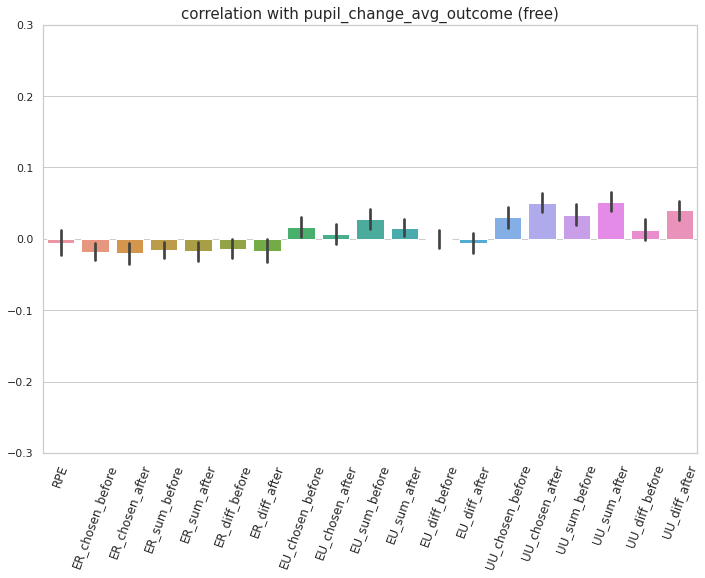

In [164]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome (free)')

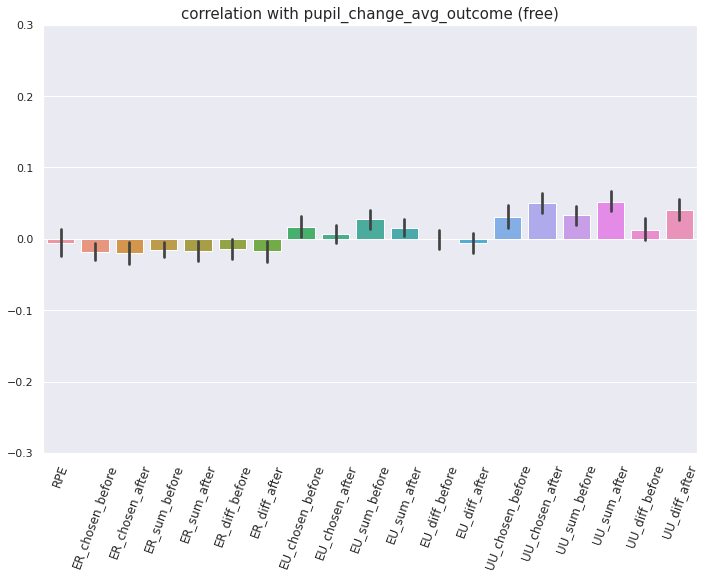

In [88]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome3 (free)')

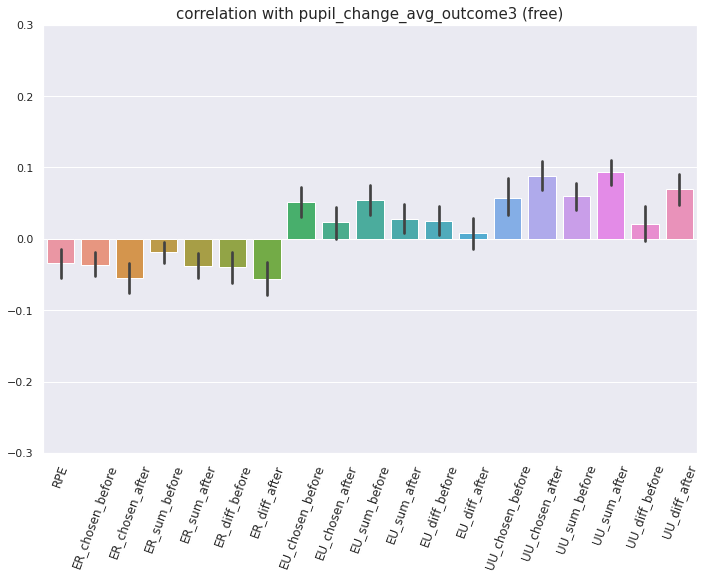

In [68]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

In [51]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]

In [52]:
tr_list_reversed.head()

rt  pupil_change_avg_pre_response  pupil_change_avg_response  \
sub1 -0.151463                            1.0                   0.486793   
sub2  0.345479                            1.0                   0.661415   
sub3 -0.070925                            1.0                   0.492986   
sub4  0.240698                            1.0                   0.673544   
sub6 -0.028516                            1.0                   0.515314   

      pupil_change_avg_outcome  pupil_change_avg_outcome_nassar  \
sub1                 -0.014981                        -0.014599   
sub2                  0.008259                        -0.054078   
sub3                  0.023384                        -0.043299   
sub4                 -0.048197                        -0.021647   
sub6                  0.015211                         0.079324   

      pupil_change_avg_outcome3  pupil_size_avg_pre_response  \
sub1                  -0.004992                     0.238558   
sub2                   0.022592                     0.508882   
sub3                   0.060224                     0.120645   
sub4                  -0.035453                     0.246411   
sub6                   0.049962                     0.195497   

      pupil_size_avg_response  pupil_size_avg_outcome       RPE  ...  \
sub1                 0.205810                0.109062 -0.038462  ...   
sub2                 0.463201                0.343775 -0.018222  ...   
sub3                 0.025220               -0.042721  0.027236  ...   
sub4                 0.300938                0.236954 -0.043852  ...   
sub6                 0.169969                0.083731 -0.006347  ...   

      outcomes  outcome_change        SD  changepoints  trial_after_forced  \
sub1 -0.006054       -0.027393 -0.041324     -0.100454           -0.087784   
sub2 -0.029242       -0.045282  0.183135      0.046120            0.000178   
sub3  0.065043        0.105108  0.049823     -0.019703            0.009566   
sub4 -0.030911        0.055241 -0.095646     -0.029573           -0.089874   
sub6  0.012911       -0.041063 -0.012334     -0.117742            0.000835   

      trial_after_cp    mean_A    mean_B  mean_chosen  mean_unchosen  
sub1        0.073755  0.022881  0.074826     0.055381       0.044481  
sub2       -0.022992  0.079605 -0.132736    -0.002238      -0.045639  
sub3       -0.013548 -0.023756  0.015249     0.062724      -0.074150  
sub4       -0.131824  0.073137  0.052123     0.028846       0.102525  
sub6        0.033829  0.118234 -0.008509     0.019431       0.096277  

[5 rows x 40 columns]


gridsize = (1,1)
fig = plt.figure(figsize=(15, 10))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.3,0.3])
plt.tight_layout()

Text(0.5, 1.0, 'free trials')

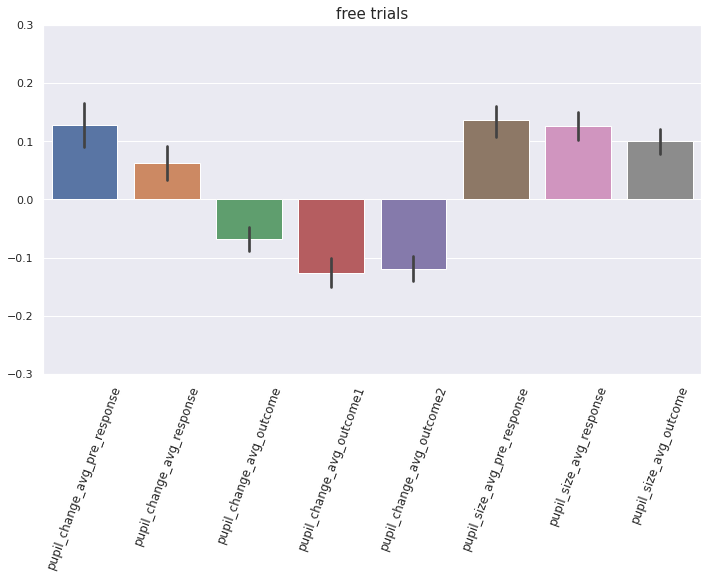

In [86]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title('free trials', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'free trials, correlation with rt')

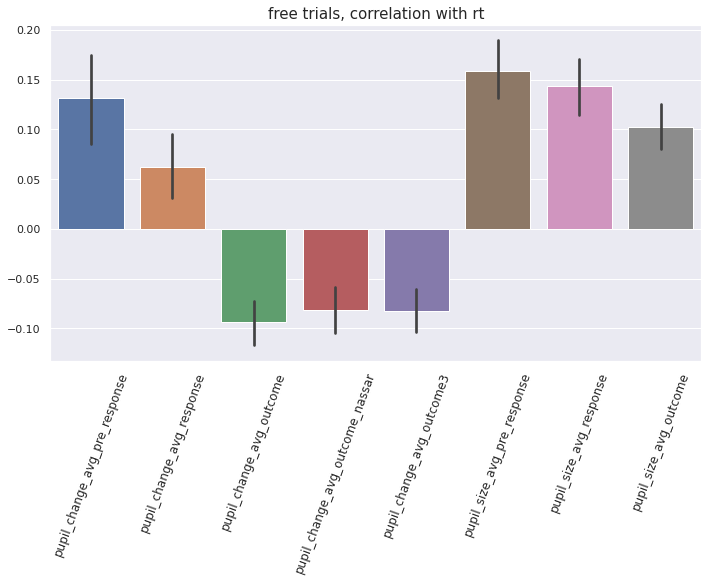

In [62]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
#plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'free trials, correlation with {key_to_plot}', fontsize=15)

Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome1 (free trials, <=5 trials after cp)')

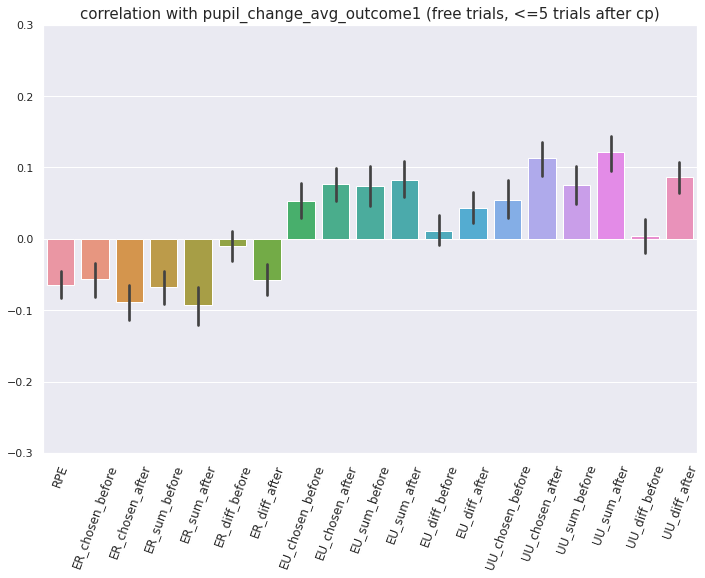

In [183]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free trials, <=5 trials after cp)', fontsize=15)

In [87]:
pval_to_plot = pval_list.T[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
pval_to_plot.mean()

pupil_change_avg_pre_response    0.095479
pupil_change_avg_response        0.131292
pupil_change_avg_outcome         0.238635
pupil_change_avg_outcome1        0.130798
pupil_change_avg_outcome2        0.156011
pupil_size_avg_pre_response      0.131510
pupil_size_avg_response          0.144037
pupil_size_avg_outcome           0.177220
dtype: float64

In [89]:
import numpy as np
from scipy import stats

for i in range(len(to_plot_tr.columns)):
    to_ttest = to_plot_tr[to_plot_tr.columns[i]]
    ss, pp = stats.ttest_1samp(to_ttest, popmean=0)
    print(pp)

6.786616825268175e-08
0.00040262533162803096
2.5080295986600712e-08
9.837510448293294e-15
5.0888945704937343e-14
1.2156574062609028e-12
7.728677349154862e-14
1.1673759480646024e-12


In [62]:
rt_list.T.head()

rt  pupil_change_avg_pre_response  pupil_change_avg_response  \
sub1  1.0                       0.113628                  -0.032447   
sub2  1.0                       0.094841                  -0.012108   
sub3  1.0                       0.088718                  -0.075655   
sub4  1.0                       0.019421                   0.060390   
sub6  1.0                      -0.070576                  -0.074142   

      pupil_change_avg_outcome  pupil_size_avg_pre_response  \
sub1                 -0.028779                     0.115216   
sub2                  0.000830                     0.214720   
sub3                 -0.092255                     0.343112   
sub4                 -0.032432                     0.130201   
sub6                 -0.074925                     0.122834   

      pupil_size_avg_response  pupil_size_avg_outcome       RPE  \
sub1                 0.045970                0.027020  0.016693   
sub2                 0.172041                0.160425  0.026515   
sub3                 0.310364                0.289957  0.057896   
sub4                 0.170373                0.195668  0.049985   
sub6                 0.117858                0.092531  0.044382   

      ER_chosen_before  ER_chosen_after  ...  outcomes  outcome_change  \
sub1         -0.131794        -0.071511  ... -0.052122       -0.015988   
sub2         -0.035884        -0.028450  ...  0.005034       -0.007562   
sub3         -0.044352         0.001277  ...  0.026203        0.037448   
sub4         -0.097206        -0.049273  ... -0.009072        0.060529   
sub6         -0.071563        -0.009251  ...  0.005957        0.065675   

            SD  changepoints  trial_after_forced  trial_after_cp    mean_A  \
sub1 -0.022640     -0.043332           -0.222970        0.010722  0.028606   
sub2  0.054110     -0.001463           -0.127293       -0.061609  0.050805   
sub3 -0.004693     -0.034477           -0.234758       -0.042358  0.045377   
sub4  0.016155     -0.045772           -0.050325       -0.010375  0.034556   
sub6  0.009682      0.090027           -0.075951        0.018766 -0.018196   

        mean_B  mean_chosen  mean_unchosen  
sub1 -0.044174    -0.086364       0.070359  
sub2 -0.011147    -0.023996       0.061253  
sub3  0.077391    -0.024949       0.150908  
sub4 -0.006860    -0.052068       0.078324  
sub6  0.000914    -0.015322      -0.000882  

[5 rows x 38 columns]

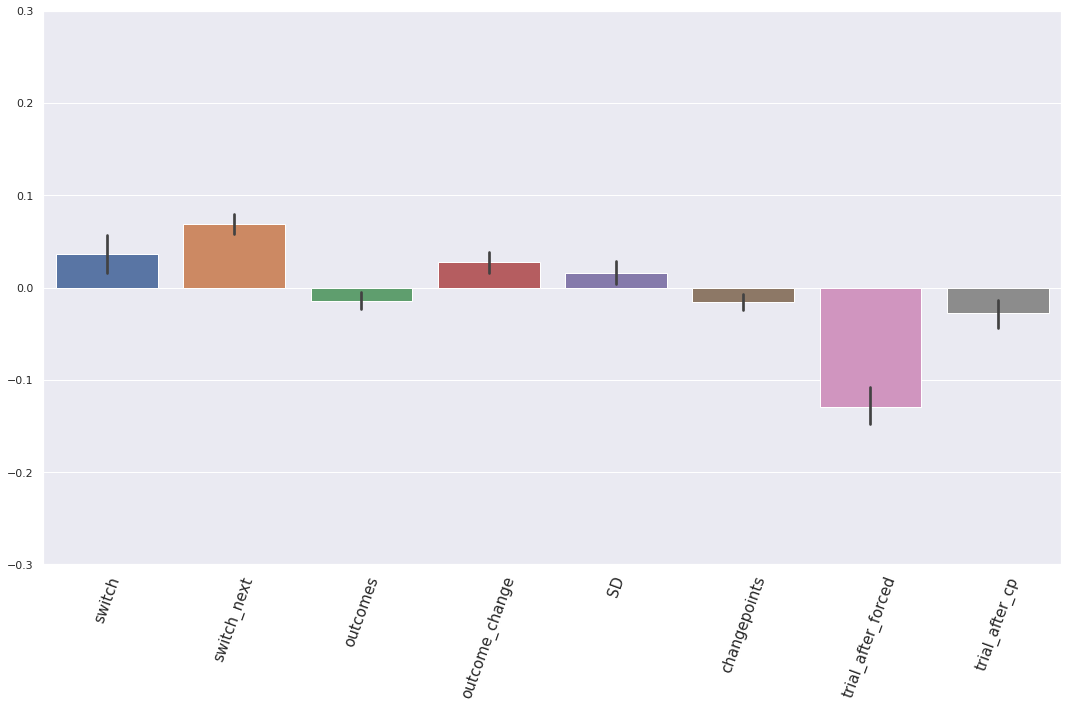

In [61]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[[   
        'switch', 'switch_next',
           'outcomes','outcome_change', 
       #'forced', 'free',
       'SD', 'changepoints', 'trial_after_forced', 'trial_after_cp']]#,
#'mean_A', 'mean_B', 'mean_chosen', 'mean_unchosen',]]


gridsize = (1,1)
fig = plt.figure(figsize=(15, 10))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.3,0.3])
plt.tight_layout()

### Find individual averages

In [90]:
joint_data_by_sub['sub1'].head()

level_0  index  trial     rt  \
0        0      0      0  0.873   
1        1      1      1  0.503   
2        2      2      2  0.948   
3        3      3      3  0.633   
4        4      4      4  1.754   

                                pupil_baseline_start  \
0  [-0.13285487334831725, -0.15435727323074105, -...   
1  [0.14530678606560862, 0.1443430154502174, 0.24...   
2  [0.22792893919942742, 0.15482785060969537, 0.1...   
3  [-0.04115643605480424, -0.011971396588699315, ...   
4  [0.7752312920948785, 0.8033788108457145, 0.831...   

                              pupil_baseline_outcome  \
0  [0.07491006887873684, 0.13786000971694218, 0.1...   
1  [0.23190501894722576, 0.17961922205809192, 0.1...   
2  [0.1730485920638111, 0.15684330963330576, 0.18...   
3  [-0.02837186777614119, 0.004751287527410095, 0...   
4  [0.467254551806917, 0.46196730826422516, 0.473...   

                             pupil_size_pre_response  \
0  [0.11437311041501608, 0.10994014858446984, 0.1...   
1  [0.34474857188501473, 0.35575292963603705, 0.3...   
2  [-0.5578585701312097, -0.5368051541620953, -0....   
3  [0.9398780279838435, 0.9354819044102489, 0.927...   
4  [0.13627293908167493, 0.0938579818830942, 0.08...   

   pupil_size_avg_pre_response  \
0                     0.279017   
1                     0.299246   
2                    -0.249000   
3                     0.780104   
4                    -0.051292   

                                 pupil_size_response  pupil_size_avg_response  \
0  [0.353667051165722, 0.39952404529320773, 0.433...                 0.475576   
1  [0.3427030080472347, 0.3527936049405821, 0.374...                 1.147825   
2  [-0.043562563000114525, -0.010950897831385292,...                -0.182329   
3  [0.6531173173194468, 0.6612715975477902, 0.646...                 0.399992   
4  [-0.1988164400882881, -0.1855046140065632, -0....                 0.438572   

   ... EU_diff_before  EU_diff_after  UU_diff_before  UU_diff_after switch  \
0  ...       0.000000      -0.117293        0.000000       0.000000  False   
1  ...      -0.117293      -0.143198        0.000000       0.000000  False   
2  ...       0.143198      -0.013064        0.000000      -0.006041   True   
3  ...      -0.013064      -0.420074       -0.006041       0.022409  False   
4  ...      -0.420074      -0.341523        0.022409      -0.011922  False   

   switch_next outcome_change  trial_after_forced trial_after_cp  sess  
0        False           48.0                   0              0   1.0  
1         True           22.0                   0              0   1.0  
2        False          -20.0                   0              0   1.0  
3        False           50.0                   0              0   1.0  
4        False          -41.0                   1              0   1.0  

[5 rows x 62 columns]

In [91]:
joint_data_by_sub['sub1'].columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

In [92]:
joint_data_temp[['pupil_size_avg_pre_response', 'pupil_change_avg_pre_response']].mean().to_numpy()

array([-0.05440561,  0.06757444])

In [93]:
joint_data_new

level_0  index  trial     rt  \
4          4      4      4  0.886   
5          5      5      5  0.524   
6          6      6      6  0.534   
7          7      7      7  0.781   
8          8      8      8  1.291   
..       ...    ...    ...    ...   
763       91     91     91  1.142   
764       92     92     92  0.316   
765       93     93     93  0.412   
766       94     94     94  0.319   
767       95     95     95  0.325   

                                  pupil_baseline_start  \
4    [0.2329468694457934, 0.2195645528616627, 0.246...   
5    [1.604212964386441, 1.6285303725867817, 1.6628...   
6    [-0.6259594067889568, -0.580431477955717, -0.5...   
7    [0.9413728981995821, 0.8963505792510152, 0.860...   
8    [0.5843384851342176, 0.5273335215865524, 0.478...   
..                                                 ...   
763  [0.67943674845904, 0.7272363341078137, 0.73705...   
764  [-0.17780774209706132, -0.13794868236501812, -...   
765  [-1.203478368664157, -1.1643138433366318, -1.1...   
766  [-1.6546526797253853, -1.6049083492062692, -1....   
767  [0.5476487169455556, 0.40803424555855716, 0.35...   

                                pupil_baseline_outcome  \
4    [1.7544874871463856, 1.7720780239957616, 1.805...   
5    [0.7685031736132147, 0.8136426641189665, 0.859...   
6    [0.2999592623031137, 0.26569563391781836, 0.30...   
7    [-0.398104164104001, -0.37839306728714694, -0....   
8    [-0.205693408226777, -0.2218313300040943, -0.2...   
..                                                 ...   
763  [0.5511960490811909, 0.5499120983188762, 0.581...   
764  [-0.8800874249291134, -0.863458312754363, -0.8...   
765  [-3.327919441521653, -3.3458417071503943, -3.3...   
766  [-0.23448572896024178, -0.11422985799373579, -...   
767  [-0.6308113880375159, -0.6443178855941037, -0....   

                               pupil_size_pre_response  \
4    [0.8322483658106244, 0.8368113607088992, 0.775...   
5    [1.6519808448121482, 1.6435078302662, 1.651376...   
6    [-0.02224315815839232, -0.04403337339354349, -...   
7    [0.4901778384479871, 0.5030240859159255, 0.560...   
8    [0.5114205969271836, 0.5018882640692223, 0.536...   
..                                                 ...   
763  [1.0707077050777225, 1.0654853260524422, 1.070...   
764  [-0.14873885096615147, -0.11531997069426185, -...   
765  [-1.1940200358695918, -1.1961699578124045, -1....   
766  [-1.558495613955596, -1.5328490750914376, -1.4...   
767  [0.41406870553831127, 0.3766595113669954, 0.35...   

     pupil_size_avg_pre_response  \
4                       0.847741   
5                       1.751446   
6                       0.359808   
7                       0.872949   
8                       0.247190   
..                           ...   
763                     1.213163   
764                     0.221271   
765                    -1.551658   
766                    -1.222526   
767                     0.228686   

                                   pupil_size_response  \
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
5    [1.7937574818611532, 1.7857466174736965, 1.757...   
6    [0.581052140277717, 0.6451061668589583, 0.6861...   
7    [1.0477415953915061, 1.065030901711759, 1.0884...   
8    [0.05178672665339497, 0.03727946032023733, -0....   
..                                                 ...   
763  [1.3801842435307121, 1.323949527624748, 1.1854...   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   
765  [-1.7172245184480575, -1.7368905531884036, -1....   
766  [-1.106845834894351, -1.1308387794174326, -1.1...   
767  [0.11716046275001123, 0.10990970946557645, 0.1...   

     pupil_size_avg_response  ... EU_diff_before  EU_diff_after  \
4                   1.237052  ...       0.367036      -0.067325   
5                   1.382578  ...      -0.067325      -0.215412   
6                   0.913374  ...      -0.215412      -0.385074   
7                   0.338019  ...      -0.385074      -0.436201   
8   

In [165]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [168]:
ind_avg_data = pd.DataFrame()


columns_to_include = ['rt','pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2','pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome', ]

param = 'RPE'
for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new[param] > 0)]
        worse_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new[param] < 0)]
        better_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new[param] > 0)]
        worse_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new[param] < 0)]
        
        #better_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
        #worse_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]
        #better_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] > 0)]
        #worse_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] < 0)]


        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        avg_data_diff = avg_data_better_stay - avg_data_better_switch
        ind_avg_data = pd.concat([ind_avg_data, avg_data_diff], axis=1)

    

ind_avg_data = ind_avg_data.T
ind_avg_data.reset_index(inplace=True)
ind_avg_data.insert(0, 'sub', valid_sub)

In [169]:
ind_avg_data.T

0         1         2         3   \
sub                            1.000000  2.000000  3.000000  4.000000   
index                          0.000000  0.000000  0.000000  0.000000   
rt                            -0.009059  0.135471  0.034861  0.082842   
pupil_change_avg_pre_response  0.000280  0.026199  0.024317 -0.011061   
pupil_change_avg_response     -0.010627  0.033781  0.016593 -0.050387   
pupil_change_avg_outcome       0.024242 -0.144786  0.001192 -0.035482   
pupil_change_avg_outcome1      0.193394 -0.168614 -0.026729 -0.035596   
pupil_change_avg_outcome2      0.135331 -0.201590 -0.060547 -0.005887   
pupil_change_avg_outcome3     -0.058063 -0.032976 -0.033819  0.029709   
pupil_size_avg_pre_response   -0.205260  0.035715 -0.023586  0.167085   
pupil_size_avg_response       -0.216167  0.043296 -0.031309  0.127759   
pupil_size_avg_outcome        -0.137674  0.009847  0.005805 -0.007907   

                                     4         5          6          7   \
sub                            6.000000  8.000000  10.000000  11.000000   
index                          0.000000  0.000000   0.000000   0.000000   
rt                             0.213517  0.005917  -0.038783  -0.015934   
pupil_change_avg_pre_response -0.061072 -0.031508   0.024395   0.000440   
pupil_change_avg_response     -0.124567  0.009871   0.054564  -0.011912   
pupil_change_avg_outcome       0.020455 -0.014219   0.040558   0.040609   
pupil_change_avg_outcome1     -0.076227 -0.229123   0.116391   0.041474   
pupil_change_avg_outcome2     -0.093607 -0.269003   0.131891   0.126356   
pupil_change_avg_outcome3     -0.017380 -0.039880   0.015500   0.084882   
pupil_size_avg_pre_response    0.104706  0.108275  -0.156489  -0.038876   
pupil_size_avg_response        0.041210  0.149654  -0.126320  -0.051228   
pupil_size_avg_outcome         0.155673  0.225066  -0.086424  -0.013506   

                                      8          9   ...         41  \
sub                            12.000000  13.000000  ...  51.000000   
index                           0.000000   0.000000  ...   0.000000   
rt                              0.157028   0.044121  ...   0.102523   
pupil_change_avg_pre_response  -0.051774   0.009653  ...   0.013941   
pupil_change_avg_response      -0.105433   0.051160  ...   0.067184   
pupil_change_avg_outcome       -0.062320  -0.065289  ...   0.071874   
pupil_change_avg_outcome1       0.258281  -0.100693  ...   0.094499   
pupil_change_avg_outcome2       0.164765  -0.153963  ...   0.148252   
pupil_change_avg_outcome3      -0.093516  -0.053269  ...   0.053753   
pupil_size_avg_pre_response    -0.250977   0.024607  ...  -0.229185   
pupil_size_avg_response        -0.304637   0.066114  ...  -0.175942   
pupil_size_avg_outcome         -0.280776  -0.016772  ...   0.009052   

                                      42         43         44         45  \
sub                            52.000000  53.000000  54.000000  55.000000   
index                           0.000000   0.000000   0.000000   0.000000   
rt                              0.094179  -0.034281   0.088000   0.060371   
pupil_change_avg_pre_response   0.071010   0.095851   0.047668   0.045390   
pupil_change_avg_response       0.116589  -0.017374   0.084686   0.091312   
pupil_change_avg_outcome       -0.010161  -0.106043   0.193365   0.071121   
pupil_change_avg_outcome1      -0.046926  -0.060580   0.157330  -0.122753   
pupil_change_avg_outcome2      -0.044575  -0.236000   0.350849  -0.034305   
pupil_change_avg_outcome3       0.002351  -0.175420   0.193519   0.088449   
pupil_size_avg_pre_response    -0.115972   0.088687  -0.080110   0.053493   
pupil_size_avg_response        -0.070393  -0.024538  -0.043091   0.099415   
pupil_size_avg_outcome          0.003657  -0.095624   0.091334   0.224442   

                                      46         47         48         49  \
sub                            56.000000  57.000000  58.000000  59.000000   
index                          

In [156]:
#ind_avg_data

In [157]:
# import psychiatric data

psychiatric_data = pd.read_csv('psychiatric_data_use.csv')
psychiatric_data

Unnamed: 0 Subj number  WFRIS_family  WFRIS_work  WFRIS_school  \
0            0           1      1.000000   13.000000      6.000000   
1            1           2      2.000000    0.000000      2.000000   
2            2           3      1.000000    0.000000      0.000000   
3            3           4      2.000000   14.000000     11.000000   
4            4           5      0.000000    0.000000      1.000000   
..         ...         ...           ...         ...           ...   
58          58          59     11.000000   10.000000      0.000000   
59          59          60      3.000000    6.000000      5.000000   
60          60        Mean      3.440678    3.559322      3.881356   
61          61      Median      3.000000    2.000000      2.000000   
62          62         Std      2.890360    4.304253      4.694401   

    WFRIS_life skills  WFRIS_self-concept  WFRIS_social  WFRIS_risk  \
0           15.000000           14.000000      5.000000    7.000000   
1            5.000000            3.000000      6.000000    3.000000   
2            2.000000            0.000000      0.000000    2.000000   
3           12.000000            2.000000      3.000000    6.000000   
4            2.000000            1.000000      3.000000    0.000000   
..                ...                 ...           ...         ...   
58          19.000000            8.000000      8.000000    4.000000   
59           5.000000           10.000000      3.000000    3.000000   
60           7.542373            4.661017      4.457627    3.406780   
61           7.000000            4.000000      3.000000    2.000000   
62           5.733513            3.835452      3.779810    3.695844   

    WFRIS_total  ...  BIS11_cognitive impulsiveness  BIS11_total     SHAPS  \
0     61.000000  ...                      17.000000    70.000000  2.000000   
1     21.000000  ...                      21.000000    63.000000  4.000000   
2      5.000000  ...                      19.000000    65.000000  1.000000   
3     50.000000  ...                      16.000000    53.000000  0.000000   
4      7.000000  ...                      12.000000    52.000000  0.000000   
..          ...  ...                            ...          ...       ...   
58    60.000000  ...                      16.000000    54.000000  1.000000   
59    35.000000  ...                      14.000000    41.000000  0.000000   
60    30.949153  ...                      17.271186    61.152542  1.372881   
61    30.000000  ...                      16.000000    61.000000  1.000000   
62    20.554741  ...                       3.872229     9.468302  1.659854   

           AQ        SPQ  BIG5_extraversion  BIG5_agreeableness  \
0   33.000000  25.000000          16.000000           33.000000   
1   32.000000  19.000000          26.000000           29.000000   
2   32.000000   1.000000          40.000000           47.000000   
3   36.000000  12.000000          35.000000           33.000000   
4   43.000000   7.000000          28.000000           39.000000   
..        ...        ...                ...                 ...   
58  37.000000  20.000000          30.000000           45.000000   
59  25.000000  27.000000          34.000000           45.000000   
60  33.423729  18.542373          28.220339           40.084746   
61  33.000000  18.000000          29.000000           41.000000   
62   5.540457  13.012358           7.640788            5.193790   

    BIG5_conscientiousness  BIG5_neuroticism  BIG5_openness  
0                20.000000         11.000000      40.000000  
1                36.000000         21.000000      32.000000  
2                40.000000          9.000000      35.000000  
3                37.000000         19.000000      29.000000  
4                41.000000         13.000000      25.000000  
..                     ...               ...            ...  
58               35.000000         16.000000      36.000000  
59               32.000000         25.000000      45.000000  
60        

In [170]:
psychiatric_data.columns

Index(['Unnamed: 0', 'Subj number', 'WFRIS_family', 'WFRIS_work',
       'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
       'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness'],
      dtype='object')

In [171]:
psychiatric_data_use = psychiatric_data[:60]
psychiatric_data_use['sub'] = psychiatric_data_use['Subj number'].astype(int)

/tmp/ipykernel_87/282913640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psychiatric_data_use['sub'] = psychiatric_data_use['Subj number'].astype(int)


In [172]:
psychiatric_data_filtered = psychiatric_data_use.loc[psychiatric_data_use['sub'].isin(valid_sub)]
psychiatric_data_filtered.reset_index(inplace=True)
#psychiatric_data_filtered

In [173]:
combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
#combined_data

In [174]:
combined_data.columns

Index(['sub', 'index', 'rt', 'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome',
       'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_change_avg_outcome3', 'pupil_size_avg_pre_response',
       'pupil_size_avg_response', 'pupil_size_avg_outcome', 'index',
       'Unnamed: 0', 'Subj number', 'WFRIS_family', 'WFRIS_work',
       'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
       'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness', 'sub'],
      dtype='object')

In [163]:
corr_columns = ['rt', 'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']



In [164]:
from scipy.stats import pearsonr

corr_columns = ['rt', 'outcome','pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                 'pupil_change_prev', 'pupil_change1_prev', 'pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome','pupil_size_prev',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

KeyError: "['outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2', 'pupil_change_prev', 'pupil_change1_prev', 'pupil_change2_prev', 'pupil_size_prev'] not in index"

In [214]:
mxx = rho.round(2).astype(str) + p
#mxx.iloc[7:]

In [215]:
mxx = rho.round(2).astype(str) + p


old_names = mxx.columns
new_names = ['rt', 'change_pre_response', 'change_post_response',
       'change_outcome', 'size_pre_response',
       'size_post_response', 'size_outcome', 'WFRIS_family',
       'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
       'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness']


In [216]:


mxx.rename(columns=dict(zip(old_names, new_names)), inplace=True)
mxx.iloc[7:]

rt change_pre_response change_post_response  \
WFRIS_family                   -0.17                0.12                 0.16   
WFRIS_work                      0.09                0.14                 0.3*   
WFRIS_school                   -0.05                0.03                  0.2   
WFRIS_life skills               0.04                0.05                 0.27   
WFRIS_self-concept             -0.11                0.19                0.34*   
WFRIS_social                   -0.21                0.07                 0.17   
WFRIS_risk                     -0.02               -0.01                 0.21   
WFRIS_total                    -0.07                0.11                0.34*   
STAI-Y_A                       -0.19                0.09                 0.21   
STAI-Y_B                       -0.03                 0.1                 0.25   
Lot R                           0.13               -0.13                -0.18   
BIS11_planning difficulties     0.01                0.3*                 0.25   
BIS11_motor impulsiveness       0.03                0.22                 0.18   
BIS11_cognitive impulsiveness   0.01                0.01                 0.03   
BIS11_total                     0.02                0.23                  0.2   
SHAPS                           0.13               -0.05                 0.02   
AQ                              0.08               -0.15               -0.32*   
SPQ                            -0.01                0.12                 0.14   
BIG5_extraversion               0.05               -0.01                 -0.2   
BIG5_agreeableness              0.01                0.07                 0.09   
BIG5_conscientiousness          0.02               -0.15                -0.24   
BIG5_neuroticism               -0.23                0.07                  0.2   
BIG5_openness                   0.19                0.15                -0.07   

                              change_outcome size_pre_response  \
WFRIS_family                            0.07             -0.06   
WFRIS_work                              0.09              0.11   
WFRIS_school                            0.06             -0.25   
WFRIS_life skills                       0.04             -0.02   
WFRIS_self-concept                      0.14             -0.12   
WFRIS_social                            0.09             -0.03   
WFRIS_risk                              0.14              0.04   
WFRIS_total                             0.12             -0.07   
STAI-Y_A                                0.09             -0.17   
STAI-Y_B                                 0.2             -0.3*   
Lot R                                  -0.12              0.21   
BIS11_planning difficulties            0.32*              0.02   
BIS11_motor impulsiveness               0.14              0.03   
BIS11_cognitive impulsiveness          -0.01             -0.09   
BIS11_total                             0.19             -0.01   
SHAPS                                  -0.07              -0.1   
AQ                                     -0.13              0.06   
SPQ                                     0.02             -0.05   
BIG5_extraversion                      -0.12              0.07   
BIG5_agreeableness                      0.05              0.21   
BIG5_conscientiousness                 -0.11              0.14   
BIG5_neuroticism                        0.22             -0.24   
BIG5_openness                          -0.04              0.01   

                              size_post_response size_outcome WFRIS_family  \
WFRIS_family                               -0.02        -0.07       1.0***   
WFRIS_work                                  0.23         0.13         0.17   
WFRIS_school                               -0.15        -0.25       0.41**   
WFRIS_life skills                           0.12        -0.01      0.49***   
WFRIS_self-concept                         -0.01        -0.12      0.45***   
WFRIS_social                        

In [121]:
joint_data_sample = joint_data_by_sub['sub1']
joint_data_sample

level_0  index  trial     rt  \
0          0      0      0  0.873   
1          1      1      1  0.503   
2          2      2      2  0.948   
3          3      3      3  0.633   
4          4      4      4  1.754   
..       ...    ...    ...    ...   
763       91     91     91  1.292   
764       92     92     92  0.373   
765       93     93     93  0.350   
766       94     94     94  0.354   
767       95     95     95  0.869   

                                  pupil_baseline_start  \
0    [-0.13285487334831725, -0.15435727323074105, -...   
1    [0.14530678606560862, 0.1443430154502174, 0.24...   
2    [0.22792893919942742, 0.15482785060969537, 0.1...   
3    [-0.04115643605480424, -0.011971396588699315, ...   
4    [0.7752312920948785, 0.8033788108457145, 0.831...   
..                                                 ...   
763  [0.9440574455329321, 0.9797740013763789, 1.000...   
764  [1.168299084483247, 1.1670923863513962, 1.1944...   
765  [0.5128540402488411, 0.5474079431799694, 0.595...   
766  [0.06467445175805148, 0.06351523679661694, 0.0...   
767  [0.21963240403148176, 0.254590242586763, 0.227...   

                                pupil_baseline_outcome  \
0    [0.07491006887873684, 0.13786000971694218, 0.1...   
1    [0.23190501894722576, 0.17961922205809192, 0.1...   
2    [0.1730485920638111, 0.15684330963330576, 0.18...   
3    [-0.02837186777614119, 0.004751287527410095, 0...   
4    [0.467254551806917, 0.46196730826422516, 0.473...   
..                                                 ...   
763  [-0.2881632675597719, -0.2400962148296614, -0....   
764  [0.9511351459807956, 0.9523740032809924, 0.954...   
765  [1.0246539725728203, 1.0375120549738277, 1.049...   
766  [-0.6962144444896675, -0.6686769003726343, -0....   
767  [-0.015925371036347818, 0.01822542730157159, 0...   

                               pupil_size_pre_response  \
0    [0.11437311041501608, 0.10994014858446984, 0.1...   
1    [0.34474857188501473, 0.35575292963603705, 0.3...   
2    [-0.5578585701312097, -0.5368051541620953, -0....   
3    [0.9398780279838435, 0.9354819044102489, 0.927...   
4    [0.13627293908167493, 0.0938579818830942, 0.08...   
..                                                 ...   
763  [1.0870597990222244, 1.0612094153744953, 1.048...   
764  [1.4614223571061273, 1.5293144197778896, 1.550...   
765  [0.6125205116700386, 0.6285798356603844, 0.644...   
766  [-0.1359992371571531, -0.16171914755336544, -0...   
767  [0.805226660525375, 0.8060359610356735, 0.8060...   

     pupil_size_avg_pre_response  \
0                       0.279017   
1                       0.299246   
2                      -0.249000   
3                       0.780104   
4                      -0.051292   
..                           ...   
763                     1.108661   
764                     2.093780   
765                     0.731417   
766                    -0.317786   
767                     0.810774   

                                   pupil_size_response  \
0    [0.353667051165722, 0.39952404529320773, 0.433...   
1    [0.3427030080472347, 0.3527936049405821, 0.374...   
2    [-0.043562563000114525, -0.010950897831385292,...   
3    [0.6531173173194468, 0.6612715975477902, 0.646...   
4    [-0.1988164400882881, -0.1855046140065632, -0....   
..                                                 ...   
763  [1.1411791340983253, 1.0926622014125866, 1.073...   
764  [2.4096743256709146, 2.495328107614667, 2.5140...   
765  [0.7648195837852088, 0.7834854352008632, 0.793...   
766  [-0.3805532585940814, -0.42342857433207653, -0...   
767  [0.8137656023951827, 0.8130993982162574, 0.814...   

     pupil_size_avg_response  ... EU_diff_before  EU_diff_after  \
0                   0.475576  ...       0.000000      -0.117293   
1                   1.147825  ...      -0.117293      -0.143198   
2                  -0.182329  ...       0.143198      -0.013064   
3                   0.399992  ...      -0.013064      -0.420074   
4   

In [74]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_sum_before', 'UU_sum_after', 'ER_diff_before',
       'ER_diff_aft

In [122]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [85]:
joint_data_sample 

array([  0.,  58.,  21., -69.,   2.,  71.,  -9.,  18., -12., -16.,  20.,
       -17., -38.,  71., -30.,  -4.,  -1.,  31., -15., -58.,  42.,  15.,
       -21.,  -8.,  25., -10.,  -9.,  20., -34.,  29., -26.,   7.,  25.,
       -12., -27.,  13., -13.,  22., -13.,  -8.,   2.,  13., -16.,  23.,
        -5., -18.,  23., -34.,  28.,  12., -19., -31.,  22.,   1.,  11.,
       -10.,   8., -29.,  47.,  -6.,  16., -60.,  63., -56.,  28.,  12.,
        -6.,  21.,  -5.,   5.,   1., -24.,   6.,   8.,  18., -43., -10.,
        18.,  12., -50.,  34., -10.,  16.,   1., -26.,  18., -27.,  13.,
         4., -14.,  24.,  -8.,  -7.,   3., -25.,  16.,  -6.,  48.,  22.,
       -20.,  50., -41.,  19.,  -8., -11., -14.,  55., -36.,  -3.,  14.,
       -65.,  15.,  10.,  -2.,  -1.,  12.,  21.,   4., -20.,  13., -19.,
        10.,   4.,  43., -49.,  49., -34.,  -9.,   1.,  33., -36., -29.,
        36., -20.,  -3.,  42., -30.,  -4., -26.,  13., -18.,  26., -10.,
         0.,  14., -10.,   7.,  -2.,  -6., -18.,  2

p_stay = len(joint_data_free[(joint_data_free['switch'] == False)]) / len(joint_data_free)

    joint_data_better_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['outcome_change_prev'] > 0)]

    joint_data_better_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['outcome_change_prev'] > 0)]
    
    
    joint_data_worse_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['outcome_change_prev'] < 0)]

    joint_data_worse_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['outcome_change_prev'] < 0)]
    
    
    joint_data_betterRPE_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['RPE_prev'] > 0)]
    
    joint_data_betterRPE_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['RPE_prev'] > 0)]


In [198]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_sum_before', 'UU_sum_after', 'ER_diff_before',
       'ER_diff_aft

In [175]:

p_stay_list = []
p_stay_better_list = []
p_switch_worse_list = []

p_stay_betterRPE_list = []


for sub in valid_sub-1:
    
    outcome_change_prev = joint_data_by_sub[f'sub{sub+1}']['outcome_change'].to_numpy()
    RPE_prev = joint_data_by_sub[f'sub{sub+1}']['RPE'].to_numpy()


    
    joint_data_by_sub[f'sub{sub+1}']['outcome_change_prev'] = np.insert(outcome_change_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['RPE_prev'] = np.insert(RPE_prev, 0, 0)[0:-1]

    joint_data_by_sub[f'sub{sub+1}']['trial_num'] = joint_data_by_sub[f'sub{sub+1}']['trial'].iloc[:,0].to_numpy()
    
    # get the pupil metric to the outcome of the previous trial
    pupil_change_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome'].to_numpy()
    
    pupil_change1_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome3'].to_numpy()
    pupil_change2_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome2'].to_numpy()
    
    pupil_size_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_size_avg_outcome'].to_numpy()

    joint_data_by_sub[f'sub{sub+1}']['pupil_change_prev'] = np.insert(pupil_change_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['pupil_change1_prev'] = np.insert(pupil_change1_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['pupil_change2_prev'] = np.insert(pupil_change2_prev, 0, 0)[0:-1]

    joint_data_by_sub[f'sub{sub+1}']['pupil_size_prev'] = np.insert(pupil_size_prev, 0, 0)[0:-1]

    
    type_use = 'RPE_before'# 'outcome_change_prev'
    
    joint_data_sample = joint_data_by_sub[f'sub{sub+1}']

    joint_data_by_sub[f'sub{sub+1}']['better_stay'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == False) \
                                        & (joint_data_sample[type_use] > 0)
    
    joint_data_by_sub[f'sub{sub+1}']['better_switch'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == True) \
                                        & (joint_data_sample[type_use] > 0)
    
    joint_data_by_sub[f'sub{sub+1}']['worse_stay'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == False) \
                                        & (joint_data_sample[type_use] < 0)
    
    joint_data_by_sub[f'sub{sub+1}']['worse_switch'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == True) \
                                        & (joint_data_sample[type_use] < 0)
    
    joint_data_sample = joint_data_by_sub[f'sub{sub+1}']

    joint_data_free = joint_data_sample[(joint_data_sample['free'] == True) & (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0)]
    
    
    count_stay = len(joint_data_sample[joint_data_sample['switch']==False])
    count_switch = len(joint_data_sample[joint_data_sample['switch']==True])
    
    count_better_stay = len(joint_data_sample[joint_data_sample['better_stay']==True])
    count_better_switch = len(joint_data_sample[joint_data_sample['better_switch']==True])
    count_worse_stay = len(joint_data_sample[joint_data_sample['worse_stay']==True])
    count_worse_switch = len(joint_data_sample[joint_data_sample['worse_switch']==True])

    p_stay = count_stay / (count_stay + count_switch)
    p_stay_better = count_better_stay / (count_better_stay + count_better_switch)
    p_switch_worse = count_worse_switch / (count_worse_stay + count_worse_switch)
    
    #p_stay_betterRPE = len(joint_data_betterRPE_stay_next) / (len(joint_data_betterRPE_stay_next) + len(joint_data_betterRPE_switch_next))

        
    p_stay_list.append(p_stay)
    p_stay_better_list.append(p_stay_better)
    p_switch_worse_list.append(p_switch_worse)

    #p_stay_betterRPE_list.append(p_stay_betterRPE)

    
    
    

In [176]:
joint_data_sample[['pupil_size_avg_outcome', 'pupil_size_prev']]

pupil_size_avg_outcome  pupil_size_prev
0                  0.579217         0.000000
1                  0.368478         0.579217
2                  0.332831         0.368478
3                 -0.010414         0.332831
4                  1.437981        -0.010414
..                      ...              ...
763                0.080399         0.197545
764               -0.824728         0.080399
765               -2.879272        -0.824728
766                0.440321        -2.879272
767                0.011459         0.440321

[768 rows x 2 columns]

In [127]:
joint_data_sample[(joint_data_sample['better_stay']==False) & (joint_data_sample['better_switch']==False)
                 & (joint_data_sample['worse_switch']==False)& (joint_data_sample['worse_stay']==False)][['trial','trial_num','switch','outcome_change_prev','better_stay', 'better_switch', 'worse_stay', 'worse_switch']]

trial  trial  trial  trial_num  switch  outcome_change_prev  better_stay  \
0        0      0      0          0   False                  0.0        False   
95      95     95     95         95   False                 16.0        False   
96       0      0      0          0   False                 -6.0        False   
143     47     47     47         47    True                  0.0        False   
191     95     95     95         95   False                -11.0        False   
192      0      0      0          0   False                -22.0        False   
267     75     75     75         75    True                  0.0        False   
287     95     95     95         95    True                -43.0        False   
288      0      0      0          0   False                 34.0        False   
383     95     95     95         95    True                -35.0        False   
384      0      0      0          0   False                 15.0        False   
401     17     17     17         17   False                  0.0        False   
436     52     52     52         52    True                  0.0        False   
479     95     95     95         95   False                 16.0        False   
480      0      0      0          0   False                -20.0        False   
573     93     93     93         93   False                  0.0        False   
575     95     95     95         95   False                -43.0        False   
576      0      0      0          0   False                 30.0        False   
599     23     23     23         23   False                  0.0        False   
665     89     89     89         89    True                  0.0        False   
671     95     95     95         95    True                 -1.0        False   
672      0      0      0          0   False                  4.0        False   
683     11     11     11         11    True                  0.0        False   
767     95     95     95         95    True                 -6.0        False   

     better_switch  worse_stay  worse_switch  
0            False       False         False  
95           False       False         False  
96           False       False         False  
143          False       False         False  
191          False       False         False  
192          False       False         False  
267          False       False         False  
287          False       False         False  
288          False       False         False  
383          False       False         False  
384          False       False         False  
401          False       False         False  
436          False       False         False  
479          False       False         False  
480          False       False         False  
573          False       False         False  
575          False       False         False  
576          False       False         False  
599          False       False         False  
665          False       False         False  
671          False       False         False  
672          False       False         False  
683          False       False         False  
767          False       False         False

In [128]:
len(joint_data_sample[joint_data_sample['better_stay']==True])

230

In [129]:
joint_data_sample[(joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 1) \
                                        & (joint_data_sample['switch'] != False) \
                                        & (joint_data_sample['outcome_change_prev'] > 0)]

level_0  index  trial     rt  \
2          2      2      2  1.203   
4          4      4      4  0.886   
27        27     27     27  0.642   
31        31     31     31  0.615   
35        35     35     35  0.708   
..       ...    ...    ...    ...   
745       73     73     73  0.451   
748       76     76     76  2.434   
758       86     86     86  0.598   
761       89     89     89  0.371   
764       92     92     92  0.316   

                                  pupil_baseline_start  \
2    [0.4531594955862836, 0.4505523408239858, 0.446...   
4    [0.2329468694457934, 0.2195645528616627, 0.246...   
27   [0.02261084870665378, -0.023254154854324274, -...   
31   [0.11473107798638359, 0.15283115317537646, 0.2...   
35   [-0.3463926227923771, -0.3351403589966595, -0....   
..                                                 ...   
745  [-0.42124030890556785, -0.3924831788122247, -0...   
748  [-2.029297499246671, -2.0520412685003135, -2.0...   
758  [1.301689648930328, 1.3003937351656363, 1.2651...   
761  [-0.485044421639659, -0.5115325563619343, -0.5...   
764  [-0.17780774209706132, -0.13794868236501812, -...   

                                pupil_baseline_outcome  \
2    [-0.9279685749872779, -0.9453852131180074, -0....   
4    [1.7544874871463856, 1.7720780239957616, 1.805...   
27   [0.6514926881418729, 0.6288485990192717, 0.588...   
31   [0.6585428168867095, 0.6714793120415579, 0.714...   
35   [0.2241058116270773, 0.1940510336980334, 0.199...   
..                                                 ...   
745  [0.2668059397274902, 0.33007246885890357, 0.38...   
748  [-0.7558212455730424, -0.8017017656366395, -0....   
758  [0.4783972688777162, 0.5042829714393285, 0.631...   
761  [-1.5698361994717902, -1.5779274673780714, -1....   
764  [-0.8800874249291134, -0.863458312754363, -0.8...   

                               pupil_size_pre_response  \
2    [0.8564177916882505, 0.874603580597752, 0.9877...   
4    [0.8322483658106244, 0.8368113607088992, 0.775...   
27   [-0.05858630333605026, 0.057602298135696804, 0...   
31   [0.2863503839162331, 0.30765245608936487, 0.35...   
35   [0.038566493652019466, 0.06599456429956443, 0....   
..                                                 ...   
745  [-0.13425768855049575, -0.11241475769981156, -...   
748  [-2.8379917439795195, -2.8562408324362787, -2....   
758  [1.271016329219027, 1.2959310284525343, 1.2989...   
761  [-0.4747737521193888, -0.5273587698710426, -0....   
764  [-0.14873885096615147, -0.11531997069426185, -...   

     pupil_size_avg_pre_response  \
2                       0.664230   
4                       0.847741   
27                      0.382222   
31                      0.401638   
35                      0.249619   
..                           ...   
745                     0.123735   
748                    -3.039377   
758                     1.405407   
761                    -0.650019   
764                     0.221271   

                                   pupil_size_response  \
2    [0.4956462720515597, 0.4535649306316723, 0.427...   
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
27   [0.5924411252601872, 0.6331089091105082, 0.654...   
31   [0.499313372305734, 0.5210353395154148, 0.5096...   
35   [0.31686309636656274, 0.27166061050016593, 0.2...   
..                                                 ...   
745  [0.24220805175989613, 0.23668509907445082, 0.2...   
748  [-3.1131147071627177, -3.088987256868641, -3.0...   
758  [1.465657152814689, 1.4790426495361841, 1.4968...   
761  [-0.6356435867859622, -0.6386271811879006, -0....   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   

     pupil_size_avg_response  ...   RPE_prev  trial_num  pupil_change_prev  \
2                  -0.219130  ...  29.000000          2           0.207795   
4                   1.237052  ... -23.885477          4           0.722605   
27                  0.608170  ...  20.766570         27           0.173214   
31                  0.64000

In [130]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [131]:
ind_avg_data = pd.DataFrame()


columns_to_include = ['rt','outcomes','pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome','pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                      'pupil_change_prev','pupil_change1_prev','pupil_change2_prev',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome','pupil_size_prev']

for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
        worse_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]
        better_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] > 0)]
        worse_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] < 0)]

        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        avg_data_diff = avg_data_better_stay - avg_data_better_switch
        ind_avg_data = pd.concat([ind_avg_data, avg_data_free], axis=1)

    

ind_avg_data = ind_avg_data.T
ind_avg_data.reset_index(inplace=True)
ind_avg_data.insert(0, 'sub', valid_sub)

In [132]:
ind_avg_data['p(stay)'] = p_stay_list
ind_avg_data['p(stay|better)'] = p_stay_better_list
ind_avg_data['p(switch|worse)'] = p_switch_worse_list

#ind_avg_data['p(stay|betterRPE)'] = p_stay_betterRPE_list

In [133]:
ind_avg_data

sub  index        rt   outcomes  pupil_change_avg_pre_response  \
0     1      0  0.543840  52.806641                       0.118939   
1     2      0  0.623373  52.539062                       0.161372   
2     3      0  0.469328  53.687500                       0.091268   
3     4      0  0.710707  55.023438                      -0.034321   
4     6      0  0.592437  50.519531                       0.039569   
5     8      0  0.469502  54.509766                       0.072407   
6    10      0  0.689561  51.873047                       0.079951   
7    11      0  0.755799  50.226562                      -0.056273   
8    12      0  0.811582  54.996094                       0.074630   
9    13      0  0.627572  50.646484                       0.044564   
10   14      0  1.077141  52.058594                      -0.040470   
11   16      0  0.940910  55.767578                       0.145613   
12   19      0  0.557438  55.263672                       0.102370   
13   20      0  1.101398  54.681641                       0.110398   
14   21      0  0.697732  53.160156                       0.025711   
15   22      0  1.073533  52.878906                       0.007032   
16   23      0  0.811055  54.417969                       0.137869   
17   24      0  1.001895  52.207589                       0.031686   
18   25      0  0.643586  54.322266                      -0.021191   
19   26      0  0.622648  55.507812                       0.007486   
20   27      0  0.690348  54.560547                      -0.023293   
21   28      0  0.858912  53.861328                       0.114921   
22   29      0  0.796511  55.189824                       0.066713   
23   30      0  0.538146  55.751953                       0.104083   
24   31      0  0.810787  53.900391                       0.064281   
25   32      0  0.981701  53.457031                      -0.015459   
26   33      0  0.819227  55.277344                       0.142278   
27   34      0  1.360167  55.437500                       0.080089   
28   35      0  0.895207  54.099609                       0.021628   
29   36      0  0.721818  54.521484                       0.085947   
30   37      0  0.876260  51.912109                      -0.011002   
31   38      0  0.632395  54.988281                       0.067973   
32   39      0  0.790246  54.863281                       0.063789   
33   40      0  0.662578  54.144531                       0.060295   
34   41      0  0.851256  53.474609                      -0.079851   
35   43      0  0.708393  52.929688                       0.307517   
36   44      0  0.653344  54.785156                       0.194365   
37   45      0  0.860439  54.314453                       0.135194   
38   47      0  0.585002  55.304688                       0.160253   
39   48      0  0.786471  54.408203                       0.145067   
40   49      0  0.618828  54.148438                       0.041384   
41   50      0  0.662783  55.419922                       0.068533   
42   51      0  0.776687  53.150391                      -0.020965   
43   52      0  0.513607  54.990234                       0.027489   
44   53      0  0.515381  54.685547                      -0.036427   
45   54      0  0.719752  54.671875                      -0.079765   
46   55      0  0.998500  54.531250                       0.019907   
47   56      0  0.665592  51.595703                       0.038511   
48   57      0  0.601154  53.503906                       0.098193   
49   58      0  0.456959  55.109375                       0.028998   
50   59      0  0.628467  54.767578                       0.056439   
51   60      0  0.697846  54.066406                       0.067136   

    pupil_change_avg_response  pupil_change_avg_outcome  \
0                    0.082651                  0.007679   
1                    0.120747                 -0.028952   
2                   -0.023193                 -0.031308   
3                   -0.074874                  0.012703  

In [148]:
combined_data_new = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)

In [ ]:
df.sort_values(combined_data_new)

In [149]:
from scipy.stats import pearsonr

corr_columns = ['rt', 
                'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2', 
                'pupil_change_prev','pupil_change1_prev','pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome', 'pupil_size_prev',
                'rt','outcomes', 'p(stay)','p(stay|better)','p(switch|worse)']#,
       #'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       #'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       #'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       #'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       #'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       #'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       #'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

mxx = rho.round(2).astype(str) + p


old_names = mxx.columns
new_names = ['rt',
             'change_pre_response', 'change_post_response',
       'change_outcome','change_outcome1', 'change_outcome2',
             'change_outcome_prev_trial', 'change_outcome1_prev_trial','change_outcome2_prev_trial',
             
             'size_pre_response',  'size_post_response', 'size_outcome',  'size_outcome_prev_trial',
              'rt','outcomes', 'p(stay)','p(stay|better)','p(switch|worse)']#,
             #'WFRIS_family',
       #'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       #'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
      # 'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       #'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       #'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
      # 'BIG5_neuroticism', 'BIG5_openness']


mxx.rename(columns=dict(zip(old_names, new_names)), inplace=True)
mxx.iloc[13:].T
#mxx.drop(labels=['RT'],axis=1)
#mxx

rt outcomes   p(stay) p(stay|better)  \
rt                           1.0***    -0.04    -0.35*          -0.15   
change_pre_response            -0.1      0.2      0.17          0.31*   
change_post_response          -0.02     0.01     -0.01            0.1   
change_outcome                -0.12     0.06      0.07           0.06   
change_outcome1               -0.06     0.02      0.02           0.08   
change_outcome2               -0.02    -0.03      0.07            0.0   
change_outcome_prev_trial     -0.09     0.07      0.07           0.07   
change_outcome1_prev_trial    -0.04     0.03      0.02           0.09   
change_outcome2_prev_trial     -0.0    -0.01      0.06           0.02   
size_pre_response             -0.17     0.16      0.09           0.15   
size_post_response            -0.13    -0.01     -0.08            0.0   
size_outcome                  -0.15     0.18      0.07           0.06   
size_outcome_prev_trial       -0.14     0.18      0.08           0.05   
rt                           1.0***    -0.04    -0.35*          -0.15   
outcomes                      -0.04   1.0***   0.67***        0.81***   
p(stay)                      -0.35*  0.67***    1.0***        0.85***   
p(stay|better)                -0.15  0.81***   0.85***         1.0***   
p(switch|worse)             0.44***  -0.36**  -0.87***       -0.48***   

                           p(switch|worse)  
rt                                 0.44***  
change_pre_response                   0.02  
change_post_response                  0.11  
change_outcome                       -0.08  
change_outcome1                       0.04  
change_outcome2                      -0.12  
change_outcome_prev_trial            -0.06  
change_outcome1_prev_trial            0.05  
change_outcome2_prev_trial           -0.09  
size_pre_response                     0.01  
size_post_response                    0.13  
size_outcome                         -0.07  
size_outcome_prev_trial               -0.1  
rt                                 0.44***  
outcomes                           -0.36**  
p(stay)                           -0.87***  
p(stay|better)                    -0.48***  
p(switch|worse)                     1.0***

In [222]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

In [226]:
corr_columns = ['rt', 'outcomes', 'p(stay)','p(stay|better)','p(switch|worse)',
                'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                 'pupil_change_prev', 'pupil_change1_prev', 'pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome','pupil_size_prev',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

mxx2 = rho.round(2).astype(str) + p

mxx2['pupil_size_pre']

rt outcomes p(stay) p(stay|better)  \
pupil_size_avg_pre_response    -0.17     0.16    0.09           0.15   
pupil_size_avg_response        -0.13    -0.01   -0.08            0.0   
pupil_size_avg_outcome         -0.15     0.18    0.07           0.06   
pupil_size_prev                -0.14     0.18    0.08           0.05   
WFRIS_family                    0.14    -0.11  -0.28*         -0.29*   
WFRIS_work                     -0.14     0.23    0.06           0.08   
WFRIS_school                    0.07     0.08   -0.11          -0.03   
WFRIS_life skills               0.06    -0.21   -0.22         -0.28*   
WFRIS_self-concept              0.04    -0.17   -0.26          -0.27   
WFRIS_social                   -0.12     0.12   -0.05          -0.06   
WFRIS_risk                     -0.16     0.04   -0.07          -0.09   
WFRIS_total                    -0.02    -0.01   -0.18          -0.18   
STAI-Y_A                        0.11    -0.16   -0.23          -0.23   
STAI-Y_B                         0.2    -0.17   -0.24          -0.23   
Lot R                          -0.14     0.15    0.14            0.2   
BIS11_planning difficulties    -0.16     0.01   -0.04          -0.03   
BIS11_motor impulsiveness      -0.08      0.0    -0.1          -0.04   
BIS11_cognitive impulsiveness   0.05    -0.15   -0.21          -0.21   
BIS11_total                    -0.08    -0.06   -0.15          -0.12   
SHAPS                          -0.06     0.08   -0.04           0.01   
AQ                              -0.2     0.06    0.18           0.18   
SPQ                            0.34*     -0.2  -0.35*          -0.3*   
BIG5_extraversion               -0.1      0.1     0.2           0.15   
BIG5_agreeableness             -0.17     0.17    0.3*           0.21   
BIG5_conscientiousness         -0.08    -0.15    0.12           0.07   
BIG5_neuroticism                0.12    -0.27  -0.32*         -0.33*   
BIG5_openness                   0.24     0.23   -0.01           0.17   

                              p(switch|worse) pupil_change_avg_pre_response  \
pupil_size_avg_pre_response              0.01                       0.45***   
pupil_size_avg_response                  0.13                         0.34*   
pupil_size_avg_outcome                  -0.07                         -0.16   
pupil_size_prev                          -0.1                         -0.19   
WFRIS_family                              0.2                         -0.05   
WFRIS_work                              -0.04                          0.09   
WFRIS_school                             0.14                          0.03   
WFRIS_life skills                         0.1                         -0.11   
WFRIS_self-concept                       0.18                          0.11   
WFRIS_social                             0.02                          0.27   
WFRIS_risk                               0.02                          0.23   
WFRIS_total                              0.12                           0.1   
STAI-Y_A                                 0.17                         -0.04   
STAI-Y_B                                 0.19                         -0.08   
Lot R                                   -0.04                         -0.06   
BIS11_planning difficulties              0.03                         -0.08   
BIS11_motor impulsiveness                0.14                          0.14   
BIS11_cognitive impulsiveness            0.15                         -0.04   
BIS11_total                              0.14                          0.02   
SHAPS                                    0.06                          0.02   
AQ                                      -0.11                          0.19   
SPQ                                     0.29*                         -0.19   
BIG5_extraversion                       -0.18                          0.17   
BIG5_agreeableness                     -0.29*                          0.02   
BIG5_conscientiousness                  -0

In [162]:
# check the average pupil metrics and RT for each type of choice

ind_avg_data_by_trials = pd.DataFrame()
arr_all = []

#columns_to_include = ['rt','pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']

columns_to_include = 'pupil_change2_prev'

for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[joint_data_new['better_switch']==True]
        worse_switch = joint_data_new[joint_data_new['worse_switch']==True]
        better_stay = joint_data_new[joint_data_new['better_stay']==True]
        worse_stay = joint_data_new[joint_data_new['worse_stay']==True]

        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        #avg_data_diff = avg_data_better_stay - avg_data_better_switch
        #ind_avg_data_by_trials = pd.concat([ind_avg_data_by_trials, avg_data_better_switch], axis=1)
        arr = np.array([avg_data_better_stay, avg_data_better_switch, avg_data_worse_stay, avg_data_worse_switch])
        arr_all.append(arr)
        #ind_avg_data_by_trials = pd.concat([ind_avg_data_by_trials, arr], axis=1)
        
arr_all = np.array(arr_all)

ind_avg_data_by_trials = ind_avg_data_by_trials.T
ind_avg_data_by_trials.reset_index(inplace=True)
ind_avg_data_by_trials.insert(0, 'sub', valid_sub)

In [163]:
arr_all_df = pd.DataFrame(arr_all, columns = ['better_stay', 'better_switch', 'worse_stay', 'worse_switch'])
#arr_all_df

In [164]:
better_switch['rt'].mean()

0.8452133333333334

Text(0.5, 1.0, 'pupil_change2_prev (One-way ANOVA p=0.6444)')

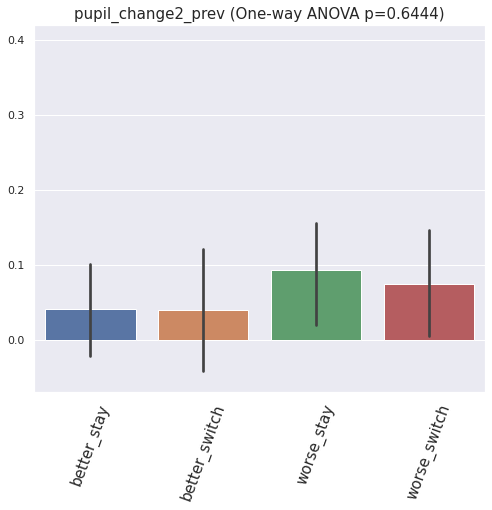

In [165]:
from scipy.stats import f_oneway


gridsize = (1,1)
fig = plt.figure(figsize=(7, 7))

sns.barplot(data = arr_all_df)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.07,0.42])
plt.tight_layout()

ss, ppp = f_oneway(arr_all_df.iloc[:,0], arr_all_df.iloc[:,1], arr_all_df.iloc[:,2], arr_all_df.iloc[:,3])
title = f'{columns_to_include} (One-way ANOVA p={round(ppp,4)})'
plt.title(title, fontsize=15)

In [155]:
arr_all_df.iloc[:,0]

0     0.332242
1     0.290063
2     0.163551
3     0.162048
4     0.102875
5     0.535618
6     0.100016
7     0.523867
8     0.379867
9     0.280957
10    0.489599
11    0.427780
12    0.052519
13    0.819150
14    0.269733
15    0.076074
16    0.604028
17   -0.119459
18    0.159823
19    0.194790
20    0.395560
21    0.288464
22    0.215791
23    0.157106
24    0.229024
25   -0.415284
26    0.150559
27    0.160319
28   -0.135741
29    0.293109
30    0.426530
31    0.283016
32    0.255830
33    0.753222
34    0.023807
35    0.098600
36    0.461471
37    0.602919
38   -0.165148
39    0.315698
40    0.146575
41    0.069546
42    0.205515
43    0.283819
44    0.407675
45    0.706591
46    0.452950
47    0.573514
48    0.203063
49    0.280203
50    0.404925
51    0.259738
Name: better_stay, dtype: float64

In [167]:
from scipy.stats import f_oneway

ss, ppp = f_oneway(arr_all_df.iloc[:,0], arr_all_df.iloc[:,1], arr_all_df.iloc[:,2], arr_all_df.iloc[:,3])


F_onewayResult(statistic=6.0864693621039825, pvalue=0.0005496562277273053)